# Processes

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, sampler

import statsmodels as sm
import sklearn.metrics
from sklearn.metrics import mean_squared_error

import math

import base64
import requests



%matplotlib inline


USE_GPU = True
dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

scenario_modelling = False
countries, indicators = "", ""

## Loaders, preprocessers, plotters

### Data loaders

In [ ]:
class DataHolder():

  def __init__(self):
    self.population = pd.read_csv("https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/population.csv", sep=';', encoding='latin')
    self.gdp = pd.read_csv("https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/GDP.csv", sep=';', encoding='latin')
    self.energy = pd.read_csv("https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/energy.csv", sep=';', encoding='latin')
    self.co2 = pd.read_csv("https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/CO2.csv", sep=';', encoding='latin')
    self.electricity = pd.read_csv("https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/electricity.csv", sep=';', encoding='latin')

data_holder = DataHolder()

In [ ]:
def load_population(name):
  df = data_holder.population.drop(labels=['Country Code', 'Indicator Name', 'Indicator Code'], axis=1).set_index('Country Name')
  
  return np.array(df.loc[name].values, dtype=np.float32)

def load_gdp(name):
  df = data_holder.gdp.drop(labels=['Country Code', 'Indicator Name', 'Indicator Code'], axis=1).set_index('Country Name')
  
  return np.array(df.loc[name].values, dtype=np.float32)

def load_energy(name):
  df = data_holder.energy.drop(labels=['Product', 'Flow'], axis=1).set_index('Country')
  
  return np.array(df.loc[name].values, dtype=np.float32)

def load_co2(name):
  df = data_holder.co2.set_index('Region/Country/Economy')
  
  return np.array(df.loc[name].values, dtype=np.float32)

def temperature_dataset_country_name_converter(name):
  if name == "United States":
    return "USA"
  
  name = name.replace(" ", "_")

  return name

def load_temperature(name):
  name = temperature_dataset_country_name_converter(name)
  url = "https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/temperature/crucy.v4.04.1901.2019."+name+".tmp.per"

  file_raw = str(requests.get(url).content)
  file_lines = file_raw.split(sep='\\n')[4:]
  
  length = 2019 - 1901 + 1
  temperature_table = np.zeros((length, 18), dtype=np.float32)

  for i in range(length):
    temperature_table[i] = file_lines[i].split()

  temperature_table = temperature_table[:,-1]
  temperature_table = np.where(temperature_table == -999, np.nan, temperature_table)
  return temperature_table

def load_electricity_mix(name):
  df = data_holder.electricity.set_index('Country').drop(labels=['Product'], axis=1)

  electricity_supplies = np.array(df.loc[name].values, dtype=np.float32)
  electricity_mix = electricity_supplies[0:3,:] / electricity_supplies[3,:]

  return electricity_mix


In [ ]:
# def load_population(name):
#   # url = 
#   df = data_holder.population.drop(labels=['Country Code', 'Indicator Name', 'Indicator Code'], axis=1).set_index('Country Name')
  
#   return np.array(df.loc[name].values, dtype=np.float32)

# def load_gdp(name):
#   url = "https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/GDP.csv"
#   df = pd.read_csv(url, sep=';', encoding='latin').drop(labels=['Country Code', 'Indicator Name', 'Indicator Code'], axis=1).set_index('Country Name')
  
#   return np.array(df.loc[name].values, dtype=np.float32)

# def load_energy(name):
#   url = "https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/energy.csv"
#   df = pd.read_csv(url, sep=';', encoding='latin').drop(labels=['Product', 'Flow'], axis=1).set_index('Country')
  
#   return np.array(df.loc[name].values, dtype=np.float32)

# def load_co2(name):
#   url = "https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/CO2.csv"
#   df = pd.read_csv(url, sep=';', encoding='latin').set_index('Region/Country/Economy')
  
#   return np.array(df.loc[name].values, dtype=np.float32)

# def temperature_dataset_country_name_converter(name):
#   if name == "United States":
#     return "USA"
  
#   name = name.replace(" ", "_")

#   return name

# def load_temperature(name):
#   name = temperature_dataset_country_name_converter(name)
#   url = "https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/temperature/crucy.v4.04.1901.2019."+name+".tmp.per"

#   file_raw = str(requests.get(url).content)
#   file_lines = file_raw.split(sep='\\n')[4:]
  
#   length = 2019 - 1901 + 1
#   temperature_table = np.zeros((length, 18), dtype=np.float32)

#   for i in range(length):
#     temperature_table[i] = file_lines[i].split()

#   temperature_table = temperature_table[:,-1]
#   temperature_table = np.where(temperature_table == -999, np.nan, temperature_table)
#   return temperature_table

# def load_electricity_mix(name):
#   url = "https://raw.githubusercontent.com/PierreBrowne/ICL_master_project/main/Datasets/Kaya/electricity.csv"
#   df = pd.read_csv(url, sep=';', encoding='latin').set_index('Country').drop(labels=['Product'], axis=1)

#   electricity_supplies = np.array(df.loc[name].values, dtype=np.float32)
#   electricity_mix = electricity_supplies[0:3,:] / electricity_supplies[3,:]

#   return electricity_mix


In [ ]:
def load_country_data(name, indicators):
  length = 2019 - 1971 + 1
  result = np.zeros((len(indicators), length), dtype=np.float32)

  i = 0
  if "Population" in indicators:
    result[i] = load_population(name)[-length:]
    i+=1
  if "GDP" in indicators:
    result[i] = load_gdp(name)[-length:]
    i+=1
  if "Energy supply" in indicators:
    result[i] = load_energy(name)[-length:]
    i+=1
  if "FC CO2 emissions" in indicators:
    result[i] = load_co2(name)[-length:]
    i+=1
  

  if "GDP per capita" in indicators:
    result[i] = load_gdp(name)[-length:] / load_population(name)[-length:]
    i += 1
  if "Energy intensity" in indicators:
    result[i] = load_energy(name)[-length:] / load_gdp(name)[-length:]
    i += 1
  if "Carbon intensity" in indicators:
    result[i] = load_co2(name)[-length:] / load_energy(name)[-length:]
    i += 1


  if "Fossil fuels" in indicators and "Nuclear" in indicators and "Renewables" in indicators:
    result[i:i+3] = load_electricity_mix(name)[-length:]
    i += 3
  if "Temperature" in indicators:
    result[i] = load_temperature(name)[-length:]
    i += 1

  return result

def load_dataset(countries, indicators):
  result = [load_country_data(name, indicators) for name in countries]
  return np.array(result)



### Normalization methods

In [ ]:
def normalize_dataset(dataset, min=0, max = 1):
  result = (dataset - np.nanmin(dataset, axis=2, keepdims=True)) / (np.nanmax(dataset, axis=2, keepdims=True) - np.nanmin(dataset, axis=2, keepdims=True)) * (max - min) + min
  return result

def denormalize_forecast(original_dataset, forecast):
  
  if torch.is_tensor(forecast):
    result = forecast.detach().numpy()
  else:
    result = forecast.copy()

  sigma = (np.nanmax(original_dataset, axis=2, keepdims=True) - np.nanmin(original_dataset, axis=2, keepdims=True))
  mu = np.nanmin(original_dataset, axis=2, keepdims=True)

  result = sigma * result + mu 
  return result


def normalize_globally_dataset(dataset, min=0, max = 1):
  for j in range(dataset.shape[1]):
    dataset[:,j,:] = (dataset[:,j,:] - np.nanmin(dataset[:,j,:], keepdims=True)) / (np.nanmax(dataset[:,j,:], keepdims=True) - np.nanmin(dataset[:,j,:], keepdims=True)) * (max-min) + min

  return dataset

def normalize_average_dataset(dataset):
  for i in range(dataset.shape[0]):
    for j in range(dataset.shape[1]):
        dataset[i,j,:] /= np.average(dataset[i,j,:])
      
  return dataset


def initialize_dataset(dataset):
  for i in range(dataset.shape[0]):
    for j in range(dataset.shape[1]):
      
      if j == 1:
        dataset[i,j,1:] /= dataset[i,j,:-1]
        dataset[i,j,0] = 1
      
      else:
        dataset[i,j,:] /= dataset[i,j,np.isfinite(dataset[i,j,:])][0]
      
  return dataset


def relative_change_inialize_dataset(dataset):
  for i in range(dataset.shape[0]):
    for j in range(dataset.shape[1]):
      dataset[i,j,:] = (dataset[i,j,:] - dataset[i,j,0]) / dataset[i,j,0]
      
  return dataset


### Plotters

In [ ]:
def plot_dataset_and_predictions_singlecountry(training_dataset, validation_dataset, predictions, titles, savefig):
  
    fig, axs = plt.subplots(1,len(indicators), figsize=(25,7))

    tab_colors = ['tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    country = countries[0]

    nb_training_dates = training_dataset.shape[2]
    # train_dates = np.arange(1971, 1971 + training_dataset.shape[2])

    if scenario_modelling:
      all_dates = scenario_dates
    else:
      nb_validation_dates = validation_dataset.shape[2]
      validation_dates = np.arange(1971 + nb_training_dates, 1971 + nb_training_dates + nb_validation_dates)
      all_dates = np.arange(1971, 1971 + nb_training_dates + nb_validation_dates)


    if len(indicators) == 1:
      axs = [axs]

    for j, indicator in enumerate(indicators):
    
      axs[j].scatter(all_dates[:nb_training_dates], training_dataset[0,j], c='tab:blue')

      if not scenario_modelling:
        axs[j].scatter(validation_dates, validation_dataset[0,j], c='tab:orange')

      for k, (prediction, title) in enumerate(zip(predictions, titles)):
        axs[j].plot(all_dates[-len(prediction[0,j]):], prediction[0,j], c=tab_colors[k], label=title)
    
      if indicator in ["Fossil fuels", "Nuclear", "Renewables"]:
        axs[j].set_ylim(-0.05, 1.05)

      axs[j].set_title(indicator + ", " + country)
      
      if len(titles) >= 2:
        axs[j].legend()

    if savefig:
      fig.savefig("plot.png",bbox_inches='tight')
    plt.show()

In [ ]:
def plot_dataset_and_predictions_multicountry(training_dataset, validation_dataset, prediction = [], title = "", savefig = False):
    

    nb_training_countries, nb_indicators, nb_dates = training_dataset.shape
    nb_validation_countries = validation_dataset.shape[0]

    all_dates = np.arange(1971, 1971 + nb_dates)


    tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'magenta', 'green']

    fig, axs = plt.subplots(1,len(indicators), figsize=(25,7))
    if len(indicators) == 1:
      axs = [axs]
    

    for j in range(nb_indicators):

      for i in range(nb_training_countries):
      
        # validation_dates = np.arange(1971 + training_dataset.shape[2], 1971 + training_dataset.shape[2] + validation_dataset.shape[2])
        # all_dates = np.arange(1971, 1971 + training_dataset.shape[2] + validation_dataset.shape[2])

        # if len(titles) > 0:
        #   axs[j].scatter(all_dates, training_dataset[i,j], c=tab_colors[i], marker='+')
        # else:
        # axs[j].scatter(validation_dates, validation_dataset[i,j], c=tab_colors[i])

        
        # for (prediction, title) in zip(predictions, titles):

        if len(prediction) > 0:
          axs[j].scatter(all_dates, training_dataset[i,j], c=tab_colors[i], marker='+')
          axs[j].plot(all_dates[-len(prediction[i,j]):], prediction[i,j], c=tab_colors[i], label=countries[i])
        else:
          axs[j].scatter(all_dates, training_dataset[i,j], c=tab_colors[i], marker='+', label=countries[i])

      for i in range(nb_validation_countries):
        k = nb_training_countries + i


        if len(prediction) > 0:
          axs[j].scatter(all_dates, validation_dataset[i,j], c=tab_colors[k])
          axs[j].plot(all_dates[-len(prediction[k,j]):], prediction[k,j], c=tab_colors[k], label=countries[k])
        else:
          axs[j].scatter(all_dates, validation_dataset[i,j], c=tab_colors[k], label=countries[k])


      
      if indicators[j] in ["Fossil fuels", "Nuclear", "Renewables"]:
        axs[j].set_ylim(-0.05, 1.05)
        
      axs[j].set_title(indicators[j] + ", " + title)
      
      
      axs[j].legend()


    if savefig:
      fig.savefig("plot.png",bbox_inches='tight')
    plt.show()

In [ ]:
def plot_dataset_and_predictions(training_dataset, validation_dataset = None, predictions = [], titles = [], savefig = False):
    nb_training_countries = training_dataset.shape[0]
    
    if nb_training_countries == 1:
        plot_dataset_and_predictions_singlecountry(training_dataset, validation_dataset, predictions, titles, savefig)
    else:
        if len(predictions) > 0:
          for (prediction, title) in zip(predictions, titles):
              plot_dataset_and_predictions_multicountry(training_dataset, validation_dataset, prediction, title, savefig)
        else:
          plot_dataset_and_predictions_multicountry(training_dataset, validation_dataset, savefig = savefig)


## Neural ODEs

### Core package

In [ ]:
''' 
Code from Fei Cheung
https://github.com/feicccccccc/Neural-ODE-Ex
'''

class ODEfunc(nn.Module):

    def forward_with_grad(self, z, t, grad_outputs):
      
        batch_size = z.shape[0]

        # feed forward of f(z,t), by using autograd we can compute the jacobian
        out = self.forward(z, t)
        # direction for autograd
        a = grad_outputs

        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,)
            , (z, t) + tuple(self.parameters())
            , grad_outputs=(a)
            , allow_unused=True
            , retain_graph=True
        )

        # grad method automatically sums gradients for batch items, we have to expand them back
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten() for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
      
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)


def ode_solve(z0, t0, t1, f):
  
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0) / h_max).max().item())

    h = (t1 - t0) / n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z


class ODEAdjoint(torch.autograd.Function):
  
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
      
        assert isinstance(func, ODEfunc)
        bs, *z_shape = z0.size()    # (batch size, z_shape), *for unrolling the tuple
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):

        # for enabling Pycharm breakpoint in backward function
        # disable to run in normal mode
        # import pydevd
        # pydevd.settrace(suspend=False, trace_only_current_thread=True)

        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()

        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
          
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim)
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience

        with torch.no_grad():
            # Create placeholders for output gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            # actually I have no idea why we need dLdt and dLdz, but anyway
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                # batch matrix product
                a_t = torch.transpose(dLdz_i.unsqueeze(-1), 1, 2)
                dLdt_i = -torch.bmm(a_t, f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                # Think in terms of chain rule with fix paramter on different node
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] + dLdt_i

                # Pack augmented variable
                # z(t_N), adj_z, 0, adj_t
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients
            dLdz_0 = dLdz[0]
            dLdt_0 = -torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] + dLdt_0
        # forward: (z0, t, parameters, func)
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None
  


class NeuralODE(nn.Module):
  
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEfunc)
        self.func = func

    def forward(self, z0, t=torch.tensor([0., 1.]), return_whole_sequence=False):
      
        t = t.to(z0)    # Match the data type to z0
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]


### Architectures

#### Shallow linear cell

In [ ]:
class ShallowLinearODEF(ODEfunc):
    def __init__(self, nb_indicators, input_size, hidden_size = 64):
      super(ShallowLinearODEF, self).__init__()

      self.input_encoding = -1

      self.nb_training_countries = input_size - (nb_indicators + 1)

      # print(input_size)

      # if activation == "relu":
      #     self.main = nn.Sequential(nn.Linear(input_size, hidden_size),
      #                           nn.Dropout(0.5),
      #                           nn.ReLU(),
      #                           nn.Linear(hidden_size, nb_indicators))
      
      # else:
      self.main = nn.Sequential(nn.Linear(input_size, hidden_size),
                            nn.Dropout(0.5),
                            nn.Tanh(),
                            nn.Linear(hidden_size, nb_indicators))

    def forward(self, x, t):
      y1 = torch.cat([x, t.view(1,1)], dim=-1)

      # if self.input_encoding != -1:
      #   y2 = torch.cat([y1, torch.tensor([self.input_encoding])], dim=-1)
      #   z = self.main(y2)
      # else:

      z = self.main(y1)


      # print(z.shape)

      if "Electricity - fossil fuels" in indicators:
        i = indicators.index("Electricity - fossil fuels")
        z_1 = z[:,i:i+3]
        z_2 = z_1 - torch.mean(z_1[:,:], dim=1, keepdims=True)
        
        z = torch.cat((z[:,:i], z_2), dim=1)
        # print(result.shape)
        # return result
      
      if self.nb_training_countries > 1:
        
        z_3 = torch.zeros((1, self.nb_training_countries))
        z = torch.cat((z, z_3), dim=1)

      return z


#### Other architectures

In [ ]:
class LinearODEF(ODEfunc):
    def __init__(self, nb_indicators, input_size, hidden_size = 64, activation = "tanh"):
      super(LinearODEF, self).__init__()

      self.input_encoding = -1


      if activation == "relu":
          self.main = nn.Sequential(nn.Linear(input_size, hidden_size*input_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(hidden_size*input_size, hidden_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(hidden_size, nb_indicators))
      
      else:
          self.main = nn.Sequential(nn.Linear(input_size, hidden_size),
                                nn.Dropout(0.2),
                                nn.Tanh(),
                                nn.Linear(hidden_size, nb_indicators))

    def forward(self, x, t):
      y1 = torch.cat([x, t.view(1,1)], dim=-1)

      # print(self.input_encoding)

      if self.input_encoding != -1:
        # y2 = torch.cat([y1, torch.tensor([[self.input_encoding]])], dim=-1)
        y2 = torch.cat([y1, torch.tensor([self.input_encoding])], dim=-1)
        z = self.main(y2)
      else:
        z = self.main(y1)

      # print(z.shape)

      if "Electricity - fossil fuels" in indicators:
        i = indicators.index("Electricity - fossil fuels")
        z_1 = z[:,i:i+3]
        z_2 = z_1 - torch.mean(z_1[:,:], dim=1, keepdims=True)
        
        result = torch.cat((z[:,:i], z_2), dim=1)
        # print(result.shape)
        return result
      
      return z



class DeepLinearODEF(ODEfunc):
    def __init__(self, input_size, hidden_size = 64):
      super(DeepLinearODEF, self).__init__()

      self.main = nn.Sequential(nn.Linear(input_size + 1, input_size * hidden_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(input_size * hidden_size, input_size * hidden_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(input_size * hidden_size, input_size * hidden_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(input_size * hidden_size, hidden_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(hidden_size, input_size))

    def forward(self, x, t):
      y = torch.cat([x, t.view(1,1)], dim=-1)
      result = self.main(y)
      return result


class StationaryLinearODEF(ODEfunc):
    def __init__(self, input_size, hidden_size = 64):
      super(StationaryLinearODEF, self).__init__()

      self.main = nn.Sequential(nn.Linear(input_size, input_size * hidden_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(input_size * hidden_size, input_size * hidden_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(input_size * hidden_size, input_size * hidden_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(input_size * hidden_size, hidden_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(hidden_size, input_size))

    def forward(self, x, t):
      result = self.main(x)
      return result


class ConvODEF(ODEfunc):
    def __init__(self, input_size, hidden_size = 64):
      super(ConvODEF, self).__init__()

      self.convoluted_size = (input_size + 1) * hidden_size

      self.conv = nn.Sequential(nn.Conv1d(1,hidden_size,1),
                                nn.Dropout(0.2),
                                nn.ReLU())
      
      self.linear = nn.Sequential(nn.Linear(self.convoluted_size, hidden_size),
                                nn.Dropout(0.2),
                                nn.ReLU(),
                                nn.Linear(hidden_size, input_size))

    def forward(self, x, t):
      y = torch.cat([x, t.view(1,1)], dim=-1)
      y = y.unsqueeze(0)

      y = self.conv(y)
      result = self.linear(y.view(1, self.convoluted_size))
      return result


### Auxiliaries

In [ ]:
def NODE_convert_dataset(training_dataset, validation_dataset):
    intermediary_training_dataset, intermediary_validation_dataset = multicountry_convert_datasets(training_dataset, validation_dataset)

    nb_training_countries, _, nb_training_dates = intermediary_training_dataset.shape
    t_training = torch.linspace(0,1,nb_training_dates)

    NODE_training_dataset = (torch.transpose(intermediary_training_dataset, 1, 2)).unsqueeze(2).clone()
    NODE_validation_dataset = (torch.transpose(intermediary_validation_dataset, 1, 2)).unsqueeze(2).clone()

    if nb_training_countries == 1:
      t_step = 1 / (nb_training_dates - 1)
      
      nb_validation_dates = intermediary_validation_dataset.shape[2]
      t_extrapolation = torch.arange(1, 1 + (nb_validation_dates + 0.5) * t_step, t_step)
      
      t_validation = torch.cat((t_training[:-1], t_extrapolation))
    

    else:
      t_validation = t_training

    return NODE_training_dataset, NODE_validation_dataset, t_training, t_validation

In [ ]:
def plot_losses(losses):
  plt.figure()
  plt.yscale("log")
  plt.plot(losses)
  plt.show

### Training routine

In [ ]:
def select_obs_batch(dataset_gpu, t):
  nb_dates = dataset_gpu.shape[1]

  min_nb_dates = np.max((np.min((4, int(nb_dates*0.1))), 2))
  max_nb_dates = np.min((20, int(nb_dates*0.9)))

  nb_indices = np.random.choice(np.arange(min_nb_dates, max_nb_dates))
  indices = np.random.choice(nb_dates, nb_indices, replace=False)
  
  indices.sort()

  return dataset_gpu[:, indices, :, :], t[indices]


In [ ]:
def impute_nan(y_predicted, y_expected):
  with torch.no_grad():
    nan_indices = torch.isnan(y_expected)
    y_expected[nan_indices] = y_predicted[nan_indices]
  return y_expected

In [ ]:
def NODE_forecast(training_dataset, validation_dataset, model):

  # if scenario_modelling:
  #   t_validation = t_extrapolation
  #   NODE_training_dataset, _, _, _ = NODE_convert_dataset(training_dataset, np.zeros((1,1,1)))
  # else:
  NODE_training_dataset, NODE_validation_dataset, _, t_validation = NODE_convert_dataset(training_dataset, validation_dataset)
    

  all_dates = len(t_validation)
  nb_training_countries, nb_indicators, nb_training_dates = training_dataset.shape

  if nb_training_countries == 1:
    forecast_dataset = torch.zeros((nb_training_countries, nb_indicators, all_dates))
  else:
    nb_validation_countries = validation_dataset.shape[0]
    forecast_dataset = torch.zeros((nb_training_countries + nb_validation_countries, nb_indicators, all_dates))


  for i in range(nb_training_countries):
    
    z_extrapolated = model(NODE_training_dataset[i,0], t_validation, return_whole_sequence=True).cpu().detach()
    forecast_dataset[i,:,:] = torch.transpose(z_extrapolated[:, 0, : nb_indicators], 0, 1)
  
    if nb_training_countries > 1:
      for i in range(nb_validation_countries):
        j = i + nb_training_countries

        z_extrapolated = model(NODE_validation_dataset[i,0], t_validation, return_whole_sequence=True).cpu().detach()
        forecast_dataset[j,:,:] = torch.transpose(z_extrapolated[:, 0, : nb_indicators], 0, 1)
  

  if scenario_modelling:
    perf = 0
  elif nb_training_countries == 1:     
    perf = np.array([mean_squared_error(validation_dataset[i], forecast_dataset[i,:,-validation_dataset.shape[2]:]) for i in range(nb_training_countries)])
  else:
    perf = np.array([mean_squared_error(validation_dataset[i], forecast_dataset[i + nb_training_countries, :, :]) for i in range(nb_validation_countries)])

  return forecast_dataset, perf

In [ ]:
def NODE_train(model, optimizer, training_dataset, validation_dataset, batch_size = 1, alpha=1, n_step = 2000, n_plot = 100, plotting=True):
  
  NODE_training_dataset, _, t_training, _ = NODE_convert_dataset(training_dataset, validation_dataset)
  
  losses = []
  NODE_training_dataset_gpu = NODE_training_dataset.to(device = device)
  
  nb_training_countries, nb_dates, _, nb_indicators = NODE_training_dataset.shape
  if nb_training_countries > 1:
    nb_indicators -= nb_training_countries

  step = 0

  
  while step < n_step:

    for i in range(nb_training_countries):
      loss = 0

      for k in range(batch_size):


        # if alpha != 1:
        #   z = model(dataset_gpu[i,0], t, return_whole_sequence = True)
        #   loss += (1-alpha) * F.mse_loss(z, dataset_gpu[i])
        #   # loss += (1-alpha) * F.l1_loss(z, dataset_gpu[i])

        if alpha != 0:
          NODE_training_dataset_gpu_batch, t_batch = select_obs_batch(NODE_training_dataset_gpu, t_training)

          z_batch = model(NODE_training_dataset_gpu_batch[i,0], t_batch, return_whole_sequence = True)
            
          loss += alpha * F.mse_loss(z_batch[:, :, : nb_indicators], NODE_training_dataset_gpu_batch[i, :, :, : nb_indicators])


        step += 1
        if n_plot != 0 and (step+1) % n_plot == 0:
          if plotting:
            print("step: {}, loss: {}".format(step+1, loss))

            model.eval()            
            forecast, _ = NODE_forecast(training_dataset, validation_dataset, model)
            plot_dataset_and_predictions(training_dataset, validation_dataset, [forecast], ["NODE"])
            model.train()

      model.eval()
      _, perf = NODE_forecast(training_dataset, validation_dataset, model)
      perfs.append(perf)
      model.train()

      loss /= batch_size

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      losses.append(loss.item())
  
  return model, losses

In [ ]:
def NODE_init_and_train(training_dataset, validation_dataset, architecture, hidden_size, n_step, n_plot, batch_size, lr, weight_decay = 0):
    
    nb_training_countries, nb_indicators, _ = training_dataset.shape
    nb_inputs = nb_indicators + 1

    if nb_training_countries > 1:
        nb_inputs += nb_training_countries

    model = NeuralODE(architecture(nb_indicators, nb_inputs, hidden_size)).to(device=device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.train()
    model, losses = NODE_train(model, optimizer, training_dataset, validation_dataset, batch_size = batch_size, alpha=1, n_step=n_step, n_plot=n_plot)
    model.eval()

    return model, losses

### Scenario auxiliaries

In [ ]:
def add_observation(training_dataset, t, country, indicator, normalized_date, value):
  indicator_index = indicators.index(indicator)
  country_index = countries.index(country)

  nb_countries, nb_dates, _, nb_indicators = training_dataset.shape

  if normalized_date not in t:
    t_scenario = torch.cat((t, torch.tensor([normalized_date])))
    t_scenario, permutation = torch.sort(t_scenario)

    new_date_data = torch.tensor([[float('nan') for i in range(nb_indicators)] for j in range(nb_countries)]).view(nb_countries, 1, 1, nb_indicators)
    training_dataset_scenario = torch.cat((training_dataset, new_date_data), dim = 1)
    training_dataset_scenario = training_dataset_scenario[:,permutation,:,:]

    nb_dates += 1
  else:
    training_dataset_scenario = training_dataset.clone()
    t_scenario = t.clone()
  

  training_dataset_scenario[country_index, t_scenario == normalized_date, 0, indicator_index] = value

  return training_dataset_scenario, t_scenario



## Other models

### Feedforward NN

In [ ]:
class FFNN(nn.Module):
    def __init__(self, input_length, nb_indicators, hidden_layer_size, output_length = 1):
        super().__init__()

        self.hidden_layer_size = hidden_layer_size

        self.nb_indicators = nb_indicators
        self.input_length = input_length
        self.output_length = output_length

        self.input_size = input_length * nb_indicators
        self.output_size = output_length * nb_indicators

        self.main = nn.Sequential(nn.Linear(self.input_size, hidden_layer_size),
                              # nn.Dropout(0.2),
                              nn.Tanh(),
                              nn.Linear(hidden_layer_size, self.output_size))
      


    def forward(self, input_seq):

        input_seq = torch.flatten(input_seq)
        
        output_seq = self.main(input_seq)

        return torch.reshape(output_seq, (self.nb_indicators, self.output_length))

In [ ]:
def FFNN_forecast(training_dataset, validation_dataset, model):

    input_length = model.input_length

    if not torch.is_tensor(training_dataset):
      training_dataset, validation_dataset = multicountry_convert_datasets(training_dataset, validation_dataset)

    nb_training_countries, nb_indicators, nb_training_dates = training_dataset.shape

    # else:
    #   if nb_training_countries > 1:
    #     nb_indicators -= nb_training_countries
    

    if nb_training_countries == 1:
      forecast_length = validation_dataset.shape[2]    
      forecast_dataset = torch.zeros((nb_training_countries, nb_indicators, nb_training_dates + forecast_length - input_length))
    else:
      nb_validation_countries = validation_dataset.shape[0]
      forecast_length = 0
      forecast_dataset = torch.zeros((nb_training_countries + nb_validation_countries, nb_indicators, nb_training_dates - input_length))


    def FFNN_forecast_select_input(dataset, forecast_dataset):
        if k + input_length <= nb_training_dates:
            return dataset[i,:, k : k + input_length]
        elif k < nb_training_dates:
            return torch.cat((dataset[i, :, k :], forecast_dataset[i, :, nb_training_dates - input_length : k ]), axis = 1)
        else:
            return forecast_dataset[i, :, k - input_length : k]




    for i in range(nb_training_countries):
      k = 0

      while k + input_length < nb_training_dates + forecast_length:
        input_seq = FFNN_forecast_select_input(training_dataset, forecast_dataset)
        
        input_seq = input_seq.to(device=device, dtype=dtype)
        forecast_output_seq = model(input_seq)

        forecast_dataset[i,:,k] = forecast_output_seq[:,0]

        k += 1
    

    if nb_training_countries > 1:
      for i in range(nb_validation_countries):
        k = 0

        while k + input_length < nb_training_dates:
          input_seq = FFNN_forecast_select_input(validation_dataset, forecast_dataset)
          
          input_seq = input_seq.to(device=device, dtype=dtype)
          forecast_output_seq = model(input_seq)

          forecast_dataset[nb_training_countries + i,:,k] = forecast_output_seq[:,0]

          k += 1



 

    forecast_dataset = forecast_dataset.detach().numpy()

    if scenario_modelling:
      perf = np.array([0])

    elif nb_training_countries == 1:
      perf = np.zeros(1)

      if np.any(np.isnan(forecast_dataset[0,:,-forecast_length:])):
        perf[0] = 1
      else:
        perf[0] = mean_squared_error(validation_dataset[i], forecast_dataset[i,:,-forecast_length:])
    
    else:
      perf = np.zeros(nb_validation_countries)
      nb_indicators -= nb_training_countries
      
      for i in range(nb_validation_countries):
        if np.any(np.isnan(forecast_dataset[nb_training_countries + i,:,:])):
          perf[i] = 1
        else:
          perf[i] = mean_squared_error(validation_dataset[i, : nb_indicators, input_length:], forecast_dataset[nb_training_countries + i, : nb_indicators,:])

    return forecast_dataset[:, : nb_indicators, :], perf

In [ ]:
def FFNN_train(model, optimizer, training_dataset, validation_dataset, n_step, n_plot, plotting = True):
  losses = []
  step = 0

  nb_training_countries, nb_indicators, nb_training_dates = training_dataset.shape
  FFNN_training_dataset, FFNN_validation_dataset = multicountry_convert_datasets(training_dataset, validation_dataset)

  input_length = model.input_length

  model = model.to(device=device)
  model.train()
  
  while step < n_step:

    for i in range(nb_training_countries):
      loss = 0

      k = 0

      while k + input_length + 1 <= nb_training_dates:

        input_seq = FFNN_training_dataset[i,:, k : k + input_length]
        expected_output_seq = FFNN_training_dataset[i, : nb_indicators, k + input_length : k + input_length + 1]
        k += 1

        input_seq = input_seq.to(device=device, dtype=dtype)
        expected_output_seq = expected_output_seq.to(device=device, dtype=dtype)

        forecast_output_seq = model(input_seq)[: nb_indicators, :]
        loss = nn.MSELoss()(forecast_output_seq, expected_output_seq)
        
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())


        step += 1
        if n_plot != 0 and (step+1) % n_plot == 0:
          if plotting:
            print("step: {}, loss: {}".format(step+1, loss))
            model.eval()
            
            forecast, _ = FFNN_forecast(FFNN_training_dataset, FFNN_validation_dataset, model)
            plot_dataset_and_predictions(training_dataset, validation_dataset, [forecast], ["FFNN"])
            model.train()
    
  return model, losses

In [ ]:
def FFNN_init_and_train(training_dataset, validation_dataset, input_length, hidden_size, n_step, n_plot, lr, weight_decay = 0):

    nb_training_countries, nb_indicators, nb_training_dates = training_dataset.shape

    if nb_training_dates < 2*input_length:
      input_length = nb_training_dates // 2

    if nb_training_countries == 1:
      model = FFNN(input_length, nb_indicators, hidden_size)
    else:
      model = FFNN(input_length, nb_indicators + nb_training_countries, hidden_size)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.train()
    model, losses = FFNN_train(model, optimizer, training_dataset, validation_dataset, n_step=n_step, n_plot=n_plot)
    model.eval()

    return model, losses


### Autoregressive LSTM model

In [ ]:
class LSTM(nn.Module):
    def __init__(self, nb_indicators, hidden_layer_size, output_length = 1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.nb_indicators = nb_indicators
        self.output_length = output_length

        self.lstm = nn.LSTM(nb_indicators, hidden_layer_size)#, dropout = 0.2)

        self.linear = nn.Linear(hidden_layer_size, nb_indicators * output_length)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):

        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size, device=device, dtype=dtype),
                            torch.zeros(1, 1, self.hidden_layer_size, device=device, dtype=dtype))
        
        input_seq = input_seq.unsqueeze(1)

        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        linear_in = lstm_out[-1,0,:]

        linear_out = self.linear(linear_in)

        return linear_out.view(self.output_length, self.nb_indicators)

In [ ]:
def LSTM_forecast(training_dataset, validation_dataset, model):
  nb_training_countries, nb_indicators, nb_training_dates = training_dataset.shape

  if not torch.is_tensor(training_dataset):
    training_dataset, validation_dataset = multicountry_convert_datasets(training_dataset, validation_dataset)
  else:
    if nb_training_countries > 1:
      nb_indicators -= nb_training_countries




  if nb_training_countries == 1:
    forecast_length = validation_dataset.shape[2]
    forecast_dataset = np.zeros((nb_training_countries, nb_indicators, nb_training_dates + forecast_length - 1))
  else:
    nb_validation_countries = validation_dataset.shape[0]
    forecast_length = 0
    forecast_dataset = np.zeros((nb_training_countries + nb_validation_countries, nb_indicators, nb_training_dates - 1))


  for i in range(nb_training_countries):
    k = 1

    while k < nb_training_dates:
      input_seq = torch.transpose(training_dataset[i,:, : k], 0, 1)
      input_seq = input_seq.to(device=device, dtype=dtype)

      forecast_output_seq = torch.transpose(model(input_seq), 0, 1).detach().numpy() 
      forecast_dataset[i,:,k-1] = forecast_output_seq[: nb_indicators,0]

      k += 1
    
    while k < nb_training_dates + forecast_length:
      input_seq = torch.transpose(torch.cat((training_dataset[i,:,:], torch.tensor(forecast_dataset[i,:, nb_training_dates - 1: k-1])), axis=1), 0, 1)
      input_seq = input_seq.to(device=device, dtype=dtype)

      forecast_output_seq = torch.transpose(model(input_seq), 0, 1).detach().numpy() 
      forecast_dataset[i,:,k-1] = forecast_output_seq[: nb_indicators,0]
      
      k += 1
  

  if nb_training_countries > 1:
    for i in range(nb_validation_countries):
      k = 1
      j = i + nb_training_countries

      while k < nb_training_dates:
        input_seq = torch.transpose(validation_dataset[i,:, : k], 0, 1)
        input_seq = input_seq.to(device=device, dtype=dtype)

        forecast_output_seq = torch.transpose(model(input_seq), 0, 1).detach().numpy() 
        forecast_dataset[j,:,k-1] = forecast_output_seq[: nb_indicators,0]

        k += 1


  if scenario_modelling:
    perf = np.array([0])

  elif nb_training_countries == 1:
    perf = np.zeros(1)
    
    if np.any(np.isnan(forecast_dataset[0,:,-forecast_length:])):
      perf[0] = 1
    else:
      perf[0] = mean_squared_error(validation_dataset[i], forecast_dataset[i,:,-forecast_length:])
  
  else:
    perf = np.zeros(nb_validation_countries)

    for i in range(nb_validation_countries):
      j = nb_training_countries + i

      if np.any(np.isnan(forecast_dataset[i,:,:])):
        perf[i] = 1
      else:
        perf[i] = mean_squared_error(validation_dataset[i,:nb_indicators,1:], forecast_dataset[j,:nb_indicators,:])

  # perf = np.array([mean_squared_error(validation_dataset[i], forecast_dataset[i,:,-forecast_length:]) for i in range(nb_training_countries)])

  # perfs.append(perf[0])
  return forecast_dataset, perf

In [ ]:
def LSTM_train(model, optimizer, training_dataset, validation_dataset, n_step, n_plot, plotting = True):
  losses = []
  step = 0

  nb_training_countries, nb_indicators, nb_training_dates = training_dataset.shape
  LSTM_training_dataset, LSTM_validation_dataset = multicountry_convert_datasets(training_dataset, validation_dataset)

  model = model.to(device=device)
  model.train()
  
  while step < n_step:

    for i in range(nb_training_countries):
      loss = 0

      # if nb_countries > 1:
      #   # print(i)
      #   model.func.input_encoding = [1 if j==i else 0 for j in range(nb_countries)]

      k = 1

      while k + 1 <= nb_training_dates:

        input_seq = torch.transpose(LSTM_training_dataset[i,:, : k], 0, 1)
        expected_output_seq = torch.transpose(LSTM_training_dataset[i, : nb_indicators, k : k + 1], 0, 1)
        k += 1

        input_seq = input_seq.to(device=device, dtype=dtype)
        expected_output_seq = expected_output_seq.to(device=device, dtype=dtype)

        forecast_output_seq = model(input_seq)[:, : nb_indicators]
        # print(forecast_output_seq.shape, expected_output_seq.shape)
        loss = nn.MSELoss()(forecast_output_seq, expected_output_seq)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())


        step += 1
        if n_plot != 0 and (step+1) % n_plot == 0:
          if plotting:
            print("step: {}, loss: {}".format(step+1, loss))
            model.eval()
            
            forecast, _ = LSTM_forecast(LSTM_training_dataset, LSTM_validation_dataset, model)
            plot_dataset_and_predictions(training_dataset, validation_dataset, [forecast], ["LSTM"])
            model.train()
    
    
  return model, losses

In [ ]:
def LSTM_init_and_train(training_dataset, validation_dataset, hidden_size, n_step, n_plot, lr, weight_decay = 0):

    nb_training_countries, nb_indicators, nb_training_dates = training_dataset.shape

    if nb_training_countries == 1:
      model = LSTM(nb_indicators, hidden_size)
    else:
      model = LSTM(nb_indicators + nb_training_countries, hidden_size)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    model.train()
    model, losses = LSTM_train(model, optimizer, training_dataset, validation_dataset, n_step=n_step, n_plot=n_plot)
    model.eval()

    return model, losses


## Scenario modelling

In [ ]:
def compare_scenario_forecasts(training_dataset, forecast_length, scenario_hypotheses, model_init_and_train, model_forecast, training_args, plotting = True, model_type=""):

  nb_indicators = training_dataset.shape[1]

  validation_dataset = np.zeros((1,1, forecast_length))
  
  model, _ = model_init_and_train(training_dataset, validation_dataset, *training_args)
  forecast_1, _ = model_forecast(training_dataset, validation_dataset, model)

  training_dataset = np.concatenate((training_dataset, np.array(scenario_hypotheses).reshape(1,nb_indicators,1)), axis=2)
  validation_dataset = np.zeros((1,1, forecast_length - 1))

  model, _ = model_init_and_train(training_dataset, validation_dataset, *training_args)
  forecast_2, _ = model_forecast(training_dataset, validation_dataset, model)

  if plotting:
    plot_dataset_and_predictions(training_dataset, predictions = [forecast_1, forecast_2], titles = [model_type + " - baseline", model_type + " - scenario"])

  return forecast_1, forecast_2

In [ ]:
def plot_scenario_emissions(original_dataset, year_skip, plotting_time_offset, forecasts):
  
  
  emissions_dataset = load_dataset(countries, ["FC CO2 emissions"])
  emissions_dataset = emissions_dataset[:,:,::year_skip]

  forecast_baseline, forecast_scenario = denormalize_forecast(original_dataset, forecasts[0]), denormalize_forecast(original_dataset, forecasts[1])


  nb_training_dates = emissions_dataset.shape[2]
  nb_forecast_dates = forecast_baseline.shape[2]

  fig = plt.figure(figsize=(15,9))
  plt.grid(True)

  plt.scatter(scenario_dates[:nb_training_dates], emissions_dataset[0,0], c = 'tab:blue')
  plt.plot(scenario_dates[plotting_time_offset : plotting_time_offset + nb_forecast_dates], forecast_baseline[0,0]*forecast_baseline[0,1]*forecast_baseline[0,2]*forecast_baseline[0,3], c='tab:green')
  plt.plot(scenario_dates[plotting_time_offset : plotting_time_offset + nb_forecast_dates], forecast_scenario[0,0]*forecast_scenario[0,1]*forecast_scenario[0,2]*forecast_scenario[0,3], c='tab:red')

  plt.title("Emissions forecasts - scenario comparison")
  plt.show()

## Auxiliaries

### Dataset conversion for multicountry training

In [ ]:
def multicountry_convert_datasets(training_dataset, validation_dataset):

  nb_training_countries, nb_indicators, nb_training_dates = training_dataset.shape

  if nb_training_countries == 1:
    return torch.tensor(training_dataset), torch.tensor(validation_dataset)
  
  else:
    nb_validation_countries = validation_dataset.shape[0]

    converted_dataset = torch.zeros((nb_training_countries + nb_validation_countries, nb_indicators + nb_training_countries, nb_training_dates))
    converted_dataset[:nb_training_countries, :nb_indicators,:] = torch.tensor(training_dataset)
    converted_dataset[nb_training_countries:, :nb_indicators,:] = torch.tensor(validation_dataset)
    
    for i in range(nb_training_countries):
      converted_dataset[i, nb_indicators + i, :] = torch.ones(nb_training_dates)
    
    return converted_dataset[:nb_training_countries], converted_dataset[nb_training_countries:]
    

### Single country evaluation - time series splitting

In [ ]:
def evaluate_singlecountry_performance(dataset, forecast_length, nb_splits, model_init_and_train, model_forecast, training_args, plotting = True, model_type=""):
  nb_dates = dataset.shape[2]
  minimal_nb_training_dates = int(1.5*forecast_length)

  time_window_shift = (nb_dates - forecast_length - minimal_nb_training_dates) // nb_splits
  split_date = nb_dates - forecast_length

  all_perfs = []

  for k in range(nb_splits):
    training_dataset = dataset[:,:, : split_date]
    validation_dataset = dataset[:,:, split_date : split_date + forecast_length]

    split_date -= time_window_shift

    # print(training_dataset.shape, validation_dataset.shape)

    model, _ = model_init_and_train(training_dataset, validation_dataset, *training_args)
    forecast, perf = model_forecast(training_dataset, validation_dataset, model)

    global all_forecasts
    all_forecasts.append(forecast)
    print(model_type, split_date)
    print(forecast)

    all_perfs.append(perf)

    if plotting:
      plot_dataset_and_predictions(training_dataset, validation_dataset, [forecast], [model_type])

  # print(all_perfs)

  return np.average(all_perfs)


In [ ]:
# indicators = ["Population", "GDP per capita", "Energy intensity", "Carbon intensity", "Electricity - fossil fuels", "Electricity - nuclear", "Electricity - renewables"]
# countries = ["France"]

# dataset = load_dataset(countries, indicators)
# dataset[:,0:4] = normalize_dataset(dataset[:,0:4], min=0, max=1)

# forecast_length = 8

# perfs = []
# evaluate_model_performance(dataset, forecast_length , 1, NODE_init_and_train, NODE_forecast, [ShallowLinearODEF, 1024, 3000, 0, 5, 0.005, 0.0001])

### Multicountry evaluation - cross-validation

In [ ]:
def evaluate_multicountry_performance(dataset, comparison_countries, model_init_and_train, model_forecast, training_args, plotting = True, model_type=""):

  nb_countries = dataset.shape[0]
  all_perfs = []

  for i in range(nb_countries):
    indices = list(range(nb_countries))
    indices.pop(i)

    global countries
    countries = [comparison_countries[j] for j in indices] + [comparison_countries[i]]
    
    training_dataset = dataset[indices, :, :]
    validation_dataset = dataset[i : i+1, :, :]

    model, _ = model_init_and_train(training_dataset, validation_dataset, *training_args)
    forecast, [perf] = model_forecast(training_dataset, validation_dataset, model)

    global all_forecasts
    all_forecasts.append(forecast)

    all_perfs.append(perf)

    if plotting:
      plot_dataset_and_predictions(training_dataset, validation_dataset, [forecast], [model_type])


  return all_perfs


### Hypotheses verification - MSE

In [ ]:
def compute_singlecountry_MSE(countries, indicators, forecast_length, train_process, forecast_process, training_args):

  dataset = load_dataset(countries, indicators)
  dataset[:,0:4] = normalize_dataset(dataset[:,0:4], min=0, max=1)
  training_dataset, validation_dataset = dataset[:,:,:-forecast_length], dataset[:,:,-forecast_length:]

  model, _ = train_process(training_dataset, validation_dataset, *training_args)
  forecast, _ = forecast_process(training_dataset, validation_dataset, model)

  SE = (forecast[:,:,-validation_dataset.shape[2]:] - validation_dataset)**2
  MSE = np.average(SE, axis=2).reshape(len(indicators))

  return MSE

# Model comparisons

## Single country

In [ ]:
indicators = ["Population", "GDP per capita", "Energy intensity", "Carbon intensity", "Electricity - fossil fuels", "Electricity - nuclear", "Electricity - renewables"]
comparison_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]

forecast_lengths = [5, 7, 10, 12, 15]
models_types = ["FFNN", "LSTM", "NODE"]

train_processes = [FFNN_init_and_train, LSTM_init_and_train, NODE_init_and_train]
forecast_processes = [FFNN_forecast, LSTM_forecast, NODE_forecast]
train_args = [[15, 128, 2000, 0, 0.001, 0.0001], [32, 1500, 0, 0.0005, 0.0001], [ShallowLinearODEF, 1024, 3000, 0, 5, 0.002, 0]]

all_perfs = np.zeros((len(forecast_lengths), len(models_types), len(comparison_countries)))
# all_forecasts = [_ for i in range(len(models_types))]

perfs = []
nb_splits = 3

total_steps = len(forecast_lengths) * len(comparison_countries)
steps = 0

for j,forecast_length in enumerate(forecast_lengths):
  for i,country in enumerate(comparison_countries):
    countries = [country]

    dataset = load_dataset(countries, indicators)
    dataset[:,0:4] = normalize_dataset(dataset[:,0:4], min=0, max=1)

    steps += 1

    for k, model_type in enumerate(models_types):
      print("Step " + str(steps) + " of " + str(total_steps) + " - " + model_type)

      perf = evaluate_singlecountry_performance(dataset, forecast_length, nb_splits, train_processes[k], forecast_processes[k], train_args[k], model_type = model_type)
      all_perfs[j,k,i] = perf



# plot_losses(perfs)
print(np.ndarray.tolist(all_perfs))

In [ ]:
forecast_lengths = [5, 7, 10, 12, 15]
comparison_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]
all_perfs = np.array([[[0.012255527234325806, 0.012409543308118979, 0.007903733989223838, 0.01301031094044447, 0.015708306493858498, 0.027343190585573513, 0.00901080978413423, 0.0225433437153697, 0.014396644042183956, 0.01759365216518442, 0.010932889844601354, 0.009285477455705404], [0.014684294312339722, 0.007726719002929978, 0.006877907875486947, 0.018012455924339178, 0.024205081255729677, 0.021086812594699914, 0.008555268033539282, 0.01576901412957862, 0.011985785756073985, 0.012730600181248804, 0.011821944672720732, 0.009954409595925279], [0.020304294303059578, 0.012124358676373959, 0.010782421566545963, 0.01800794154405594, 0.024704420939087868, 0.022629907354712486, 0.006010863929986954, 0.01559426635503769, 0.009991694241762161, 0.01868298277258873, 0.013816620223224163, 0.0173773393034935]], [[0.0190879392127196, 0.021881301266451676, 0.009939976618625224, 0.015202439079682032, 0.03790435070792834, 0.019382049640019734, 0.008366436697542667, 0.027506160860260327, 0.011283252233018478, 0.018986089310298365, 0.013105074797446528, 0.00911585777066648], [0.022070919845672905, 0.01575737644280296, 0.010690230777573884, 0.021470457771290547, 0.01587574663320853, 0.01987799152007021, 0.014016492812588393, 0.020834335797277347, 0.01639289736419185, 0.016757610467225653, 0.013060571572178853, 0.014757737725826886], [0.03057197667658329, 0.017296450212597847, 0.011879052966833115, 0.01967760920524597, 0.023882752284407616, 0.041365399956703186, 0.008972405456006527, 0.03180510550737381, 0.013570424169301987, 0.024618444964289665, 0.015448357909917831, 0.018867935985326767]], [[0.03958119576176008, 0.022959238073478144, 0.011552148498594761, 0.020390978393455345, 0.015841525048017502, 0.03127588455875715, 0.03620963916182518, 0.04301243647933006, 0.015630336788793404, 0.022213651177783806, 0.011617882254843911, 0.015929242596030235], [0.03368021963419075, 0.02024628363482458, 0.009458467964152922, 0.021595747538707768, 0.015361366181012888, 0.03439113929554801, 0.021469710042922623, 0.026033825336226613, 0.015773763889424076, 0.019029503320728496, 0.011463452735621644, 0.014634954216167175], [0.04267701879143715, 0.02255832590162754, 0.01425014715641737, 0.02500346302986145, 0.0311808530241251, 0.049591392278671265, 0.018658433109521866, 0.042947862297296524, 0.01903759129345417, 0.015526273287832737, 0.012475128285586834, 0.01812945306301117]], [[0.04048260673880577, 0.024066134666403134, 0.014296651196976503, 0.037023444970448814, 0.02597382975121339, 0.04781131260097027, 0.036624851947029434, 0.0367960004756848, 0.01736651360988617, 0.02561399806290865, 0.013361408530424038, 0.017478942560652893], [0.04078326102315931, 0.032207498982140544, 0.013825338625207517, 0.027794773827284357, 0.019949751915267076, 0.04293217318027102, 0.03468712563591447, 0.028220174989190206, 0.02659758773257566, 0.024952286329730358, 0.020463777072220257, 0.023130976634215327], [0.039376188069581985, 0.020057376474142075, 0.010268180631101131, 0.039706844836473465, 0.05404740571975708, 0.05145062133669853, 0.024563655257225037, 0.0373830609023571, 0.014533481560647488, 0.020459480583667755, 0.016521887853741646, 0.02244037203490734]], [[0.03962498034040133, 0.033901557326316833, 0.018290903108815353, 0.03875019587576389, 0.0264843696107467, 0.051581996182600655, 0.024332473675409954, 0.026141002774238586, 0.032212538023789726, 0.02961296836535136, 0.024628145930667717, 0.026175543045004208], [0.041418891163234495, 0.040499864925970464, 0.019519453181493677, 0.03487738451076359, 0.025816573171377134, 0.049078996209626226, 0.03609909825735607, 0.03481126187868518, 0.05323152675935788, 0.03546976551609357, 0.03191350529644105, 0.0328991591904443], [0.03273892030119896, 0.022137664258480072, 0.013614450581371784, 0.0372198186814785, 0.09773818403482437, 0.062167197465896606, 0.023281728848814964, 0.02764085866510868, 0.021059060469269753, 0.024780863896012306, 0.02555297315120697, 0.031175022944808006]]])
print(all_perfs.shape)

(5, 3, 12)


In [ ]:
# forecast_lengths_1 = [5,10,15]
# countries_1 = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]
# all_perfs_1 = np.array([[[0.006363315973430872, 0.0034682839177548885, 0.007342504803091288, 0.02806718647480011, 0.038553036749362946, 0.024101506918668747, 0.004643370397388935, 0.02636088989675045, 0.01800384931266308, 0.05897505208849907, 0.017856350168585777, 0.01709294505417347], [0.0032240322247308905, 0.004561315980521606, 0.007170015381387629, 0.02593705355275827, 0.017045904617967022, 0.017162669731137236, 0.009475183211957127, 0.012744173072092257, 0.012569743803035133, 0.02097228309677272, 0.015951980794248047, 0.00950145624685977], [0.008922869339585304, 0.014023679308593273, 0.00747458403930068, 0.02714993990957737, 0.014922039583325386, 0.02759472467005253, 0.004854205995798111, 0.028354179114103317, 0.01376305241137743, 0.031434185802936554, 0.017354002222418785, 0.018594441935420036]], [[0.10222325474023819, 0.04005952551960945, 0.011401617899537086, 0.09255940467119217, 0.010532749816775322, 0.03399394452571869, 0.17267997562885284, 0.11915017664432526, 0.02693888545036316, 0.06373465061187744, 0.013616847805678844, 0.02196451649069786], [0.07801890970538969, 0.024874748871319168, 0.011006222515756772, 0.031499755953442996, 0.02229087828854758, 0.040230259728112935, 0.018612564650785333, 0.04817289717680689, 0.02078736426517081, 0.01669239306978391, 0.010058106977884364, 0.013791871385014384], [0.029695937409996986, 0.03169930353760719, 0.008286051452159882, 0.05273161455988884, 0.03403148800134659, 0.04047525301575661, 0.024527188390493393, 0.07587286084890366, 0.029436597600579262, 0.02043447084724903, 0.010546321980655193, 0.01757766306400299]], [[0.03436381742358208, 0.04742569103837013, 0.02005300112068653, 0.04064501076936722, 0.024861516430974007, 0.044496119022369385, 0.027574220672249794, 0.03176501765847206, 0.04742966219782829, 0.03136606886982918, 0.03464188426733017, 0.04998503997921944], [0.04206289584217504, 0.06086456802832671, 0.023131152951929714, 0.03850922377570528, 0.03507106680522464, 0.05601754006329567, 0.026085639621760595, 0.025954078441245757, 0.04006086260117995, 0.036577666560560385, 0.045189345650699944, 0.042310847418120925], [0.021697383373975754, 0.0293878186494112, 0.012821749784052372, 0.021837327629327774, 0.058113809674978256, 0.06614428758621216, 0.02111421898007393, 0.04214714467525482, 0.022899175062775612, 0.024098612368106842, 0.022406267002224922, 0.02882136031985283]]])


In [ ]:
# forecast_lengths_2 = [5,10,15]
# countries_2 = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal"]
# all_perfs_2 = [[[0.012282732874155045, 0.011764427181333303, 0.007679211208596826, 0.012583247851580381, 0.014368209366997084, 0.020436803499857586], [0.015656290034305544, 0.009496543401727304, 0.007599694199908913, 0.01899041886283865, 0.02129068464095037, 0.021340506392093922], [0.016061780974268913, 0.009229729883372784, 0.006933767348527908, 0.01686938665807247, 0.025566287338733673, 0.02032088302075863]], [[0.03732915036380291, 0.022408383743216593, 0.01578766790529092, 0.02361179267366727, 0.025107222298781078, 0.03322275231281916], [0.036890149837848725, 0.020899529365510258, 0.011482131930735136, 0.019502975059469577, 0.020404419901588127, 0.03877206446803828], [0.039978694170713425, 0.01731874793767929, 0.009465779177844524, 0.0244916882365942, 0.03745240345597267, 0.042790498584508896]], [[0.037873814503351845, 0.036783055091897644, 0.016505813226103783, 0.03831587918102741, 0.025552433915436268, 0.04650518919030825], [0.04691581085950217, 0.04183283059685039, 0.02108592844615449, 0.03277226523785453, 0.02438786090920146, 0.049621564075203684], [0.03690874204039574, 0.030667314305901527, 0.008610951714217663, 0.03201092779636383, 0.1666644960641861, 0.0657167062163353]]]
# print(np.array(all_perfs_2))

In [ ]:
# boxplot_data = np.transpose(all_perfs.reshape((3*len(forecast_lengths), len(comparison_countries))))

# positions = [i + j*4 for j in range(len(forecast_lengths))for i in range(3) ]
# labels = [model + str(forecast_length) for forecast_length in forecast_lengths for model in ["FFNN", "LSTM", "NODE"] ]

# # print(positions, labels)

# fig = plt.figure(figsize=(15,9))
# plt.violinplot(boxplot_data, widths = 0.5, showmedians=True, showextrema=True, positions=positions)
# plt.xticks(positions, labels)
# plt.yscale("log")
# plt.title("MSE on validation set for various forecast length")
# plt.show()

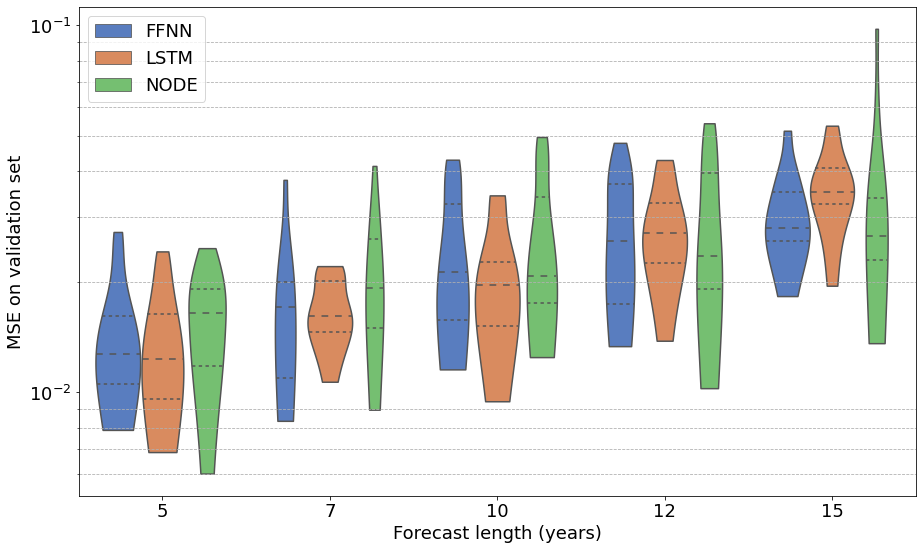

In [ ]:
import seaborn as sns

labels = [model + str(forecast_length) for forecast_length in forecast_lengths for model in ["FFNN", "LSTM", "NODE"] ]
dfs = []

forecast_lengths = [5, 7, 10, 12, 15]

for j, fl in enumerate(forecast_lengths):
  for k, model in enumerate(["FFNN", "LSTM", "NODE"]):
    dfs.append(pd.DataFrame({'MSE on validation set':all_perfs[j,k,:], 'Model':model, 'Forecast length (years)':fl}))

df = pd.concat(dfs)


fig, ax = plt.subplots(figsize=(15,9))
ax = sns.violinplot(data = df, x='Forecast length (years)', y='MSE on validation set', hue='Model', palette="muted", inner="quartiles", cut=0)

plt.grid(b=True, axis='y', which='minor', linestyle='--')
plt.yscale("log")
plt.legend(loc = 'upper left')
fig.savefig("single_all_perfs.png",bbox_inches='tight')

## Several countries

In [ ]:
indicators = ["Population", "GDP per capita", "Energy intensity", "Carbon intensity", "Electricity - fossil fuels", "Electricity - nuclear", "Electricity - renewables"]
pool_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]

models_types = ["FFNN", "LSTM", "NODE"]
countries_samples_sizes = [3, 5, 7]
nb_sampling = 10

train_processes = [FFNN_init_and_train, LSTM_init_and_train, NODE_init_and_train]
forecast_processes = [FFNN_forecast, LSTM_forecast, NODE_forecast]
training_args = [[15, 128, 10000, 0, 0.0006, 0.0001], [32, 3000, 0, 0.0005, 0.0001], [ShallowLinearODEF, 1024, 3000, 0, 5, 0.001, 0]]

# all_perfs = np.zeros((len(models_types), len(comparison_countries)))

perfs = []
total_steps = len(countries_samples_sizes) * nb_sampling


In [ ]:
all_perfs = [[[] for _ in models_types] for _ in countries_samples_sizes]
steps = 0

for s, sample_size in enumerate(countries_samples_sizes):
  for l in range(nb_sampling):
    steps += 1

    comparison_countries = np.random.choice(pool_countries, sample_size, replace=False)
    # print(comparison_countries)

    dataset = load_dataset(comparison_countries, indicators)
    dataset[:,0:4] = normalize_dataset(dataset[:,0:4], min=0, max=1)
    
    for k, model_type in enumerate(models_types):
      print("Step " + str(steps) + " of " + str(total_steps) + " - " + model_type)  

      perf = evaluate_multicountry_performance(dataset, comparison_countries, train_processes[k], forecast_processes[k], training_args[k], plotting=False)
      all_perfs[s][k] += perf

# plot_dataset_and_predictions(training_dataset, validation_dataset)

print("Multicountry over, all_perfs : ")
print(all_perfs)

In [1]:
# 10 SAMPLES
all_perfs = [[[0.08606331050395966, 0.040343351662158966, 0.059558119624853134, 0.10703437775373459, 0.017985831946134567, 0.03348565846681595, 0.0569930262863636, 0.06867504864931107, 0.03529585525393486, 0.08892573416233063, 0.024650216102600098, 0.1053679957985878, 0.04602864384651184, 0.13393893837928772, 0.018629293888807297, 0.02628910355269909, 0.10020127892494202, 0.1172616183757782, 0.0395255982875824, 0.1469012051820755, 0.023549027740955353, 0.07024732977151871, 0.04380038380622864, 0.04135580360889435, 0.0110483942553401, 0.02580077201128006, 0.044856272637844086, 0.05576345697045326, 0.014985019341111183, 0.017276031896471977], [0.057086304282919324, 0.022780409480184876, 0.027857372546602848, 0.02135077902272681, 0.013023222348028633, 0.02187303123073472, 0.03240378437620806, 0.023700834227467268, 0.01682261917949423, 0.027685806149590167, 0.013846270383506123, 0.05549407158274278, 0.03332562286241864, 0.05908182840775673, 0.0166944643756351, 0.024065521816317857, 0.08910268873591126, 0.04444233267232663, 0.04805895919169862, 0.07483460689070125, 0.016213678887860027, 0.0188749761567712, 0.03332217487002117, 0.02405494034225475, 0.014183988300083605, 0.028116166693131023, 0.0319834746210478, 0.030473229732497137, 0.007408775320625582, 0.014117516844518825], [0.059612103, 0.027265731, 0.025616303, 0.0623701, 0.016300818, 0.024112366, 0.050997533, 0.036188867, 0.016240299, 0.07336895, 0.017025214, 0.08731547, 0.031082815, 0.06528918, 0.058360703, 0.051604044, 0.08851426, 0.051992554, 0.02378731, 0.070101544, 0.087784864, 0.044920877, 0.19515608, 0.04060059, 0.013570683, 0.019385759, 0.055681083, 0.014838668, 0.019195782, 0.020829806]], [[0.007464295718818903, 0.031627438962459564, 0.05829392746090889, 0.02686600387096405, 0.03223072364926338, 0.014820198528468609, 0.016732243821024895, 0.02420305460691452, 0.05716216191649437, 0.02459448203444481, 0.04204021021723747, 0.022317418828606606, 0.09704412519931793, 0.04798942804336548, 0.01990930549800396, 0.030543014407157898, 0.09508789330720901, 0.04705563560128212, 0.030684253200888634, 0.032498907297849655, 0.030735906213521957, 0.08005572855472565, 0.018459616228938103, 0.028604522347450256, 0.01933663710951805, 0.04978717118501663, 0.02741486020386219, 0.09875378012657166, 0.020744189620018005, 0.046743061393499374, 0.06812018156051636, 0.19666224718093872, 0.03050740621984005, 0.10915639251470566, 0.019698703661561012, 0.021656211465597153, 0.039958223700523376, 0.021611010655760765, 0.09099957346916199, 0.09697510302066803, 0.05546543002128601, 0.0678781121969223, 0.015625158324837685, 0.02465209737420082, 0.023857196792960167, 0.0992296040058136, 0.024199679493904114, 0.026530910283327103, 0.0717303529381752, 0.04256802424788475], [0.014178549337755688, 0.024039315688864988, 0.05208654874078591, 0.019501105827094602, 0.018579299253013878, 0.006730417280020897, 0.011862339933450932, 0.01320106300812931, 0.01767165870871085, 0.015975420376192748, 0.01864317177602255, 0.017801511012947874, 0.06011388520652314, 0.042442806563565715, 0.015085388811827957, 0.022639564911444202, 0.1189237774639077, 0.01131242282248372, 0.016867067459707116, 0.011599224623388076, 0.015805009932607243, 0.07705718097351998, 0.015286501559782445, 0.030469654582924898, 0.01875394383801128, 0.018811283277460303, 0.016166566606676234, 0.040314798082030444, 0.011403362892717856, 0.013778651802377343, 0.02957892482761024, 0.05145110560193041, 0.00983120316352563, 0.06938799707649229, 0.011360403601324329, 0.00917792701919812, 0.01956245388775349, 0.009881662502412741, 0.06475162568340859, 0.06303190744201174, 0.02232816947805276, 0.04337255522544703, 0.01353988319232661, 0.01375573288482095, 0.011455684383976048, 0.08277268662481294, 0.011516623604671006, 0.011164201586280181, 0.034650873332308506, 0.01431198893086677], [0.03489937, 0.08593966, 0.07344485, 0.02733362, 0.026182977, 0.011329121, 0.019766659, 0.013689452, 0.032341912, 0.011518208, 0.046681408, 0.014040527, 0.07030588, 0.13592343, 0.019167455, 0.03471783, 0.06225151, 0.026014607, 0.021710351, 0.01428187, 0.058674194, 0.091646016, 0.023166595, 0.05929519, 0.015903614, 0.050079204, 0.018153986, 0.07685143, 0.010316722, 0.0440019, 0.055339634, 0.10360582, 0.013333973, 0.07519441, 0.010566362, 0.023354817, 0.02752355, 0.020779299, 0.057295356, 0.07608357, 0.053625103, 0.052855253, 0.026415173, 0.01648619, 0.032078862, 0.042493608, 0.02571214, 0.014954786, 0.072223976, 0.014494937]], [[0.03472384065389633, 0.05081876739859581, 0.052563559263944626, 0.017257919535040855, 0.010829784907400608, 0.09808064997196198, 0.12592776119709015, 0.03420485928654671, 0.08619791269302368, 0.047013040632009506, 0.027887873351573944, 0.007019050884991884, 0.058206286281347275, 0.016688376665115356, 0.025507910177111626, 0.07500641793012619, 0.044833842664957047, 0.009963230229914188, 0.043247904628515244, 0.05606872960925102, 0.007301752455532551, 0.07491203397512436, 0.020572835579514503, 0.045467644929885864, 0.0663561150431633, 0.01461463700979948, 0.04331275820732117, 0.029491957277059555, 0.02149328403174877, 0.019428886473178864, 0.10736926645040512, 0.012759348377585411, 0.01599605567753315, 0.051778942346572876, 0.029973860830068588, 0.0752250924706459, 0.010197312571108341, 0.07572511583566666, 0.04700583219528198, 0.022613173350691795, 0.025229662656784058, 0.040220990777015686, 0.026361454278230667, 0.04097595810890198, 0.011046682484447956, 0.03951149806380272, 0.00639044726267457, 0.05234542116522789, 0.09243500977754593, 0.07078254967927933, 0.060980215668678284, 0.03216518461704254, 0.01424411591142416, 0.028967851772904396, 0.05694838613271713, 0.017938245087862015, 0.015807094052433968, 0.06991759687662125, 0.035793889313936234, 0.021339233964681625, 0.0989721417427063, 0.017927594482898712, 0.01678021252155304, 0.00791152473539114, 0.03879857808351517, 0.06336997449398041, 0.036995530128479004, 0.020552756264805794, 0.019787205383181572, 0.024006307125091553], [0.017747503770009953, 0.013794956901537371, 0.022791817772119628, 0.007314651306517938, 0.009561541630580421, 0.034319105143528865, 0.09009136081638762, 0.031893658653098796, 0.03425790876301584, 0.015040560059269306, 0.011184568371103612, 0.007208442722676892, 0.033175644042013695, 0.020202521748639995, 0.017594807457353805, 0.030602194539095542, 0.02141926459955949, 0.006440578164493856, 0.032699655979930346, 0.0323462249689056, 0.006532839001257722, 0.016646071879793806, 0.008691281942061433, 0.018968337035733602, 0.050176774891895336, 0.007933391889305984, 0.023135644812504078, 0.023619239771491062, 0.012793429198541865, 0.01854428008939572, 0.04595222599386462, 0.00761291576130959, 0.012672398837023383, 0.021306374247520115, 0.02072348702155332, 0.03749279654160285, 0.006577724077058242, 0.021224638528012565, 0.01091931485698075, 0.010034726309474221, 0.018367595852513557, 0.029098136427812577, 0.043162628784384975, 0.019756955308778107, 0.007922526086053679, 0.00774731872224308, 0.006370471819180501, 0.02099392086976974, 0.03587681757583091, 0.024735048567025603, 0.05188517315740121, 0.01921044766699655, 0.009161439021625752, 0.01664072319267691, 0.023626878709506045, 0.011724309105358684, 0.009573120396030636, 0.01974680385711378, 0.028763882787044063, 0.008526933733382215, 0.04902034208263142, 0.011181686081304805, 0.013571544775988547, 0.007379770203195008, 0.02696940087909098, 0.05789658801346096, 0.01221392235739308, 0.013886898617436425, 0.01282789421768856, 0.012947032946794404], [0.03328203, 0.031719882, 0.081734836, 0.012416835, 0.011286362, 0.07862512, 0.08390483, 0.043064702, 0.072004184, 0.043402735, 0.033687532, 0.01767671, 0.06493526, 0.015936138, 0.015496532, 0.060349792, 0.04679338, 0.0096298205, 0.02561514, 0.074676126, 0.019285426, 0.040954404, 0.015498845, 0.04774537, 0.074276194, 0.021243518, 0.04659447, 0.017061431, 0.01337636, 0.013528211, 0.06723756, 0.008218776, 0.029547485, 0.051853493, 0.043483168, 0.079124086, 0.00985583, 0.074824356, 0.030687772, 0.01179816, 0.012569609, 0.03489118, 0.026112396, 0.046389617, 0.0107014775, 0.032651316, 0.013133613, 0.067607746, 0.07032252, 0.046309974, 0.06927844, 0.033773147, 0.014154093, 0.018901708, 0.07393437, 0.02453788, 0.03068393, 0.053527176, 0.08248073, 0.025089497, 0.08530239, 0.014941404, 0.011275429, 0.013754059, 0.047240935, 0.09572084, 0.03743681, 0.016134761, 0.013532962, 0.012711919]]]
# print(len(all_perfs[0][2]))

In [ ]:
# boxplot_data = [all_perfs[s][k] for s in range(len(countries_samples_sizes)) for k in range(len(models_types))]

# positions = [i + j*(len(models_types) + 1) for j in range(len(countries_samples_sizes))for i in range(len(models_types)) ]
# labels = [model + str(sample_size) for sample_size in countries_samples_sizes for model in models_types ]

# fig = plt.figure(figsize=(15,9))
# plt.violinplot(boxplot_data, widths = 0.5, showmedians=True, showextrema=True, positions=positions)
# plt.xticks(positions, labels)
# plt.yscale("log")
# plt.title("MSE on validation set")
# plt.show()

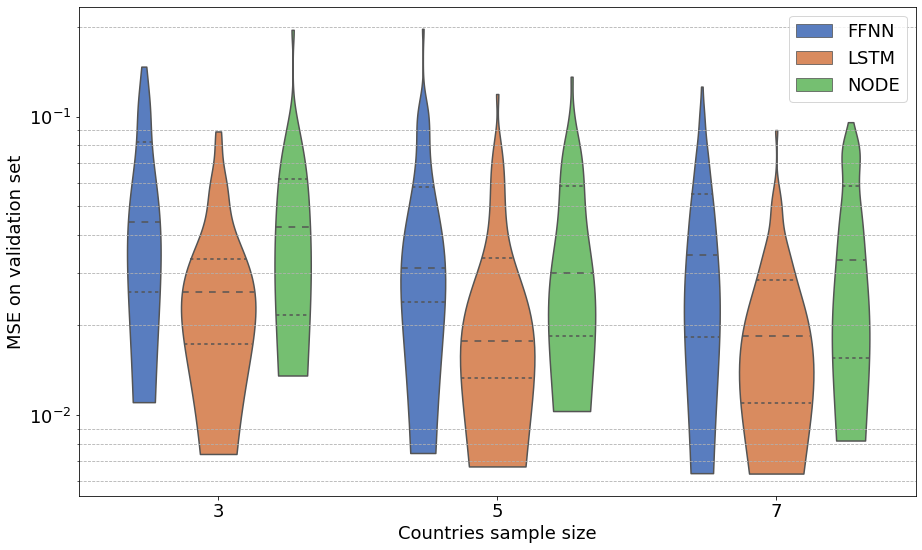

In [ ]:
import seaborn as sns

labels = [model + str(sample_size) for sample_size in countries_samples_sizes for model in models_types ]
dfs = []


for s, size in enumerate(countries_samples_sizes):
  for k, model in enumerate(models_types):
    dfs.append(pd.DataFrame({'MSE on validation set':all_perfs[s][k], 'Model':model, 'Countries sample size':size}))

df = pd.concat(dfs)


fig, ax = plt.subplots(figsize=(15,9))
ax = sns.violinplot(data = df, x='Countries sample size', y='MSE on validation set', hue='Model', palette="muted", inner="quartiles", cut=0)

plt.grid(b=True, axis='y', which='minor', linestyle='--')
plt.yscale("log")
plt.legend(loc = 'upper right')
fig.savefig("multi_all_perfs.png",bbox_inches='tight')

In [ ]:
# comparison_countries = ["France", "Belgium", "Portugal", "Germany", "Italy"]
# models_types = ["FFNN", "LSTM", "NODE"]

# all_perfs = np.array([[0.09162344038486481, 0.040398117154836655, 0.03509489446878433, 0.02543039619922638, 0.10040773451328278], [0.04497796243968802, 0.024576760469420117, 0.028749618177536056, 0.012425697142150327, 0.02081265313222434], [0.06364182382822037, 0.025042079389095306, 0.05034767463803291, 0.013614681549370289, 0.04304253309965134]])
# print(all_perfs)

## Scenario modelling

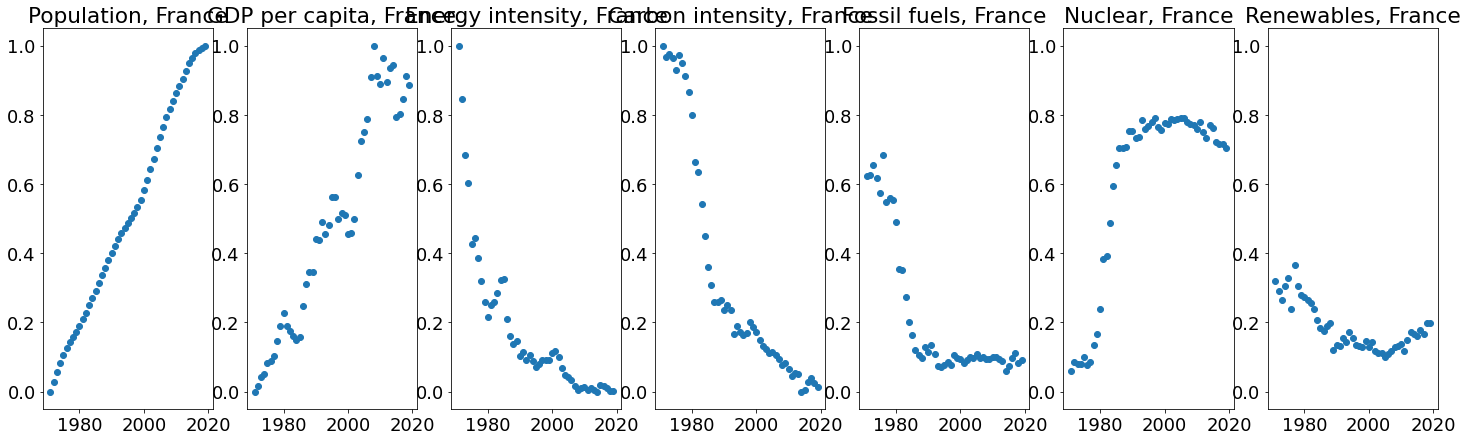

(1, 7, 49)


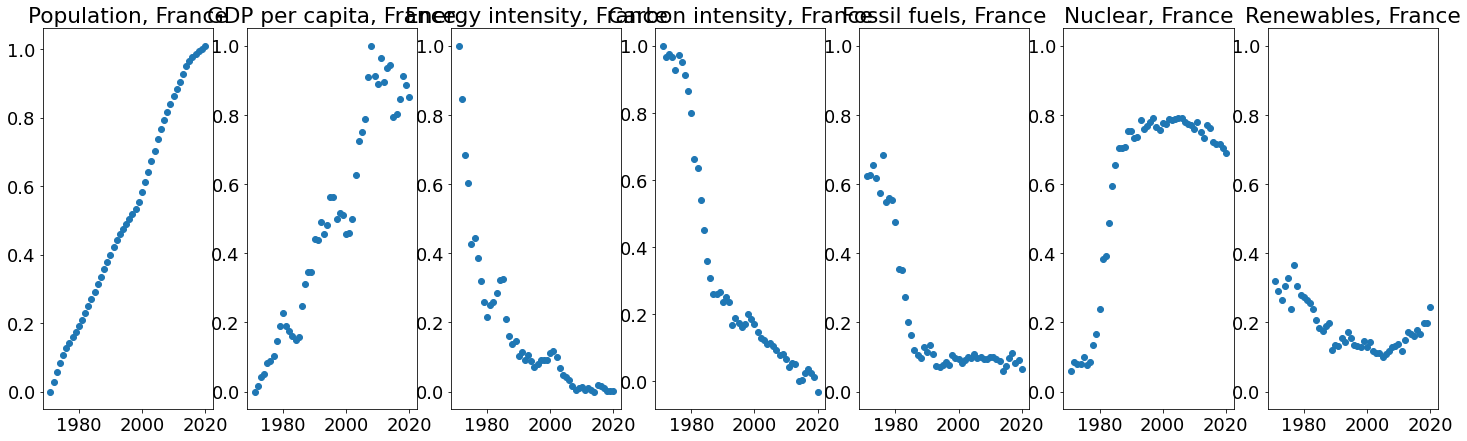

(1, 7, 50)


In [ ]:
indicators = ["Population", "GDP per capita", "Energy intensity", "Carbon intensity", "Fossil fuels", "Nuclear", "Renewables"]
countries = ["France"]

forecast_length = 15
year_skip = 1

scenario_modelling = True


original_dataset = load_dataset(countries, indicators)
scenario_dates = np.arange(original_dataset.shape[2] + year_skip*forecast_length)[::year_skip] + 1971

original_dataset = original_dataset[:,:,::year_skip]
dataset = original_dataset.copy()

# indicators = ["CO2"]
# plot_dataset_and_predictions(np.array([[dataset[0,0] * dataset[0,1] * dataset[0,2] * dataset[0,3]]]))

dataset[:,0:4] = normalize_dataset(dataset[:,0:4], min=0, max=1)

scenario_hypotheses = np.array([1.01, 0.85, 0.002, -0.03, 0.065, 0.69, 0.245], dtype=np.float32)
# scenario_hypotheses = np.array([1.01, 0.75, -0.005, -0.05, 0.39, 0.19, 0.42], dtype=np.float32)
perfs = []

# forecasts_baseline = [_, _, _]
# forecasts_scenario = [_, _, _]


training_dataset = dataset.copy()
plot_dataset_and_predictions(training_dataset)
print(training_dataset.shape)

training_dataset = np.concatenate((training_dataset, np.array(scenario_hypotheses).reshape(1,len(indicators),1)), axis=2)
plot_dataset_and_predictions(training_dataset)
print(training_dataset.shape)


scenario_modelling = False

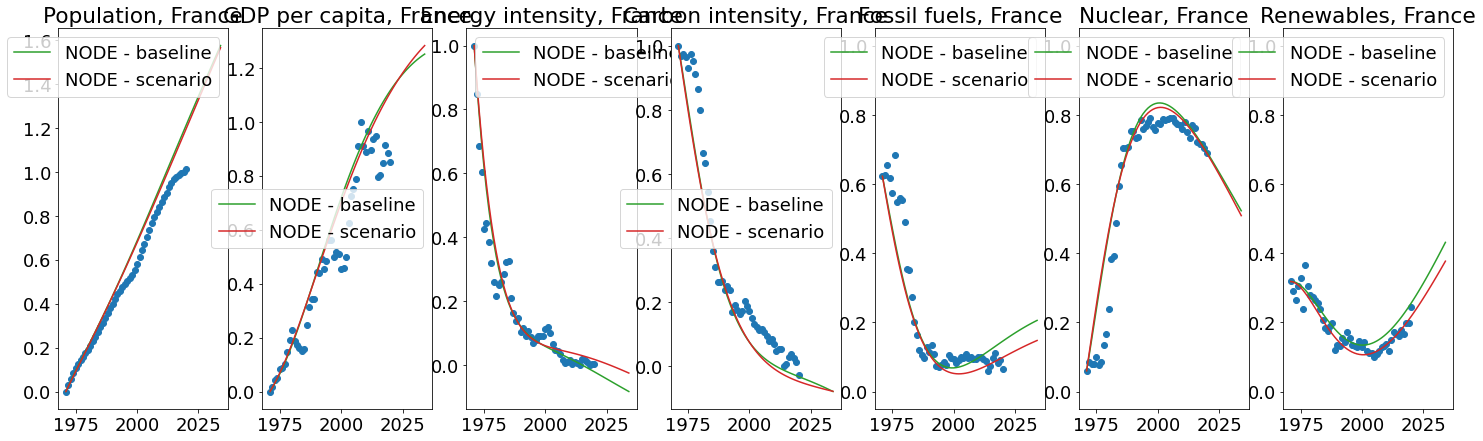

In [ ]:
scenario_modelling = True


models_types = ["FFNN", "LSTM", "NODE"]
train_processes = [FFNN_init_and_train, LSTM_init_and_train, NODE_init_and_train]
forecast_processes = [FFNN_forecast, LSTM_forecast, NODE_forecast]
training_args = [[5, 128, 2000, 0, 0.001, 0.0001], [32, 3000, 0, 0.0005, 0.0001], [ShallowLinearODEF, 1024, 2000, 0, 5, 0.001, 0]]
plotting_time_offsets = [training_args[0][0], 1, 0]


# for k in range(2):
#   forecasts_baseline[k], forecasts_scenario[k] = compare_scenario_forecasts(dataset, forecast_length, scenario_hypotheses, train_processes[k], forecast_processes[k], training_args[k], model_type = models_types[k])

k=2
# print(dataset.shape)
bonus_baseline_2, bonus_scenario_2 = compare_scenario_forecasts(dataset, forecast_length, scenario_hypotheses, train_processes[k], forecast_processes[k], training_args[k], model_type = models_types[k])

scenario_modelling = False

In [ ]:
# save_baseline, save_scenario = forecasts_baseline, forecasts_scenario

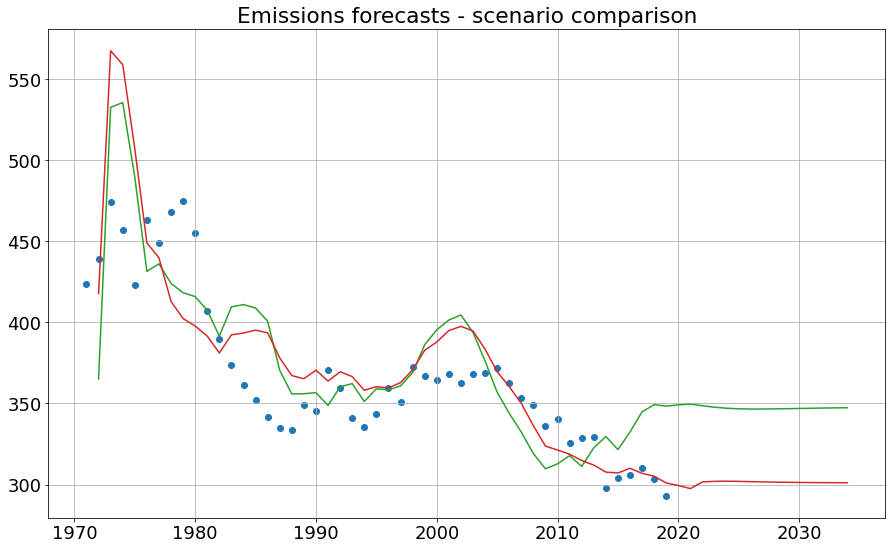

In [ ]:
# k = 2


forecast_baseline, forecast_scenario = forecasts_baseline[k], forecasts_scenario[k]
plotting_time_offset = plotting_time_offsets[k]

# plot_scenario_emissions(original_dataset, year_skip, plotting_time_offset, [forecast_baseline, forecast_scenario])
plot_scenario_emissions(original_dataset, year_skip, plotting_time_offset, [bonus_baseline, bonus_scenario])

In [ ]:
k = 2

forecast_baseline, forecast_scenario = forecasts_baseline[k], forecasts_scenario[k]
plotting_time_offset = plotting_time_offsets[k]

plot_scenario_emissions(original_dataset, year_skip, plotting_time_offset, [forecast_baseline, forecast_scenario])

## Correlated forecasts

In [ ]:
comparison_indicators = ["Population", "GDP per capita", "Energy intensity", "Carbon intensity"]#, "Electricity - fossil fuels", "Electricity - nuclear", "Electricity - renewables"]
comparison_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]
#["France", "Spain", "Italy"]#, "Germany", "United Kingdom", "Italy"]

MSEs_corr = np.zeros((3, 2, len(comparison_countries), len(comparison_indicators)))
forecast_length = 10

models_types = ["FFNN", "LSTM", "NODE"]
train_processes = [FFNN_init_and_train, LSTM_init_and_train, NODE_init_and_train]
forecast_processes = [FFNN_forecast, LSTM_forecast, NODE_forecast]
training_args = [[5, 128, 2000, 0, 0.001, 0.0001], [32, 3000, 0, 0.0005, 0.0001], [ShallowLinearODEF, 1024, 3000, 0, 5, 0.002, 0]]

perfs = []



In [ ]:
# k = 1

for k in [0,1,2]:

  for i, country in enumerate(comparison_countries):
    countries = [country]

    for j, indicator in enumerate(comparison_indicators):
      indicators = [indicator]
      
      MSE = compute_singlecountry_MSE(countries, indicators, forecast_length, train_processes[k], forecast_processes[k], training_args[k])
      MSEs_corr[k, 0, i, j] = np.average(MSE)


    MSE = compute_singlecountry_MSE(countries, indicators, forecast_length, train_processes[k], forecast_processes[k], training_args[k])
    MSEs_corr[k, 1, i, :] = MSE


print(np.ndarray.tolist(MSEs_corr))

In [ ]:
# FORECAST LENGTH 10
# MSEs_corr = np.array([[[[0.0010230854386463761, 0.04459374397993088, 0.00044945237459614873, 0.0024969580117613077], [0.19345024228096008, 0.052903153002262115, 0.0004479957278817892, 0.019528696313500404], [0.07618381083011627, 0.15870051085948944, 0.0003318202216178179, 0.014267573133111]], [[0.004487022757530212, 0.027916451916098595, 0.0044588353484869, 0.0019838439766317606], [0.2070833146572113, 0.43854647874832153, 0.03971249982714653, 0.004543043207377195], [0.06730711460113525, 0.30924344062805176, 0.021254468709230423, 0.021852845326066017]]], [[[0.021954906620520374, 0.11694815665105729, 0.0011694627524318592, 0.0010828520042754993], [0.07352157609308847, 0.25041542398610944, 0.0021203242099638794, 0.08529679104074772], [0.025742606817105697, 0.3104616614984209, 0.0024482848786133715, 0.0997953586157702]], [[0.004232579295861072, 0.04355370137763721, 0.0017908010465309758, 0.0002656530253613195], [0.004745934186738054, 0.09787002852116018, 0.003824236929834473, 0.05500078530327407], [0.00809709882812797, 0.13440574447499642, 0.0013374245767012614, 0.027197700381282157]]], [[[0.004677062388509512, 0.07496026158332825, 0.0017961555859073997, 0.0005873215268366039], [0.009632661938667297, 0.11691640317440033, 0.0024941100273281336, 0.07868551462888718], [0.05855822563171387, 0.14065027236938477, 0.0001816627336665988, 0.01934155821800232]], [[0.017709288746118546, 0.08553365617990494, 0.003392703365534544, 0.001353842788375914], [0.02667776308953762, 0.0895809456706047, 0.009476768784224987, 0.04755184054374695], [0.010798786766827106, 0.12360956519842148, 0.00023561557463835925, 0.014300244860351086]]]])

In [ ]:
# FORECAST LENGTH 5
# comparison_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]

MSEs_corr = np.array([[[[0.0015677580377086997, 0.025432229042053223, 0.0039770291186869144, 0.0114865992218256], [0.035894930362701416, 0.08040542900562286, 0.0037118163891136646, 0.04539614915847778], [0.002230596262961626, 0.04180290177464485, 0.002025422640144825, 0.006638580467551947], [0.0012263009557500482, 0.022072385996580124, 1.2636495739570819e-05, 0.040745437145233154], [0.008241240866482258, 0.042630039155483246, 0.001368528581224382, 0.0033633082639425993], [0.031283535063266754, 0.01954968087375164, 0.0007871632697060704, 0.059584181755781174], [0.005404411815106869, 0.059761930257081985, 1.6946738469414413e-05, 0.022259455174207687], [0.007291929330676794, 0.07329870015382767, 0.0025270027108490467, 0.07508586347103119], [0.0005400998634286225, 0.031427644193172455, 0.0012047088239341974, 0.01612621173262596], [0.0020108637399971485, 0.085757315158844, 0.0023752115666866302, 0.011606575921177864], [0.003968661185353994, 0.07048923522233963, 0.0027410348411649466, 0.002135970164090395], [0.004972320515662432, 0.054433953016996384, 0.002881512511521578, 0.006469067186117172]], [[0.01102428324520588, 0.01102428324520588, 0.01102428324520588, 0.01102428324520588], [0.03530489280819893, 0.03530489280819893, 0.03530489280819893, 0.03530489280819893], [0.00527308601886034, 0.00527308601886034, 0.00527308601886034, 0.00527308601886034], [0.04673326015472412, 0.04673326015472412, 0.04673326015472412, 0.04673326015472412], [0.003513652365654707, 0.003513652365654707, 0.003513652365654707, 0.003513652365654707], [0.05822119861841202, 0.05822119861841202, 0.05822119861841202, 0.05822119861841202], [0.02059199847280979, 0.02059199847280979, 0.02059199847280979, 0.02059199847280979], [0.08956986665725708, 0.08956986665725708, 0.08956986665725708, 0.08956986665725708], [0.013816013932228088, 0.013816013932228088, 0.013816013932228088, 0.013816013932228088], [0.011406878009438515, 0.011406878009438515, 0.011406878009438515, 0.011406878009438515], [0.0024139699526131153, 0.0024139699526131153, 0.0024139699526131153, 0.0024139699526131153], [0.003150228876620531, 0.003150228876620531, 0.003150228876620531, 0.003150228876620531]]], [[[0.00423406329220839, 0.011998948115955699, 5.296220770782821e-05, 0.060189109880764466], [0.0059291716889205755, 0.03453106617454367, 0.0001499882745881391, 0.0014533420956492683], [8.590947667102e-05, 0.03195535850714961, 7.890665205466942e-05, 0.0007088429216253741], [6.496937484641307e-05, 0.007491857079641307, 0.0001165554391054638, 0.10522850446501461], [0.17760389803640422, 0.03247232852230155, 0.00032030427582510867, 0.003966393460074635], [0.02371613378740136, 0.012974751822917342, 0.0001650099901631734, 0.0322619355562652], [0.008751968604018856, 0.08809644376438897, 8.833305893773793e-05, 0.009137218613952535], [0.024482575983689258, 0.0069590076788109915, 0.0022833219553306363, 0.0616808683575004], [0.011151902789919177, 0.02465425818264606, 2.273032306514218e-05, 0.0229333981182951], [0.0027520811801345245, 0.08532384908181498, 0.002880312322553657, 0.020528320574276337], [0.002243227946092219, 0.048847784454055444, 0.0003629699629072674, 0.000672979606303264], [0.0032228298787771335, 0.01043403410222581, 0.0010662694163577698, 0.0005575933606306538]], [[0.05486027061034615, 0.05486027061034615, 0.05486027061034615, 0.05486027061034615], [0.000626050007227763, 0.000626050007227763, 0.000626050007227763, 0.000626050007227763], [0.00020010875871212633, 0.00020010875871212633, 0.00020010875871212633, 0.00020010875871212633], [0.09772679480002142, 0.09772679480002142, 0.09772679480002142, 0.09772679480002142], [0.0033887407319189156, 0.0033887407319189156, 0.0033887407319189156, 0.0033887407319189156], [0.029257279534333512, 0.029257279534333512, 0.029257279534333512, 0.029257279534333512], [0.010632568655475839, 0.010632568655475839, 0.010632568655475839, 0.010632568655475839], [0.07893752022766969, 0.07893752022766969, 0.07893752022766969, 0.07893752022766969], [0.004137315396439034, 0.004137315396439034, 0.004137315396439034, 0.004137315396439034], [0.024306817049586947, 0.024306817049586947, 0.024306817049586947, 0.024306817049586947], [0.0009967517525030483, 0.0009967517525030483, 0.0009967517525030483, 0.0009967517525030483], [0.0005556833416885121, 0.0005556833416885121, 0.0005556833416885121, 0.0005556833416885121]]], [[[0.02657090686261654, 0.10433745384216309, 0.003035841044038534, 0.011528564617037773], [0.009152301587164402, 0.1483529806137085, 0.0016023641219362617, 0.004351289011538029], [0.014807884581387043, 0.09038467705249786, 0.0029319545719772577, 0.00924320425838232], [0.00186050939373672, 0.08774576336145401, 0.0015868262853473425, 0.0637110248208046], [0.021925590932369232, 0.05776631087064743, 0.0019079037010669708, 0.0059168231673538685], [0.056450724601745605, 0.1311074048280716, 0.005130444653332233, 0.09570139646530151], [0.0018303937977179885, 0.0041500600054860115, 0.0013504027156159282, 0.011688660830259323], [0.1365823596715927, 0.20282387733459473, 0.01188569888472557, 0.02786794863641262], [0.00931546650826931, 0.08293505758047104, 0.0013828298542648554, 0.0011654389090836048], [0.00015872978838160634, 0.2723693251609802, 0.002385935513302684, 0.012797793373465538], [0.02186250500380993, 0.06839266419410706, 0.004505757242441177, 0.0010655195219442248], [0.008497694507241249, 0.0981956422328949, 0.0013808747753500938, 0.018782658502459526]], [[0.006126738153398037, 0.006126738153398037, 0.006126738153398037, 0.006126738153398037], [0.013968032784759998, 0.013968032784759998, 0.013968032784759998, 0.013968032784759998], [0.00032558460952714086, 0.00032558460952714086, 0.00032558460952714086, 0.00032558460952714086], [0.0808640867471695, 0.0808640867471695, 0.0808640867471695, 0.0808640867471695], [0.011518428102135658, 0.011518428102135658, 0.011518428102135658, 0.011518428102135658], [0.1918906718492508, 0.1918906718492508, 0.1918906718492508, 0.1918906718492508], [0.005839814431965351, 0.005839814431965351, 0.005839814431965351, 0.005839814431965351], [0.04326799511909485, 0.04326799511909485, 0.04326799511909485, 0.04326799511909485], [0.002513051265850663, 0.002513051265850663, 0.002513051265850663, 0.002513051265850663], [0.013373169116675854, 0.013373169116675854, 0.013373169116675854, 0.013373169116675854], [0.0009465313632972538, 0.0009465313632972538, 0.0009465313632972538, 0.0009465313632972538], [0.015001353807747364, 0.015001353807747364, 0.015001353807747364, 0.015001353807747364]]]])


(3, 2, 12, 4)


In [ ]:
# FORECAST LENGTH 10
# comparison_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]

MSEs_corr = np.array([[[[0.16236445307731628, 0.09442345798015594, 0.0012226712424308062, 0.015192532911896706], [0.08078667521476746, 0.06487268209457397, 0.00010059077612822875, 0.03507193177938461], [0.012835684232413769, 0.040648847818374634, 0.0006644958048127592, 0.000575212063267827], [0.03572820872068405, 0.016209883615374565, 0.0006873304373584688, 0.017064090818166733], [0.027781661599874496, 0.0035912208259105682, 0.001646665157750249, 0.005177355837076902], [0.064104825258255, 0.15305155515670776, 0.0037438564468175173, 0.20452573895454407], [0.0680963397026062, 0.025981198996305466, 5.01615104440134e-05, 0.12015783786773682], [0.009551926515996456, 0.4222681522369385, 0.0003630926366895437, 0.226627916097641], [0.025017285719513893, 0.06638239324092865, 0.0007547284476459026, 0.0748487263917923], [0.0007112830644473433, 0.11226502805948257, 0.004058998078107834, 0.024083886295557022], [0.03992844372987747, 0.014815500006079674, 0.0011390381259843707, 0.0005865682614967227], [0.0018786527216434479, 0.06433559954166412, 0.020487457513809204, 0.0275884922593832]], [[0.009466131217777729, 0.009466131217777729, 0.009466131217777729, 0.009466131217777729], [0.0387529693543911, 0.0387529693543911, 0.0387529693543911, 0.0387529693543911], [0.002406798303127289, 0.002406798303127289, 0.002406798303127289, 0.002406798303127289], [0.017230156809091568, 0.017230156809091568, 0.017230156809091568, 0.017230156809091568], [0.005212020128965378, 0.005212020128965378, 0.005212020128965378, 0.005212020128965378], [0.20660698413848877, 0.20660698413848877, 0.20660698413848877, 0.20660698413848877], [0.12229949235916138, 0.12229949235916138, 0.12229949235916138, 0.12229949235916138], [0.22078242897987366, 0.22078242897987366, 0.22078242897987366, 0.22078242897987366], [0.07336865365505219, 0.07336865365505219, 0.07336865365505219, 0.07336865365505219], [0.021484406664967537, 0.021484406664967537, 0.021484406664967537, 0.021484406664967537], [0.00039880219264887273, 0.00039880219264887273, 0.00039880219264887273, 0.00039880219264887273], [0.02920239046216011, 0.02920239046216011, 0.02920239046216011, 0.02920239046216011]]], [[[0.03669800598851225, 0.35496584340292114, 0.002121192107389767, 0.08325957137371545], [0.003891442667211464, 0.1824121408423874, 0.002803890906415446, 0.07468654199708069], [0.0006838464799937327, 0.3062783050632792, 0.001634610119207082, 0.007978657636116425], [0.02506138283336732, 0.06020328108160591, 0.0002829860782833562, 0.08631982620871319], [0.05864901942247904, 0.006613225248547039, 0.0005936657981508614, 0.00569575854945314], [0.013598212890136097, 0.3808159832817804, 0.005242331284212724, 0.21643389056409257], [0.012557071402796893, 0.02627748224192956, 0.00010451305020064906, 0.1530937821556519], [0.014323992451772582, 0.4701656308214595, 0.0006391585384081286, 0.14518757230105478], [0.030182841503764733, 0.20725878675554732, 0.0010367771191410284, 0.06949781765050138], [0.0006309588569489933, 0.14494039938749345, 0.0002976157816726685, 0.02478802480710445], [0.052604078744885284, 0.06897573575877444, 0.0030311392347061633, 0.025079634707320598], [0.015405633596506263, 0.2624713059809928, 0.0026795175696516416, 0.08079479242645046]], [[0.08909983721219865, 0.08909983721219865, 0.08909983721219865, 0.08909983721219865], [0.07014589856783353, 0.07014589856783353, 0.07014589856783353, 0.07014589856783353], [0.004743048269259263, 0.004743048269259263, 0.004743048269259263, 0.004743048269259263], [0.0906840725442922, 0.0906840725442922, 0.0906840725442922, 0.0906840725442922], [0.006586400456808328, 0.006586400456808328, 0.006586400456808328, 0.006586400456808328], [0.21295404008315644, 0.21295404008315644, 0.21295404008315644, 0.21295404008315644], [0.14890906976956375, 0.14890906976956375, 0.14890906976956375, 0.14890906976956375], [0.1387977814403825, 0.1387977814403825, 0.1387977814403825, 0.1387977814403825], [0.07584500945542894, 0.07584500945542894, 0.07584500945542894, 0.07584500945542894], [0.02755401853463622, 0.02755401853463622, 0.02755401853463622, 0.02755401853463622], [0.0037088399380610535, 0.0037088399380610535, 0.0037088399380610535, 0.0037088399380610535], [0.06499385713712014, 0.06499385713712014, 0.06499385713712014, 0.06499385713712014]]], [[[0.01605881378054619, 0.21192780137062073, 0.0025860776659101248, 0.06121022626757622], [0.05801140516996384, 0.1145574226975441, 0.00158568168990314, 0.027107739821076393], [0.008395785465836525, 0.051682304590940475, 0.001383114606142044, 0.0005035162903368473], [0.017633110284805298, 0.18826699256896973, 0.0011241886531934142, 0.04474834352731705], [0.3836258053779602, 0.009476433508098125, 0.003550440538674593, 0.04496651142835617], [0.04448392242193222, 0.12761957943439484, 0.006743146572262049, 0.05683749169111252], [0.0014253138797357678, 0.115354523062706, 0.005253608338534832, 0.15120065212249756], [0.12428657710552216, 0.27908384799957275, 0.011217096820473671, 0.1328258514404297], [0.012933865189552307, 0.06052004173398018, 0.0026302530895918608, 0.0372781939804554], [0.022554542869329453, 0.10400469601154327, 0.0017637312412261963, 0.013738567009568214], [0.030440527945756912, 0.014815891161561012, 0.0027857976965606213, 0.004341877065598965], [0.0025396556593477726, 0.0684281438589096, 0.0010364153422415257, 0.03337826579809189]], [[0.03828653693199158, 0.03828653693199158, 0.03828653693199158, 0.03828653693199158], [0.011236682534217834, 0.011236682534217834, 0.011236682534217834, 0.011236682534217834], [0.00245436979457736, 0.00245436979457736, 0.00245436979457736, 0.00245436979457736], [0.026071107015013695, 0.026071107015013695, 0.026071107015013695, 0.026071107015013695], [0.07190088927745819, 0.07190088927745819, 0.07190088927745819, 0.07190088927745819], [0.06383523344993591, 0.06383523344993591, 0.06383523344993591, 0.06383523344993591], [0.11418627202510834, 0.11418627202510834, 0.11418627202510834, 0.11418627202510834], [0.06463464349508286, 0.06463464349508286, 0.06463464349508286, 0.06463464349508286], [0.04065566509962082, 0.04065566509962082, 0.04065566509962082, 0.04065566509962082], [0.015913089737296104, 0.015913089737296104, 0.015913089737296104, 0.015913089737296104], [0.0031494616996496916, 0.0031494616996496916, 0.0031494616996496916, 0.0031494616996496916], [0.05016488954424858, 0.05016488954424858, 0.05016488954424858, 0.05016488954424858]]]])


In [ ]:
# FORECAST LENGTH 15
# comparison_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]

MSEs_corr = np.array([[[[0.07588837295770645, 0.07601498067378998, 0.002774100285023451, 0.00418342649936676], [0.15158240497112274, 0.1277420073747635, 0.0045550549402832985, 0.011985921300947666], [0.0024561076425015926, 0.1397232562303543, 0.0019982270896434784, 0.007241532672196627], [0.06802346557378769, 0.026042675599455833, 0.0005061976844444871, 0.024300163611769676], [0.05870911106467247, 0.16744789481163025, 6.706311978632584e-05, 0.0054099238477647305], [0.004484196659177542, 0.07433202117681503, 0.0016938175540417433, 0.20360711216926575], [0.052460748702287674, 0.32351356744766235, 0.0015185686061158776, 0.0937262699007988], [0.027681346982717514, 0.05871892347931862, 0.002246327931061387, 0.21770192682743073], [0.006798534654080868, 0.12567536532878876, 0.0011145219905301929, 0.16407346725463867], [0.03501171991229057, 0.05993206799030304, 0.005586562678217888, 0.03194050118327141], [0.10155267268419266, 0.17039917409420013, 0.003042456228286028, 0.02103067748248577], [0.04599125683307648, 0.13542519509792328, 0.005379393696784973, 0.07375721633434296]], [[0.009210457094013691, 0.009210457094013691, 0.009210457094013691, 0.009210457094013691], [0.013636204414069653, 0.013636204414069653, 0.013636204414069653, 0.013636204414069653], [0.008657614700496197, 0.008657614700496197, 0.008657614700496197, 0.008657614700496197], [0.016989147290587425, 0.016989147290587425, 0.016989147290587425, 0.016989147290587425], [0.004694296512752771, 0.004694296512752771, 0.004694296512752771, 0.004694296512752771], [0.2019365429878235, 0.2019365429878235, 0.2019365429878235, 0.2019365429878235], [0.0744515135884285, 0.0744515135884285, 0.0744515135884285, 0.0744515135884285], [0.21611446142196655, 0.21611446142196655, 0.21611446142196655, 0.21611446142196655], [0.16677626967430115, 0.16677626967430115, 0.16677626967430115, 0.16677626967430115], [0.030783681198954582, 0.030783681198954582, 0.030783681198954582, 0.030783681198954582], [0.027730923146009445, 0.027730923146009445, 0.027730923146009445, 0.027730923146009445], [0.06800448149442673, 0.06800448149442673, 0.06800448149442673, 0.06800448149442673]]], [[[0.0036243057397975066, 0.07941021462776068, 0.0043528526538225915, 0.07697615673743922], [0.12007141018172855, 0.09620868043713836, 0.002609589764232537, 0.10121257028163018], [0.0012917622180400675, 0.09542667266892953, 0.0026224269421964486, 0.01450761442447254], [0.04719380054182552, 0.01877300373107123, 0.0003824785395008147, 0.09352905136014623], [0.04829970983113488, 0.11241833745171945, 0.0005762055243307974, 0.0023291595660045314], [0.005370853275660181, 0.09899371782840731, 0.011750306233482742, 0.17198371041346336], [0.006105245030868882, 0.5296408400558171, 0.0010391521775074638, 0.1383760271580058], [0.010976923586246082, 0.048339161323899066, 0.008762162348838068, 0.12006576439144451], [0.05643329671632339, 0.12618204066784836, 0.0012695274701045275, 0.15932624371579454], [0.06667539648786219, 0.05362073882233608, 0.003521998542770192, 0.04056654377524662], [0.11455827723089189, 0.12672914067649851, 0.0067957118520053875, 0.03471769973628548], [0.04268039690295164, 0.11395474472290275, 0.004722353771291887, 0.1060782149617557]], [[0.06911585998150269, 0.06911585998150269, 0.06911585998150269, 0.06911585998150269], [0.09870036770042469, 0.09870036770042469, 0.09870036770042469, 0.09870036770042469], [0.017170624196521055, 0.017170624196521055, 0.017170624196521055, 0.017170624196521055], [0.10307176784933349, 0.10307176784933349, 0.10307176784933349, 0.10307176784933349], [0.0025143381837045196, 0.0025143381837045196, 0.0025143381837045196, 0.0025143381837045196], [0.1709427070146117, 0.1709427070146117, 0.1709427070146117, 0.1709427070146117], [0.09647762150770454, 0.09647762150770454, 0.09647762150770454, 0.09647762150770454], [0.11870107279830064, 0.11870107279830064, 0.11870107279830064, 0.11870107279830064], [0.14959876254205942, 0.14959876254205942, 0.14959876254205942, 0.14959876254205942], [0.039945151140958535, 0.039945151140958535, 0.039945151140958535, 0.039945151140958535], [0.032728216480309776, 0.032728216480309776, 0.032728216480309776, 0.032728216480309776], [0.11207726725784012, 0.11207726725784012, 0.11207726725784012, 0.11207726725784012]]], [[[0.04368331655859947, 0.024352669715881348, 0.0010648769093677402, 0.058144327253103256], [0.08897341787815094, 0.017758818343281746, 0.0010174054186791182, 0.02988346293568611], [0.0003588192048482597, 0.013901962898671627, 0.0005373730091378093, 0.002112601650878787], [0.05339902266860008, 0.037681978195905685, 0.0010186941362917423, 0.026665091514587402], [0.5191863775253296, 0.006534953135997057, 0.0051617431454360485, 0.05265207961201668], [0.029289165511727333, 0.01574063114821911, 0.0034855848643928766, 0.17395764589309692], [0.05050217732787132, 0.010505002923309803, 0.002696157433092594, 0.0769713744521141], [0.1229565218091011, 0.0501958504319191, 0.003153323894366622, 0.09754718840122223], [0.01369241438806057, 0.015199144370853901, 0.0021617242600768805, 0.047576189041137695], [0.032536812126636505, 0.060418590903282166, 0.0007300584693439305, 0.04131995141506195], [0.025816241279244423, 0.019684452563524246, 0.0021818808745592833, 0.010672126896679401], [0.0045714592561125755, 0.020502617582678795, 0.0004116040945518762, 0.06262265890836716]], [[0.05570841580629349, 0.05570841580629349, 0.05570841580629349, 0.05570841580629349], [0.033595118671655655, 0.033595118671655655, 0.033595118671655655, 0.033595118671655655], [0.0009792662458494306, 0.0009792662458494306, 0.0009792662458494306, 0.0009792662458494306], [0.018838489428162575, 0.018838489428162575, 0.018838489428162575, 0.018838489428162575], [0.04711895436048508, 0.04711895436048508, 0.04711895436048508, 0.04711895436048508], [0.19041840732097626, 0.19041840732097626, 0.19041840732097626, 0.19041840732097626], [0.06181890517473221, 0.06181890517473221, 0.06181890517473221, 0.06181890517473221], [0.20121628046035767, 0.20121628046035767, 0.20121628046035767, 0.20121628046035767], [0.04271639883518219, 0.04271639883518219, 0.04271639883518219, 0.04271639883518219], [0.042247869074344635, 0.042247869074344635, 0.042247869074344635, 0.042247869074344635], [0.017164332792162895, 0.017164332792162895, 0.017164332792162895, 0.017164332792162895], [0.0603124275803566, 0.0603124275803566, 0.0603124275803566, 0.0603124275803566]]]])

In [ ]:
# FORECAST LENGTHS 5 10 15
MSEs_corr = np.zeros((3,3,2,12,4))
MSEs_corr[0] = np.array([[[[0.0015677580377086997, 0.025432229042053223, 0.0039770291186869144, 0.0114865992218256], [0.035894930362701416, 0.08040542900562286, 0.0037118163891136646, 0.04539614915847778], [0.002230596262961626, 0.04180290177464485, 0.002025422640144825, 0.006638580467551947], [0.0012263009557500482, 0.022072385996580124, 1.2636495739570819e-05, 0.040745437145233154], [0.008241240866482258, 0.042630039155483246, 0.001368528581224382, 0.0033633082639425993], [0.031283535063266754, 0.01954968087375164, 0.0007871632697060704, 0.059584181755781174], [0.005404411815106869, 0.059761930257081985, 1.6946738469414413e-05, 0.022259455174207687], [0.007291929330676794, 0.07329870015382767, 0.0025270027108490467, 0.07508586347103119], [0.0005400998634286225, 0.031427644193172455, 0.0012047088239341974, 0.01612621173262596], [0.0020108637399971485, 0.085757315158844, 0.0023752115666866302, 0.011606575921177864], [0.003968661185353994, 0.07048923522233963, 0.0027410348411649466, 0.002135970164090395], [0.004972320515662432, 0.054433953016996384, 0.002881512511521578, 0.006469067186117172]], [[0.01102428324520588, 0.01102428324520588, 0.01102428324520588, 0.01102428324520588], [0.03530489280819893, 0.03530489280819893, 0.03530489280819893, 0.03530489280819893], [0.00527308601886034, 0.00527308601886034, 0.00527308601886034, 0.00527308601886034], [0.04673326015472412, 0.04673326015472412, 0.04673326015472412, 0.04673326015472412], [0.003513652365654707, 0.003513652365654707, 0.003513652365654707, 0.003513652365654707], [0.05822119861841202, 0.05822119861841202, 0.05822119861841202, 0.05822119861841202], [0.02059199847280979, 0.02059199847280979, 0.02059199847280979, 0.02059199847280979], [0.08956986665725708, 0.08956986665725708, 0.08956986665725708, 0.08956986665725708], [0.013816013932228088, 0.013816013932228088, 0.013816013932228088, 0.013816013932228088], [0.011406878009438515, 0.011406878009438515, 0.011406878009438515, 0.011406878009438515], [0.0024139699526131153, 0.0024139699526131153, 0.0024139699526131153, 0.0024139699526131153], [0.003150228876620531, 0.003150228876620531, 0.003150228876620531, 0.003150228876620531]]], [[[0.00423406329220839, 0.011998948115955699, 5.296220770782821e-05, 0.060189109880764466], [0.0059291716889205755, 0.03453106617454367, 0.0001499882745881391, 0.0014533420956492683], [8.590947667102e-05, 0.03195535850714961, 7.890665205466942e-05, 0.0007088429216253741], [6.496937484641307e-05, 0.007491857079641307, 0.0001165554391054638, 0.10522850446501461], [0.17760389803640422, 0.03247232852230155, 0.00032030427582510867, 0.003966393460074635], [0.02371613378740136, 0.012974751822917342, 0.0001650099901631734, 0.0322619355562652], [0.008751968604018856, 0.08809644376438897, 8.833305893773793e-05, 0.009137218613952535], [0.024482575983689258, 0.0069590076788109915, 0.0022833219553306363, 0.0616808683575004], [0.011151902789919177, 0.02465425818264606, 2.273032306514218e-05, 0.0229333981182951], [0.0027520811801345245, 0.08532384908181498, 0.002880312322553657, 0.020528320574276337], [0.002243227946092219, 0.048847784454055444, 0.0003629699629072674, 0.000672979606303264], [0.0032228298787771335, 0.01043403410222581, 0.0010662694163577698, 0.0005575933606306538]], [[0.05486027061034615, 0.05486027061034615, 0.05486027061034615, 0.05486027061034615], [0.000626050007227763, 0.000626050007227763, 0.000626050007227763, 0.000626050007227763], [0.00020010875871212633, 0.00020010875871212633, 0.00020010875871212633, 0.00020010875871212633], [0.09772679480002142, 0.09772679480002142, 0.09772679480002142, 0.09772679480002142], [0.0033887407319189156, 0.0033887407319189156, 0.0033887407319189156, 0.0033887407319189156], [0.029257279534333512, 0.029257279534333512, 0.029257279534333512, 0.029257279534333512], [0.010632568655475839, 0.010632568655475839, 0.010632568655475839, 0.010632568655475839], [0.07893752022766969, 0.07893752022766969, 0.07893752022766969, 0.07893752022766969], [0.004137315396439034, 0.004137315396439034, 0.004137315396439034, 0.004137315396439034], [0.024306817049586947, 0.024306817049586947, 0.024306817049586947, 0.024306817049586947], [0.0009967517525030483, 0.0009967517525030483, 0.0009967517525030483, 0.0009967517525030483], [0.0005556833416885121, 0.0005556833416885121, 0.0005556833416885121, 0.0005556833416885121]]], [[[0.02657090686261654, 0.10433745384216309, 0.003035841044038534, 0.011528564617037773], [0.009152301587164402, 0.1483529806137085, 0.0016023641219362617, 0.004351289011538029], [0.014807884581387043, 0.09038467705249786, 0.0029319545719772577, 0.00924320425838232], [0.00186050939373672, 0.08774576336145401, 0.0015868262853473425, 0.0637110248208046], [0.021925590932369232, 0.05776631087064743, 0.0019079037010669708, 0.0059168231673538685], [0.056450724601745605, 0.1311074048280716, 0.005130444653332233, 0.09570139646530151], [0.0018303937977179885, 0.0041500600054860115, 0.0013504027156159282, 0.011688660830259323], [0.1365823596715927, 0.20282387733459473, 0.01188569888472557, 0.02786794863641262], [0.00931546650826931, 0.08293505758047104, 0.0013828298542648554, 0.0011654389090836048], [0.00015872978838160634, 0.2723693251609802, 0.002385935513302684, 0.012797793373465538], [0.02186250500380993, 0.06839266419410706, 0.004505757242441177, 0.0010655195219442248], [0.008497694507241249, 0.0981956422328949, 0.0013808747753500938, 0.018782658502459526]], [[0.006126738153398037, 0.006126738153398037, 0.006126738153398037, 0.006126738153398037], [0.013968032784759998, 0.013968032784759998, 0.013968032784759998, 0.013968032784759998], [0.00032558460952714086, 0.00032558460952714086, 0.00032558460952714086, 0.00032558460952714086], [0.0808640867471695, 0.0808640867471695, 0.0808640867471695, 0.0808640867471695], [0.011518428102135658, 0.011518428102135658, 0.011518428102135658, 0.011518428102135658], [0.1918906718492508, 0.1918906718492508, 0.1918906718492508, 0.1918906718492508], [0.005839814431965351, 0.005839814431965351, 0.005839814431965351, 0.005839814431965351], [0.04326799511909485, 0.04326799511909485, 0.04326799511909485, 0.04326799511909485], [0.002513051265850663, 0.002513051265850663, 0.002513051265850663, 0.002513051265850663], [0.013373169116675854, 0.013373169116675854, 0.013373169116675854, 0.013373169116675854], [0.0009465313632972538, 0.0009465313632972538, 0.0009465313632972538, 0.0009465313632972538], [0.015001353807747364, 0.015001353807747364, 0.015001353807747364, 0.015001353807747364]]]])
MSEs_corr[1] = np.array([[[[0.16236445307731628, 0.09442345798015594, 0.0012226712424308062, 0.015192532911896706], [0.08078667521476746, 0.06487268209457397, 0.00010059077612822875, 0.03507193177938461], [0.012835684232413769, 0.040648847818374634, 0.0006644958048127592, 0.000575212063267827], [0.03572820872068405, 0.016209883615374565, 0.0006873304373584688, 0.017064090818166733], [0.027781661599874496, 0.0035912208259105682, 0.001646665157750249, 0.005177355837076902], [0.064104825258255, 0.15305155515670776, 0.0037438564468175173, 0.20452573895454407], [0.0680963397026062, 0.025981198996305466, 5.01615104440134e-05, 0.12015783786773682], [0.009551926515996456, 0.4222681522369385, 0.0003630926366895437, 0.226627916097641], [0.025017285719513893, 0.06638239324092865, 0.0007547284476459026, 0.0748487263917923], [0.0007112830644473433, 0.11226502805948257, 0.004058998078107834, 0.024083886295557022], [0.03992844372987747, 0.014815500006079674, 0.0011390381259843707, 0.0005865682614967227], [0.0018786527216434479, 0.06433559954166412, 0.020487457513809204, 0.0275884922593832]], [[0.009466131217777729, 0.009466131217777729, 0.009466131217777729, 0.009466131217777729], [0.0387529693543911, 0.0387529693543911, 0.0387529693543911, 0.0387529693543911], [0.002406798303127289, 0.002406798303127289, 0.002406798303127289, 0.002406798303127289], [0.017230156809091568, 0.017230156809091568, 0.017230156809091568, 0.017230156809091568], [0.005212020128965378, 0.005212020128965378, 0.005212020128965378, 0.005212020128965378], [0.20660698413848877, 0.20660698413848877, 0.20660698413848877, 0.20660698413848877], [0.12229949235916138, 0.12229949235916138, 0.12229949235916138, 0.12229949235916138], [0.22078242897987366, 0.22078242897987366, 0.22078242897987366, 0.22078242897987366], [0.07336865365505219, 0.07336865365505219, 0.07336865365505219, 0.07336865365505219], [0.021484406664967537, 0.021484406664967537, 0.021484406664967537, 0.021484406664967537], [0.00039880219264887273, 0.00039880219264887273, 0.00039880219264887273, 0.00039880219264887273], [0.02920239046216011, 0.02920239046216011, 0.02920239046216011, 0.02920239046216011]]], [[[0.03669800598851225, 0.35496584340292114, 0.002121192107389767, 0.08325957137371545], [0.003891442667211464, 0.1824121408423874, 0.002803890906415446, 0.07468654199708069], [0.0006838464799937327, 0.3062783050632792, 0.001634610119207082, 0.007978657636116425], [0.02506138283336732, 0.06020328108160591, 0.0002829860782833562, 0.08631982620871319], [0.05864901942247904, 0.006613225248547039, 0.0005936657981508614, 0.00569575854945314], [0.013598212890136097, 0.3808159832817804, 0.005242331284212724, 0.21643389056409257], [0.012557071402796893, 0.02627748224192956, 0.00010451305020064906, 0.1530937821556519], [0.014323992451772582, 0.4701656308214595, 0.0006391585384081286, 0.14518757230105478], [0.030182841503764733, 0.20725878675554732, 0.0010367771191410284, 0.06949781765050138], [0.0006309588569489933, 0.14494039938749345, 0.0002976157816726685, 0.02478802480710445], [0.052604078744885284, 0.06897573575877444, 0.0030311392347061633, 0.025079634707320598], [0.015405633596506263, 0.2624713059809928, 0.0026795175696516416, 0.08079479242645046]], [[0.08909983721219865, 0.08909983721219865, 0.08909983721219865, 0.08909983721219865], [0.07014589856783353, 0.07014589856783353, 0.07014589856783353, 0.07014589856783353], [0.004743048269259263, 0.004743048269259263, 0.004743048269259263, 0.004743048269259263], [0.0906840725442922, 0.0906840725442922, 0.0906840725442922, 0.0906840725442922], [0.006586400456808328, 0.006586400456808328, 0.006586400456808328, 0.006586400456808328], [0.21295404008315644, 0.21295404008315644, 0.21295404008315644, 0.21295404008315644], [0.14890906976956375, 0.14890906976956375, 0.14890906976956375, 0.14890906976956375], [0.1387977814403825, 0.1387977814403825, 0.1387977814403825, 0.1387977814403825], [0.07584500945542894, 0.07584500945542894, 0.07584500945542894, 0.07584500945542894], [0.02755401853463622, 0.02755401853463622, 0.02755401853463622, 0.02755401853463622], [0.0037088399380610535, 0.0037088399380610535, 0.0037088399380610535, 0.0037088399380610535], [0.06499385713712014, 0.06499385713712014, 0.06499385713712014, 0.06499385713712014]]], [[[0.01605881378054619, 0.21192780137062073, 0.0025860776659101248, 0.06121022626757622], [0.05801140516996384, 0.1145574226975441, 0.00158568168990314, 0.027107739821076393], [0.008395785465836525, 0.051682304590940475, 0.001383114606142044, 0.0005035162903368473], [0.017633110284805298, 0.18826699256896973, 0.0011241886531934142, 0.04474834352731705], [0.3836258053779602, 0.009476433508098125, 0.003550440538674593, 0.04496651142835617], [0.04448392242193222, 0.12761957943439484, 0.006743146572262049, 0.05683749169111252], [0.0014253138797357678, 0.115354523062706, 0.005253608338534832, 0.15120065212249756], [0.12428657710552216, 0.27908384799957275, 0.011217096820473671, 0.1328258514404297], [0.012933865189552307, 0.06052004173398018, 0.0026302530895918608, 0.0372781939804554], [0.022554542869329453, 0.10400469601154327, 0.0017637312412261963, 0.013738567009568214], [0.030440527945756912, 0.014815891161561012, 0.0027857976965606213, 0.004341877065598965], [0.0025396556593477726, 0.0684281438589096, 0.0010364153422415257, 0.03337826579809189]], [[0.03828653693199158, 0.03828653693199158, 0.03828653693199158, 0.03828653693199158], [0.011236682534217834, 0.011236682534217834, 0.011236682534217834, 0.011236682534217834], [0.00245436979457736, 0.00245436979457736, 0.00245436979457736, 0.00245436979457736], [0.026071107015013695, 0.026071107015013695, 0.026071107015013695, 0.026071107015013695], [0.07190088927745819, 0.07190088927745819, 0.07190088927745819, 0.07190088927745819], [0.06383523344993591, 0.06383523344993591, 0.06383523344993591, 0.06383523344993591], [0.11418627202510834, 0.11418627202510834, 0.11418627202510834, 0.11418627202510834], [0.06463464349508286, 0.06463464349508286, 0.06463464349508286, 0.06463464349508286], [0.04065566509962082, 0.04065566509962082, 0.04065566509962082, 0.04065566509962082], [0.015913089737296104, 0.015913089737296104, 0.015913089737296104, 0.015913089737296104], [0.0031494616996496916, 0.0031494616996496916, 0.0031494616996496916, 0.0031494616996496916], [0.05016488954424858, 0.05016488954424858, 0.05016488954424858, 0.05016488954424858]]]])
MSEs_corr[2] = np.array([[[[0.07588837295770645, 0.07601498067378998, 0.002774100285023451, 0.00418342649936676], [0.15158240497112274, 0.1277420073747635, 0.0045550549402832985, 0.011985921300947666], [0.0024561076425015926, 0.1397232562303543, 0.0019982270896434784, 0.007241532672196627], [0.06802346557378769, 0.026042675599455833, 0.0005061976844444871, 0.024300163611769676], [0.05870911106467247, 0.16744789481163025, 6.706311978632584e-05, 0.0054099238477647305], [0.004484196659177542, 0.07433202117681503, 0.0016938175540417433, 0.20360711216926575], [0.052460748702287674, 0.32351356744766235, 0.0015185686061158776, 0.0937262699007988], [0.027681346982717514, 0.05871892347931862, 0.002246327931061387, 0.21770192682743073], [0.006798534654080868, 0.12567536532878876, 0.0011145219905301929, 0.16407346725463867], [0.03501171991229057, 0.05993206799030304, 0.005586562678217888, 0.03194050118327141], [0.10155267268419266, 0.17039917409420013, 0.003042456228286028, 0.02103067748248577], [0.04599125683307648, 0.13542519509792328, 0.005379393696784973, 0.07375721633434296]], [[0.009210457094013691, 0.009210457094013691, 0.009210457094013691, 0.009210457094013691], [0.013636204414069653, 0.013636204414069653, 0.013636204414069653, 0.013636204414069653], [0.008657614700496197, 0.008657614700496197, 0.008657614700496197, 0.008657614700496197], [0.016989147290587425, 0.016989147290587425, 0.016989147290587425, 0.016989147290587425], [0.004694296512752771, 0.004694296512752771, 0.004694296512752771, 0.004694296512752771], [0.2019365429878235, 0.2019365429878235, 0.2019365429878235, 0.2019365429878235], [0.0744515135884285, 0.0744515135884285, 0.0744515135884285, 0.0744515135884285], [0.21611446142196655, 0.21611446142196655, 0.21611446142196655, 0.21611446142196655], [0.16677626967430115, 0.16677626967430115, 0.16677626967430115, 0.16677626967430115], [0.030783681198954582, 0.030783681198954582, 0.030783681198954582, 0.030783681198954582], [0.027730923146009445, 0.027730923146009445, 0.027730923146009445, 0.027730923146009445], [0.06800448149442673, 0.06800448149442673, 0.06800448149442673, 0.06800448149442673]]], [[[0.0036243057397975066, 0.07941021462776068, 0.0043528526538225915, 0.07697615673743922], [0.12007141018172855, 0.09620868043713836, 0.002609589764232537, 0.10121257028163018], [0.0012917622180400675, 0.09542667266892953, 0.0026224269421964486, 0.01450761442447254], [0.04719380054182552, 0.01877300373107123, 0.0003824785395008147, 0.09352905136014623], [0.04829970983113488, 0.11241833745171945, 0.0005762055243307974, 0.0023291595660045314], [0.005370853275660181, 0.09899371782840731, 0.011750306233482742, 0.17198371041346336], [0.006105245030868882, 0.5296408400558171, 0.0010391521775074638, 0.1383760271580058], [0.010976923586246082, 0.048339161323899066, 0.008762162348838068, 0.12006576439144451], [0.05643329671632339, 0.12618204066784836, 0.0012695274701045275, 0.15932624371579454], [0.06667539648786219, 0.05362073882233608, 0.003521998542770192, 0.04056654377524662], [0.11455827723089189, 0.12672914067649851, 0.0067957118520053875, 0.03471769973628548], [0.04268039690295164, 0.11395474472290275, 0.004722353771291887, 0.1060782149617557]], [[0.06911585998150269, 0.06911585998150269, 0.06911585998150269, 0.06911585998150269], [0.09870036770042469, 0.09870036770042469, 0.09870036770042469, 0.09870036770042469], [0.017170624196521055, 0.017170624196521055, 0.017170624196521055, 0.017170624196521055], [0.10307176784933349, 0.10307176784933349, 0.10307176784933349, 0.10307176784933349], [0.0025143381837045196, 0.0025143381837045196, 0.0025143381837045196, 0.0025143381837045196], [0.1709427070146117, 0.1709427070146117, 0.1709427070146117, 0.1709427070146117], [0.09647762150770454, 0.09647762150770454, 0.09647762150770454, 0.09647762150770454], [0.11870107279830064, 0.11870107279830064, 0.11870107279830064, 0.11870107279830064], [0.14959876254205942, 0.14959876254205942, 0.14959876254205942, 0.14959876254205942], [0.039945151140958535, 0.039945151140958535, 0.039945151140958535, 0.039945151140958535], [0.032728216480309776, 0.032728216480309776, 0.032728216480309776, 0.032728216480309776], [0.11207726725784012, 0.11207726725784012, 0.11207726725784012, 0.11207726725784012]]], [[[0.04368331655859947, 0.024352669715881348, 0.0010648769093677402, 0.058144327253103256], [0.08897341787815094, 0.017758818343281746, 0.0010174054186791182, 0.02988346293568611], [0.0003588192048482597, 0.013901962898671627, 0.0005373730091378093, 0.002112601650878787], [0.05339902266860008, 0.037681978195905685, 0.0010186941362917423, 0.026665091514587402], [0.5191863775253296, 0.006534953135997057, 0.0051617431454360485, 0.05265207961201668], [0.029289165511727333, 0.01574063114821911, 0.0034855848643928766, 0.17395764589309692], [0.05050217732787132, 0.010505002923309803, 0.002696157433092594, 0.0769713744521141], [0.1229565218091011, 0.0501958504319191, 0.003153323894366622, 0.09754718840122223], [0.01369241438806057, 0.015199144370853901, 0.0021617242600768805, 0.047576189041137695], [0.032536812126636505, 0.060418590903282166, 0.0007300584693439305, 0.04131995141506195], [0.025816241279244423, 0.019684452563524246, 0.0021818808745592833, 0.010672126896679401], [0.0045714592561125755, 0.020502617582678795, 0.0004116040945518762, 0.06262265890836716]], [[0.05570841580629349, 0.05570841580629349, 0.05570841580629349, 0.05570841580629349], [0.033595118671655655, 0.033595118671655655, 0.033595118671655655, 0.033595118671655655], [0.0009792662458494306, 0.0009792662458494306, 0.0009792662458494306, 0.0009792662458494306], [0.018838489428162575, 0.018838489428162575, 0.018838489428162575, 0.018838489428162575], [0.04711895436048508, 0.04711895436048508, 0.04711895436048508, 0.04711895436048508], [0.19041840732097626, 0.19041840732097626, 0.19041840732097626, 0.19041840732097626], [0.06181890517473221, 0.06181890517473221, 0.06181890517473221, 0.06181890517473221], [0.20121628046035767, 0.20121628046035767, 0.20121628046035767, 0.20121628046035767], [0.04271639883518219, 0.04271639883518219, 0.04271639883518219, 0.04271639883518219], [0.042247869074344635, 0.042247869074344635, 0.042247869074344635, 0.042247869074344635], [0.017164332792162895, 0.017164332792162895, 0.017164332792162895, 0.017164332792162895], [0.0603124275803566, 0.0603124275803566, 0.0603124275803566, 0.0603124275803566]]]])

# MSEs_corr = MSEs_corr.reshape((9,2,12,4))
MSEs_corr = np.average(MSEs_corr, axis=4)
print(MSEs_corr.shape)
MSEs_comparison = np.transpose(MSEs_corr[:,0,:] - MSEs_corr[:,1,:])
# print(MSEs_comparison.shape)
# MSEs_comparison = np.transpose(MSEs_corr[:,1,:])

(3, 3, 2, 12)


In [2]:
# # print(np.average(MSEs_comparison,  axis=0))
# # print(np.average(MSEs_comparison))

# forecast_lengths = [5,10,15]

# positions = [i + j*4 for j in range(len(forecast_lengths))for i in range(3) ]
# labels = [model + str(forecast_length) for forecast_length in forecast_lengths for model in ["FFNN", "LSTM", "NODE"] ]

# fig = plt.figure(figsize=(15,9))
# plt.violinplot(MSEs_comparison, widths = 0.5, showmedians=True, positions=positions)
# plt.xticks(positions, labels)
# plt.grid(b=True, axis='y')
# plt.ylim(-0.1,0.1)
# # plt.yscale("log")
# # plt.title("MSE validation set for various forecast length")
# plt.show()

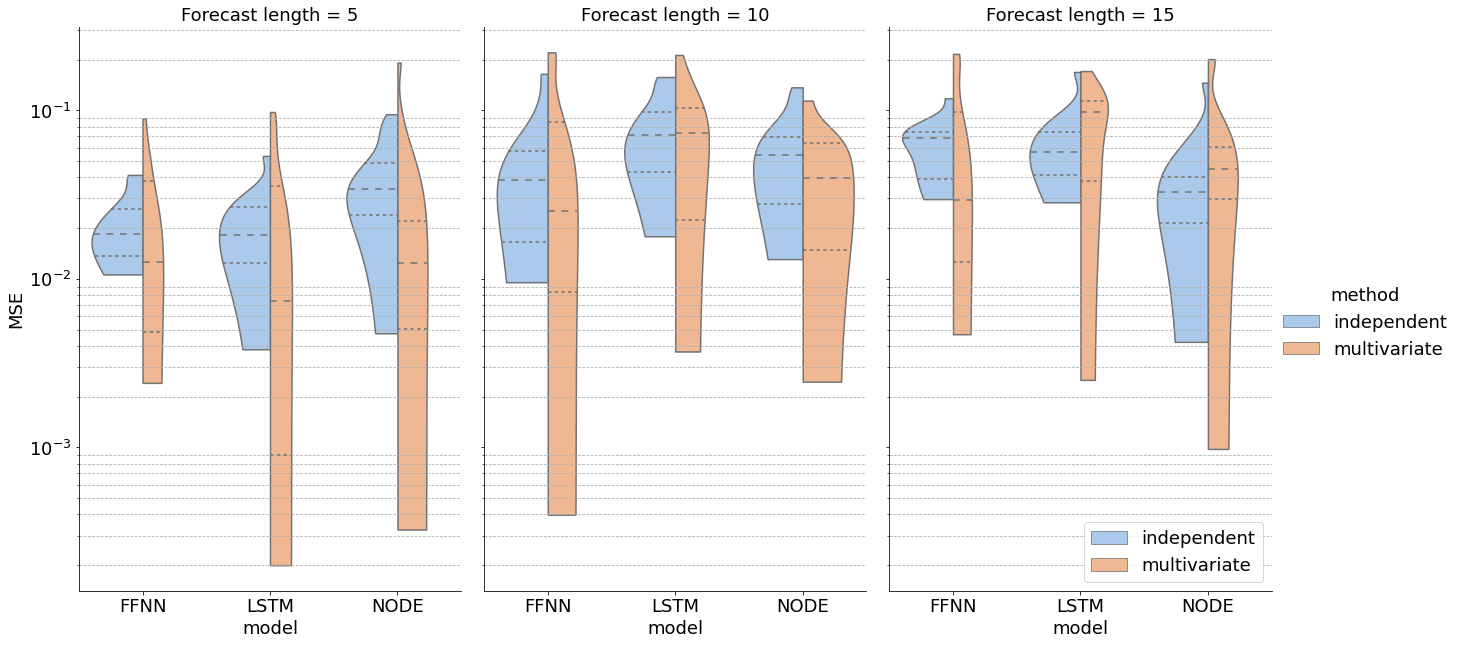

In [ ]:
import seaborn as sns

forecast_lengths = [5,10,15]

labels = [model + str(forecast_length) for forecast_length in forecast_lengths for model in ["FFNN", "LSTM", "NODE"] ]
dfs = []

for j, method in enumerate(['independent', 'multivariate']):
  # for i, label in enumerate(labels):
  for f, fl in enumerate(forecast_lengths):
    for k, model in enumerate(["FFNN", "LSTM", "NODE"]):
      dfs.append(pd.DataFrame({'MSE':MSEs_corr[f, k, j,:], 'model & forecast length':label, 'model': model, 'Forecast length': fl, 'method':method}))

df = pd.concat(dfs)


# fig, ax = plt.subplots(figsize=(15,9))
# ax = sns.violinplot(data = df, x='model & forecast length', y='MSE', hue='method', split=True, palette="muted", inner="quartiles", cut=0)
g = sns.catplot(data = df, x='model', y='MSE', hue='method', col = 'Forecast length', kind='violin', height = 9, aspect = 0.66, split=True, palette="pastel", inner="quartiles", cut=0)




for ax in g.axes[0]:
  # print(ax)
  ax.grid(b=True, axis='y', which='minor', linestyle='--')

plt.legend(loc = 'lower right')
plt.yscale("log")
plt.savefig("correlated_forecasts.png",bbox_inches='tight')
# ax = sns.violinplot(x="day", y="total_bill", hue="sex",
#                     data=tips, palette="Set2", split=True,
#                     scale="count", inner="stick")

## Additional variables

In [ ]:
indicators_part_1 = ["Population", "GDP per capita", "Energy intensity", "Carbon intensity"]
indicators_part_2 = ["Electricity - fossil fuels", "Electricity - nuclear", "Electricity - renewables"]
comparison_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]


MSEs_add = np.zeros((3, 2, len(comparison_countries), len(indicators_part_1)))
forecast_length = 10

models_types = ["FFNN", "LSTM", "NODE"]
train_processes = [FFNN_init_and_train, LSTM_init_and_train, NODE_init_and_train]
forecast_processes = [FFNN_forecast, LSTM_forecast, NODE_forecast]
training_args = [[5, 128, 2000, 0, 0.001, 0.0001], [32, 3000, 0, 0.0005, 0.0001], [ShallowLinearODEF, 1024, 3000, 0, 5, 0.002, 0]]

perfs = []



In [ ]:
k = 1

for j, indicators in enumerate([indicators_part_1, indicators_part_1 + indicators_part_2]):
  for i, country in enumerate(comparison_countries):
    countries = [country]

    MSE = compute_singlecountry_MSE(countries, indicators, forecast_length, train_processes[k], forecast_processes[k], training_args[k])
    MSEs_add[k, j, i, :] = MSE[:len(indicators_part_1)]


# MSEs_add = MSEs_add[:,:,:len(indicators_part_1)]
print(np.ndarray.tolist(MSEs_add))

In [ ]:
# FORECAST LENGTH 5
# comparison_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]

MSEs_add = np.array([[[[0.03442130237817764, 0.17942067980766296, 0.04174851253628731, 0.004692136775702238], [0.04567233845591545, 0.012956189922988415, 0.004183036740869284, 0.0014555752277374268], [0.02852010726928711, 0.13132759928703308, 0.008174819871783257, 0.015120366588234901], [0.00012280208466108888, 0.06534962356090546, 0.006289529614150524, 0.07560307532548904], [0.1096544861793518, 0.04717131704092026, 0.0050077615305781364, 0.004070921801030636], [0.0013413737760856748, 0.0066352300345897675, 0.00402595940977335, 0.04272421821951866], [0.002066107001155615, 0.007977364584803581, 0.00025632287724874914, 0.05852660536766052], [0.003927999176084995, 0.040300481021404266, 0.002647362183779478, 0.07278724759817123], [0.011336800642311573, 0.1781013458967209, 0.008095653727650642, 0.0021930572111159563], [0.0003165183588862419, 0.27300190925598145, 0.004236424341797829, 0.014338398352265358], [0.010579649358987808, 0.13203366100788116, 0.02284979447722435, 0.0010471658315509558], [8.557387627661228e-05, 0.080520860850811, 0.004150290507823229, 0.02272053435444832]], [[0.00740938913077116, 0.009337264113128185, 0.0016606871504336596, 0.03644787147641182], [0.06421437114477158, 0.040658753365278244, 0.018025105819106102, 0.0013905918458476663], [0.010824611410498619, 0.11197211593389511, 0.011383075267076492, 0.027195662260055542], [0.0006552834529429674, 0.02615322172641754, 0.004438543692231178, 0.034747906029224396], [0.4371223449707031, 0.00981961376965046, 0.00042485306039452553, 0.028465356677770615], [0.002593575743958354, 0.033862169831991196, 0.010796917602419853, 0.03701149299740791], [0.009292264468967915, 0.06767631322145462, 0.0017873954493552446, 0.004170238971710205], [0.0008680908940732479, 0.021106760948896408, 0.011701984331011772, 0.09633775800466537], [0.004850205034017563, 0.20886802673339844, 0.0005082644638605416, 0.0007005240768194199], [0.0005228075897321105, 0.3875570297241211, 0.002614912809804082, 0.010426419787108898], [0.007516832556575537, 0.1738651692867279, 0.012031345628201962, 0.006330007221549749], [0.0023335195146501064, 0.1121506318449974, 0.014934873208403587, 0.006893756799399853]]], [[[0.0019752615645629136, 0.004482177639496853, 0.0008584431728561603, 0.003776372210651524], [0.006238501462433987, 0.01381227828781988, 0.00040707843882262175, 0.006639555568890921], [0.0009770004432247958, 0.02679063787785694, 0.0007934659600328228, 0.00028587243072759997], [0.007819820746546214, 0.0071594321630321645, 7.739474423141393e-05, 0.10337282549745334], [0.1394895681842428, 0.011397096549062269, 7.712606556614331e-06, 0.010763554782957763], [0.0009141982031067641, 0.012783057024867617, 0.0007032231351976647, 0.0588173731256096], [0.00898377782547044, 0.09296928673478178, 6.82870934835986e-05, 0.007544273852318683], [0.002602815152555138, 0.0025998252488960817, 0.009503249670547961, 0.030910855129567816], [0.03196373245441606, 0.01594013246996582, 5.46661143053512e-05, 0.023636812512189888], [0.01435052389285687, 0.11270543066849328, 0.0015783704082922567, 0.013349012536185834], [0.022562110133252843, 0.0774892265862988, 0.001258600233276869, 0.0008401740061102881], [0.0031715169576600035, 0.03287192841637747, 0.0009030819193122465, 0.009262039202158795]], [[0.007837056476716241, 0.003989299198787677, 0.000860587495425761, 0.0058133359911391345], [0.0023392561675628087, 0.00661264531401855, 0.00035402506678938517, 0.006039014647173213], [1.4375680233058575e-05, 0.02888379415229423, 0.0007131860550075926, 0.00031734474028417386], [0.015396391171246648, 0.010509361225699365, 0.0023767420619657522, 0.07763748522767612], [0.14772189631274274, 0.00907012702476635, 0.0010669327029667014, 0.008394901680841626], [0.00016419325175931476, 0.01026254855161426, 0.004095089341467182, 0.05460307224198167], [0.023447708801444377, 0.10856534180672313, 0.003552357500629806, 0.009280174890105509], [0.0056761686489991805, 0.005333990061257054, 0.00884878900220347, 0.03070941399028606], [0.021266367697284495, 0.023709039817360632, 4.911225917142453e-05, 0.00524112544951213], [0.01858917295040996, 0.11725798128344778, 0.0011888287741958045, 0.01314794863758988], [0.03500431258976775, 0.038155141197584896, 0.003922501147925506, 0.0010234103798859463], [0.006579604418953266, 0.01875396765866668, 0.0006602848228757961, 0.014382169758607306]]], [[[0.08464627712965012, 0.14265455305576324, 0.0032894699834287167, 0.02221236750483513], [0.040641359984874725, 0.113274946808815, 0.0027350024320185184, 0.0009161350317299366], [0.014801989309489727, 0.07286383956670761, 0.0007892400026321411, 0.00016586729907430708], [0.0011404978577047586, 0.09750653058290482, 0.002415118273347616, 0.08364095538854599], [0.05866216495633125, 0.09319823980331421, 0.0028792060911655426, 0.012318515218794346], [0.05719287320971489, 0.0702362135052681, 0.011611977592110634, 0.08819200843572617], [0.02089918777346611, 0.0047767856158316135, 0.0022835659328848124, 0.007882965728640556], [0.06000291556119919, 0.1375456601381302, 0.022771615535020828, 0.04417681694030762], [0.002166801132261753, 0.1223258525133133, 0.006334303412586451, 0.001002433942630887], [0.00010093678429257125, 0.28492194414138794, 0.008445261046290398, 0.015662843361496925], [0.013553529977798462, 0.1254669427871704, 0.0025050234980881214, 0.0018304871628060937], [0.003830996109172702, 0.0767286866903305, 0.003046170575544238, 0.022792872041463852]], [[0.09221339225769043, 0.058418743312358856, 0.011127253994345665, 0.0038033523596823215], [0.03671349212527275, 0.07804442942142487, 0.006176904775202274, 0.0008619295549578965], [0.009804485365748405, 0.08435643464326859, 0.0060514542274177074, 0.0003039418952539563], [0.01860019564628601, 0.06150476261973381, 0.011385508812963963, 0.13487042486667633], [0.05610041692852974, 0.053344301879405975, 0.0005776078323833644, 0.007597494870424271], [0.05299055576324463, 0.041101302951574326, 0.006105598993599415, 0.11432453244924545], [0.03020293079316616, 0.010167419910430908, 0.0033875792287290096, 0.002210920210927725], [0.008619716390967369, 0.10743342339992523, 0.028338098898530006, 0.011966696940362453], [0.00019025712390430272, 0.1162736639380455, 0.004516083747148514, 0.0014816377079114318], [0.006065958179533482, 0.4949547350406647, 0.01780802011489868, 0.014633340761065483], [0.021348360925912857, 0.09116987884044647, 0.005528321024030447, 0.0008710551774129272], [0.0015179557958617806, 0.1170537918806076, 0.006220308132469654, 0.019153675064444542]]]])
print(MSEs_add.shape)

(3, 2, 12, 4)


In [ ]:
# FORECAST LENGTH 10
# comparison_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]

MSEs_add = np.array([[[[0.1259937733411789, 0.41654300689697266, 0.011415218934416771, 0.01670156791806221], [0.10958956182003021, 0.34849533438682556, 0.010758811607956886, 0.017110086977481842], [0.0047455159947276115, 0.043605707585811615, 0.008004244416952133, 0.024826759472489357], [0.000666558276861906, 0.09568073600530624, 0.017930420115590096, 0.31413114070892334], [0.015910057350993156, 0.13481880724430084, 0.0008590108482167125, 0.009683932177722454], [0.12185356765985489, 0.22215226292610168, 0.0023667155764997005, 0.09220806509256363], [0.005685714539140463, 0.014216722920536995, 0.023696385324001312, 0.116091288626194], [0.054074615240097046, 0.3012344539165497, 0.0076761567033827305, 0.027475932613015175], [0.02308664843440056, 0.0026131754275411367, 0.09719210863113403, 0.009092085994780064], [0.002044654218479991, 0.19342133402824402, 0.006991654634475708, 0.025545820593833923], [0.0076807839795947075, 0.04912083223462105, 0.002428283914923668, 0.017126668244600296], [0.0006225274410098791, 0.013297507539391518, 0.008026888594031334, 0.16445831954479218]], [[0.06118200346827507, 0.2996287941932678, 0.009635530412197113, 0.029439982026815414], [0.2368835210800171, 0.4780815541744232, 0.0007152323378250003, 0.00870626699179411], [0.04504648968577385, 0.14743955433368683, 0.008257945068180561, 0.015456153079867363], [0.0009364386205561459, 0.13577377796173096, 0.003910505212843418, 0.21633975207805634], [0.1918507218360901, 0.01823338493704796, 0.004520215094089508, 0.01651688851416111], [0.044857580214738846, 0.37461239099502563, 0.06359085440635681, 0.05668047070503235], [0.0052423556335270405, 0.02604925073683262, 0.016962984576821327, 0.08146822452545166], [0.14768452942371368, 1.1235805749893188, 0.06461276113986969, 0.025457093492150307], [0.01653130166232586, 0.0034354235976934433, 0.12790115177631378, 0.005256944335997105], [0.02390589937567711, 0.5117284655570984, 0.005019619595259428, 0.031831178814172745], [0.002038193866610527, 0.11571526527404785, 0.0009587573003955185, 0.0037000186275690794], [0.010036304593086243, 0.07054509222507477, 0.014849185943603516, 0.010381055995821953]]], [[[0.02416861220307709, 0.1491976138207775, 0.0317676541589927, 0.03554967494109297], [0.004238048426883268, 0.13527368606631854, 0.010946619635389097, 0.018546355663086316], [0.03236800827309523, 0.15573090255498415, 0.01600610287582998, 0.004788922060676447], [0.048410207409549245, 0.037922731027072484, 0.003239271579106244, 0.08913676077470792], [0.046337554268348666, 0.0071239692532412136, 0.0001686023743518969, 0.02642874015863414], [0.01595583576442543, 0.05431483917512843, 0.0001990257664335298, 0.03121796212344185], [0.0027406354386162236, 0.023145854342255134, 0.013413075166244678, 0.04911559916784729], [0.01840858917036563, 0.15566847179386514, 0.004265010497989645, 0.14488242846527294], [0.01224280895757559, 0.059694740118828096, 0.004576492256459092, 0.02734618532251652], [0.020873818944867395, 0.07859874124668309, 0.00010014067970483178, 0.09167352818432252], [0.02523473984825273, 0.021991896735056925, 0.007035572512902322, 0.0008965049663596786], [0.0006606946029794614, 0.11178848820671661, 7.069458268082104e-05, 0.01256871846297177]], [[0.021659461035038418, 0.11496476155325439, 0.0012472844923056823, 0.05487877111006693], [0.006460811595364646, 0.10231213778511546, 0.00968230317126145, 0.016735468005638236], [0.009421653120240236, 0.05381396969267094, 4.515750375654384e-05, 0.00023317416092361788], [0.04077801871452245, 0.0375515817749978, 0.009950599431883268, 0.07670608938124679], [0.04025502129260836, 0.003013173640730571, 0.00015505049439925575, 0.01383427527382176], [0.0073457315897236695, 0.04961768798584636, 0.00017405566802750598, 0.028980617479252502], [0.009089731687707926, 0.019948086889937145, 0.009505674621923848, 0.08975389353103422], [0.021710765364651864, 0.2831875871432956, 0.013213118450924549, 0.13012877240326823], [0.017228076085645583, 0.020852991090340823, 7.504277177276666e-05, 0.04094743679554929], [0.03405436515852038, 0.06974306796995151, 0.005543860847375966, 0.062468798561525415], [0.04115983999489821, 0.0151786610486063, 0.0005363523213832265, 0.006737470357620115], [0.00028107891060820124, 0.08674178964031327, 0.0023251158835273593, 0.025250858454689034]]], [[[0.07943091541528702, 0.13572677969932556, 0.01290218811482191, 0.09173359721899033], [0.004784929566085339, 0.18891865015029907, 0.0003482496540527791, 0.023601096123456955], [0.014414231292903423, 0.07072067260742188, 0.0015044236788526177, 0.0007208644528873265], [0.0031250175088644028, 0.15525226294994354, 0.0018616823945194483, 0.10425300896167755], [0.3475077450275421, 0.009121390990912914, 0.0046021644957363605, 0.028731053695082664], [0.07327771931886673, 0.13948054611682892, 0.018316522240638733, 0.048686981201171875], [0.0492568165063858, 0.08601270616054535, 0.010211288928985596, 0.12412576377391815], [0.07760156691074371, 0.31942692399024963, 0.03945270925760269, 0.08644718676805496], [0.0008307818206958473, 0.08944984525442123, 0.005408777389675379, 0.028053998947143555], [0.02245759405195713, 0.16127809882164001, 0.0064467452466487885, 0.0364682637155056], [0.027485188096761703, 0.02068958804011345, 0.0035117589868605137, 0.016266807913780212], [0.00018826285668183118, 0.0471307635307312, 0.002356618409976363, 0.04973166063427925]], [[0.12646473944187164, 0.20186105370521545, 0.030282247811555862, 0.1381305754184723], [0.004441542085260153, 0.14963065087795258, 0.00016215034702327102, 0.02321753278374672], [0.01451815851032734, 0.08102530241012573, 0.012201105244457722, 0.00042030037730000913], [0.004714109934866428, 0.16252705454826355, 0.007427004631608725, 0.10749193280935287], [0.07644525170326233, 0.027868080884218216, 0.00026671268278732896, 0.039403267204761505], [0.08269776403903961, 0.12703320384025574, 0.009644994512200356, 0.04919254034757614], [0.059447161853313446, 0.1280207335948944, 0.010721782222390175, 0.08831019699573517], [0.06305589526891708, 0.39013344049453735, 0.051014870405197144, 0.0637151226401329], [0.0018685035174712539, 0.16801951825618744, 0.01115725003182888, 0.0180471483618021], [0.011580342426896095, 0.1508026421070099, 0.009030969813466072, 0.04101695865392685], [0.03367403894662857, 0.03757838159799576, 0.008308697491884232, 0.011825132183730602], [0.0002880290267057717, 0.07252776622772217, 0.006082627922296524, 0.04603038355708122]]]])
print(MSEs_add.shape)

(3, 2, 12, 4)


In [ ]:
# FORECAST LENGTH 15
# comparison_countries = ["Spain", "Italy", "France", "United Kingdom", "Germany", "Portugal", "Ireland", "Greece", "Denmark", "Norway", "Sweden", "Finland"]

MSEs_add = np.array([[[[0.24237483739852905, 0.21059302985668182, 0.05949852615594864, 0.7503380179405212], [0.07644059509038925, 0.013696915470063686, 0.001445620902813971, 0.15099778771400452], [0.003561344463378191, 0.03163614869117737, 0.0017979127587750554, 0.0059273275546729565], [0.107940673828125, 0.009459546767175198, 0.010459989309310913, 0.03779466077685356], [0.16495223343372345, 0.033191364258527756, 0.019064201042056084, 0.03787565976381302], [0.015728382393717766, 0.009055985137820244, 0.005938512273132801, 0.22341741621494293], [0.2818337082862854, 0.5943592190742493, 0.0006232704618014395, 0.016199517995119095], [1.672803521156311, 1.8123294115066528, 0.02993599884212017, 1.8750609159469604], [0.10231634974479675, 0.03890107199549675, 0.0008751578279770911, 0.008479748852550983], [0.0017238539876416326, 0.0535220131278038, 0.0016309459460899234, 0.1794479936361313], [0.08035234361886978, 0.11695321649312973, 0.005337017122656107, 0.021500909700989723], [0.01967017538845539, 0.11714053153991699, 0.002172162290662527, 0.08813385665416718]], [[0.012142358347773552, 0.02856534533202648, 0.01542548555880785, 0.12525448203086853], [0.14138755202293396, 0.10135417431592941, 0.008615310303866863, 0.10766900330781937], [0.007174712605774403, 0.04105345532298088, 0.016749141737818718, 0.27309077978134155], [0.06745100766420364, 0.018152235075831413, 0.004853500053286552, 0.07689253985881805], [0.04755934327840805, 0.17059336602687836, 0.009467403404414654, 0.017589319497346878], [0.08033857494592667, 0.03486015275120735, 0.006671851500868797, 0.16390866041183472], [0.619051992893219, 2.100790023803711, 0.0023503215052187443, 0.08184099197387695], [1.902016520500183, 1.2991070747375488, 0.05266202986240387, 1.0380783081054688], [0.0013287703040987253, 0.022822774946689606, 0.011132984422147274, 0.0032386097591370344], [0.016722682863473892, 0.04188557714223862, 0.007474597077816725, 0.07189362496137619], [0.10484311729669571, 0.13671250641345978, 0.01286513265222311, 0.012355034239590168], [0.014878634363412857, 0.10483942925930023, 0.0030156865250319242, 0.06428645551204681]]], [[[0.012936935813250727, 0.04159675358537953, 0.0013386966679916166, 0.09522948626598023], [0.13487347963289398, 0.07554774269122339, 0.004235405209444614, 0.09411768033740825], [0.05778141529386265, 0.06941411471003534, 0.0005007015982514474, 0.00660104214963625], [0.16200557940576962, 0.02888088472464408, 0.0005183176520869658, 0.025637201308413002], [0.036543963782661136, 0.14161880818050748, 0.0053048366151770545, 0.007691916049163294], [0.010805750513785977, 0.07230721498284207, 0.007623053703145846, 0.22419001381278664], [0.010048950686784271, 0.04296257383455237, 0.01808455892434098, 0.03716546151954663], [0.010687941908149175, 0.06003415404230405, 0.013758433615572033, 0.09765290793963971], [0.045216876069421374, 0.09667446370057273, 0.006733565739046097, 0.06350831670975615], [0.04737590907143764, 0.08990110388815734, 0.000455914201191665, 0.044686679604544394], [0.11289445215385233, 0.13298231044431313, 0.0075266597406644506, 0.031685704786878814], [0.023767522452092984, 0.11373007567727621, 0.004428486195757869, 0.10727422709544117]], [[0.04776003351704906, 0.06916114012045729, 0.003924892137643143, 0.07130536848100445], [0.16290548067254634, 0.0721410224379099, 0.005079170787298427, 0.10693768605016234], [0.05858740475470559, 0.08641859827540302, 0.0034409057560243718, 0.00996354279643107], [0.15014647550648377, 0.028348891330452375, 0.0012266562124519122, 0.026784496094324275], [0.032378931584054985, 0.14390595789404065, 0.004831449266394361, 0.009897958575404271], [0.006266691559091223, 0.09797168774217227, 0.00019887406324596568, 0.16144579484404334], [0.03423420673038867, 0.013454445682765244, 0.005579390507230224, 0.045437896063002324], [0.010851966860123479, 0.05136944722800247, 0.007109780101375364, 0.06489873725744716], [0.055448753212999455, 0.09978818263590625, 0.004581222828150727, 0.06626713721062351], [0.05236800644317441, 0.09445562928988244, 0.00027978603890428596, 0.05124413127729429], [0.11860815024952635, 0.14288457444644287, 0.0075515458671122655, 0.03277469568512418], [0.0252559974121759, 0.10680583095105618, 0.00502449326709929, 0.07981657391002124]]], [[[0.018266385421156883, 0.018217364326119423, 0.0008105915621854365, 0.03830801695585251], [0.06994867324829102, 0.02334948442876339, 0.006832758896052837, 0.023151297122240067], [0.001559669035486877, 0.043647147715091705, 0.0004335435514803976, 0.002178083872422576], [0.024895545095205307, 0.06372567266225815, 8.103727304842323e-05, 0.022839421406388283], [0.3428495526313782, 0.14195798337459564, 0.0026476378552615643, 0.012027380988001823], [0.027607012540102005, 0.020337695255875587, 0.0040773362852633, 0.24450641870498657], [0.008723868057131767, 0.0189659483730793, 0.008329886943101883, 0.038915183395147324], [0.09052055329084396, 0.04127557948231697, 0.010423672385513783, 0.08271854370832443], [0.0014536665985360742, 0.02515885792672634, 0.003985341172665358, 0.04163086786866188], [0.02543422393500805, 0.0751664787530899, 0.0026107572484761477, 0.040191587060689926], [0.03899108245968819, 0.06379006057977676, 0.0006424487219192088, 0.021472612395882607], [0.0011733942665159702, 0.04345907270908356, 0.0005424243281595409, 0.09966034442186356]], [[0.014378451742231846, 0.024190789088606834, 0.0007394468993879855, 0.0695849359035492], [0.07365740090608597, 0.014727824367582798, 0.00500339362770319, 0.025903379544615746], [0.0021777853835374117, 0.04314518719911575, 0.0006399594130925834, 0.004551964346319437], [0.0368453785777092, 0.03897303715348244, 0.0002460711111780256, 0.024405455216765404], [0.17198388278484344, 0.07722973823547363, 0.0002855134371202439, 0.012103524059057236], [0.029467083513736725, 0.018151752650737762, 0.002419315278530121, 0.2970620095729828], [0.010426158085465431, 0.01708952710032463, 0.004384256433695555, 0.0461040660738945], [0.06934253126382828, 0.040740687400102615, 0.0104365898296237, 0.048779163509607315], [0.003627675585448742, 0.030920587480068207, 0.005868676118552685, 0.016794485971331596], [0.022873615846037865, 0.05276518315076828, 0.003979877103120089, 0.06545010954141617], [0.06825273483991623, 0.08712638169527054, 0.0002999337448272854, 0.021411720663309097], [0.00270786858163774, 0.05474898964166641, 0.0006161396158859134, 0.08719832450151443]]]])
print(MSEs_add.shape)

(3, 2, 12, 4)


In [ ]:
# FORECAST LENGTHS 5 10 15
MSEs_add = np.zeros((3,3,2,12,4))
MSEs_add[0] = np.array([[[[0.03442130237817764, 0.17942067980766296, 0.04174851253628731, 0.004692136775702238], [0.04567233845591545, 0.012956189922988415, 0.004183036740869284, 0.0014555752277374268], [0.02852010726928711, 0.13132759928703308, 0.008174819871783257, 0.015120366588234901], [0.00012280208466108888, 0.06534962356090546, 0.006289529614150524, 0.07560307532548904], [0.1096544861793518, 0.04717131704092026, 0.0050077615305781364, 0.004070921801030636], [0.0013413737760856748, 0.0066352300345897675, 0.00402595940977335, 0.04272421821951866], [0.002066107001155615, 0.007977364584803581, 0.00025632287724874914, 0.05852660536766052], [0.003927999176084995, 0.040300481021404266, 0.002647362183779478, 0.07278724759817123], [0.011336800642311573, 0.1781013458967209, 0.008095653727650642, 0.0021930572111159563], [0.0003165183588862419, 0.27300190925598145, 0.004236424341797829, 0.014338398352265358], [0.010579649358987808, 0.13203366100788116, 0.02284979447722435, 0.0010471658315509558], [8.557387627661228e-05, 0.080520860850811, 0.004150290507823229, 0.02272053435444832]], [[0.00740938913077116, 0.009337264113128185, 0.0016606871504336596, 0.03644787147641182], [0.06421437114477158, 0.040658753365278244, 0.018025105819106102, 0.0013905918458476663], [0.010824611410498619, 0.11197211593389511, 0.011383075267076492, 0.027195662260055542], [0.0006552834529429674, 0.02615322172641754, 0.004438543692231178, 0.034747906029224396], [0.4371223449707031, 0.00981961376965046, 0.00042485306039452553, 0.028465356677770615], [0.002593575743958354, 0.033862169831991196, 0.010796917602419853, 0.03701149299740791], [0.009292264468967915, 0.06767631322145462, 0.0017873954493552446, 0.004170238971710205], [0.0008680908940732479, 0.021106760948896408, 0.011701984331011772, 0.09633775800466537], [0.004850205034017563, 0.20886802673339844, 0.0005082644638605416, 0.0007005240768194199], [0.0005228075897321105, 0.3875570297241211, 0.002614912809804082, 0.010426419787108898], [0.007516832556575537, 0.1738651692867279, 0.012031345628201962, 0.006330007221549749], [0.0023335195146501064, 0.1121506318449974, 0.014934873208403587, 0.006893756799399853]]], [[[0.0019752615645629136, 0.004482177639496853, 0.0008584431728561603, 0.003776372210651524], [0.006238501462433987, 0.01381227828781988, 0.00040707843882262175, 0.006639555568890921], [0.0009770004432247958, 0.02679063787785694, 0.0007934659600328228, 0.00028587243072759997], [0.007819820746546214, 0.0071594321630321645, 7.739474423141393e-05, 0.10337282549745334], [0.1394895681842428, 0.011397096549062269, 7.712606556614331e-06, 0.010763554782957763], [0.0009141982031067641, 0.012783057024867617, 0.0007032231351976647, 0.0588173731256096], [0.00898377782547044, 0.09296928673478178, 6.82870934835986e-05, 0.007544273852318683], [0.002602815152555138, 0.0025998252488960817, 0.009503249670547961, 0.030910855129567816], [0.03196373245441606, 0.01594013246996582, 5.46661143053512e-05, 0.023636812512189888], [0.01435052389285687, 0.11270543066849328, 0.0015783704082922567, 0.013349012536185834], [0.022562110133252843, 0.0774892265862988, 0.001258600233276869, 0.0008401740061102881], [0.0031715169576600035, 0.03287192841637747, 0.0009030819193122465, 0.009262039202158795]], [[0.007837056476716241, 0.003989299198787677, 0.000860587495425761, 0.0058133359911391345], [0.0023392561675628087, 0.00661264531401855, 0.00035402506678938517, 0.006039014647173213], [1.4375680233058575e-05, 0.02888379415229423, 0.0007131860550075926, 0.00031734474028417386], [0.015396391171246648, 0.010509361225699365, 0.0023767420619657522, 0.07763748522767612], [0.14772189631274274, 0.00907012702476635, 0.0010669327029667014, 0.008394901680841626], [0.00016419325175931476, 0.01026254855161426, 0.004095089341467182, 0.05460307224198167], [0.023447708801444377, 0.10856534180672313, 0.003552357500629806, 0.009280174890105509], [0.0056761686489991805, 0.005333990061257054, 0.00884878900220347, 0.03070941399028606], [0.021266367697284495, 0.023709039817360632, 4.911225917142453e-05, 0.00524112544951213], [0.01858917295040996, 0.11725798128344778, 0.0011888287741958045, 0.01314794863758988], [0.03500431258976775, 0.038155141197584896, 0.003922501147925506, 0.0010234103798859463], [0.006579604418953266, 0.01875396765866668, 0.0006602848228757961, 0.014382169758607306]]], [[[0.08464627712965012, 0.14265455305576324, 0.0032894699834287167, 0.02221236750483513], [0.040641359984874725, 0.113274946808815, 0.0027350024320185184, 0.0009161350317299366], [0.014801989309489727, 0.07286383956670761, 0.0007892400026321411, 0.00016586729907430708], [0.0011404978577047586, 0.09750653058290482, 0.002415118273347616, 0.08364095538854599], [0.05866216495633125, 0.09319823980331421, 0.0028792060911655426, 0.012318515218794346], [0.05719287320971489, 0.0702362135052681, 0.011611977592110634, 0.08819200843572617], [0.02089918777346611, 0.0047767856158316135, 0.0022835659328848124, 0.007882965728640556], [0.06000291556119919, 0.1375456601381302, 0.022771615535020828, 0.04417681694030762], [0.002166801132261753, 0.1223258525133133, 0.006334303412586451, 0.001002433942630887], [0.00010093678429257125, 0.28492194414138794, 0.008445261046290398, 0.015662843361496925], [0.013553529977798462, 0.1254669427871704, 0.0025050234980881214, 0.0018304871628060937], [0.003830996109172702, 0.0767286866903305, 0.003046170575544238, 0.022792872041463852]], [[0.09221339225769043, 0.058418743312358856, 0.011127253994345665, 0.0038033523596823215], [0.03671349212527275, 0.07804442942142487, 0.006176904775202274, 0.0008619295549578965], [0.009804485365748405, 0.08435643464326859, 0.0060514542274177074, 0.0003039418952539563], [0.01860019564628601, 0.06150476261973381, 0.011385508812963963, 0.13487042486667633], [0.05610041692852974, 0.053344301879405975, 0.0005776078323833644, 0.007597494870424271], [0.05299055576324463, 0.041101302951574326, 0.006105598993599415, 0.11432453244924545], [0.03020293079316616, 0.010167419910430908, 0.0033875792287290096, 0.002210920210927725], [0.008619716390967369, 0.10743342339992523, 0.028338098898530006, 0.011966696940362453], [0.00019025712390430272, 0.1162736639380455, 0.004516083747148514, 0.0014816377079114318], [0.006065958179533482, 0.4949547350406647, 0.01780802011489868, 0.014633340761065483], [0.021348360925912857, 0.09116987884044647, 0.005528321024030447, 0.0008710551774129272], [0.0015179557958617806, 0.1170537918806076, 0.006220308132469654, 0.019153675064444542]]]])
MSEs_add[1] = np.array([[[[0.1259937733411789, 0.41654300689697266, 0.011415218934416771, 0.01670156791806221], [0.10958956182003021, 0.34849533438682556, 0.010758811607956886, 0.017110086977481842], [0.0047455159947276115, 0.043605707585811615, 0.008004244416952133, 0.024826759472489357], [0.000666558276861906, 0.09568073600530624, 0.017930420115590096, 0.31413114070892334], [0.015910057350993156, 0.13481880724430084, 0.0008590108482167125, 0.009683932177722454], [0.12185356765985489, 0.22215226292610168, 0.0023667155764997005, 0.09220806509256363], [0.005685714539140463, 0.014216722920536995, 0.023696385324001312, 0.116091288626194], [0.054074615240097046, 0.3012344539165497, 0.0076761567033827305, 0.027475932613015175], [0.02308664843440056, 0.0026131754275411367, 0.09719210863113403, 0.009092085994780064], [0.002044654218479991, 0.19342133402824402, 0.006991654634475708, 0.025545820593833923], [0.0076807839795947075, 0.04912083223462105, 0.002428283914923668, 0.017126668244600296], [0.0006225274410098791, 0.013297507539391518, 0.008026888594031334, 0.16445831954479218]], [[0.06118200346827507, 0.2996287941932678, 0.009635530412197113, 0.029439982026815414], [0.2368835210800171, 0.4780815541744232, 0.0007152323378250003, 0.00870626699179411], [0.04504648968577385, 0.14743955433368683, 0.008257945068180561, 0.015456153079867363], [0.0009364386205561459, 0.13577377796173096, 0.003910505212843418, 0.21633975207805634], [0.1918507218360901, 0.01823338493704796, 0.004520215094089508, 0.01651688851416111], [0.044857580214738846, 0.37461239099502563, 0.06359085440635681, 0.05668047070503235], [0.0052423556335270405, 0.02604925073683262, 0.016962984576821327, 0.08146822452545166], [0.14768452942371368, 1.1235805749893188, 0.06461276113986969, 0.025457093492150307], [0.01653130166232586, 0.0034354235976934433, 0.12790115177631378, 0.005256944335997105], [0.02390589937567711, 0.5117284655570984, 0.005019619595259428, 0.031831178814172745], [0.002038193866610527, 0.11571526527404785, 0.0009587573003955185, 0.0037000186275690794], [0.010036304593086243, 0.07054509222507477, 0.014849185943603516, 0.010381055995821953]]], [[[0.02416861220307709, 0.1491976138207775, 0.0317676541589927, 0.03554967494109297], [0.004238048426883268, 0.13527368606631854, 0.010946619635389097, 0.018546355663086316], [0.03236800827309523, 0.15573090255498415, 0.01600610287582998, 0.004788922060676447], [0.048410207409549245, 0.037922731027072484, 0.003239271579106244, 0.08913676077470792], [0.046337554268348666, 0.0071239692532412136, 0.0001686023743518969, 0.02642874015863414], [0.01595583576442543, 0.05431483917512843, 0.0001990257664335298, 0.03121796212344185], [0.0027406354386162236, 0.023145854342255134, 0.013413075166244678, 0.04911559916784729], [0.01840858917036563, 0.15566847179386514, 0.004265010497989645, 0.14488242846527294], [0.01224280895757559, 0.059694740118828096, 0.004576492256459092, 0.02734618532251652], [0.020873818944867395, 0.07859874124668309, 0.00010014067970483178, 0.09167352818432252], [0.02523473984825273, 0.021991896735056925, 0.007035572512902322, 0.0008965049663596786], [0.0006606946029794614, 0.11178848820671661, 7.069458268082104e-05, 0.01256871846297177]], [[0.021659461035038418, 0.11496476155325439, 0.0012472844923056823, 0.05487877111006693], [0.006460811595364646, 0.10231213778511546, 0.00968230317126145, 0.016735468005638236], [0.009421653120240236, 0.05381396969267094, 4.515750375654384e-05, 0.00023317416092361788], [0.04077801871452245, 0.0375515817749978, 0.009950599431883268, 0.07670608938124679], [0.04025502129260836, 0.003013173640730571, 0.00015505049439925575, 0.01383427527382176], [0.0073457315897236695, 0.04961768798584636, 0.00017405566802750598, 0.028980617479252502], [0.009089731687707926, 0.019948086889937145, 0.009505674621923848, 0.08975389353103422], [0.021710765364651864, 0.2831875871432956, 0.013213118450924549, 0.13012877240326823], [0.017228076085645583, 0.020852991090340823, 7.504277177276666e-05, 0.04094743679554929], [0.03405436515852038, 0.06974306796995151, 0.005543860847375966, 0.062468798561525415], [0.04115983999489821, 0.0151786610486063, 0.0005363523213832265, 0.006737470357620115], [0.00028107891060820124, 0.08674178964031327, 0.0023251158835273593, 0.025250858454689034]]], [[[0.07943091541528702, 0.13572677969932556, 0.01290218811482191, 0.09173359721899033], [0.004784929566085339, 0.18891865015029907, 0.0003482496540527791, 0.023601096123456955], [0.014414231292903423, 0.07072067260742188, 0.0015044236788526177, 0.0007208644528873265], [0.0031250175088644028, 0.15525226294994354, 0.0018616823945194483, 0.10425300896167755], [0.3475077450275421, 0.009121390990912914, 0.0046021644957363605, 0.028731053695082664], [0.07327771931886673, 0.13948054611682892, 0.018316522240638733, 0.048686981201171875], [0.0492568165063858, 0.08601270616054535, 0.010211288928985596, 0.12412576377391815], [0.07760156691074371, 0.31942692399024963, 0.03945270925760269, 0.08644718676805496], [0.0008307818206958473, 0.08944984525442123, 0.005408777389675379, 0.028053998947143555], [0.02245759405195713, 0.16127809882164001, 0.0064467452466487885, 0.0364682637155056], [0.027485188096761703, 0.02068958804011345, 0.0035117589868605137, 0.016266807913780212], [0.00018826285668183118, 0.0471307635307312, 0.002356618409976363, 0.04973166063427925]], [[0.12646473944187164, 0.20186105370521545, 0.030282247811555862, 0.1381305754184723], [0.004441542085260153, 0.14963065087795258, 0.00016215034702327102, 0.02321753278374672], [0.01451815851032734, 0.08102530241012573, 0.012201105244457722, 0.00042030037730000913], [0.004714109934866428, 0.16252705454826355, 0.007427004631608725, 0.10749193280935287], [0.07644525170326233, 0.027868080884218216, 0.00026671268278732896, 0.039403267204761505], [0.08269776403903961, 0.12703320384025574, 0.009644994512200356, 0.04919254034757614], [0.059447161853313446, 0.1280207335948944, 0.010721782222390175, 0.08831019699573517], [0.06305589526891708, 0.39013344049453735, 0.051014870405197144, 0.0637151226401329], [0.0018685035174712539, 0.16801951825618744, 0.01115725003182888, 0.0180471483618021], [0.011580342426896095, 0.1508026421070099, 0.009030969813466072, 0.04101695865392685], [0.03367403894662857, 0.03757838159799576, 0.008308697491884232, 0.011825132183730602], [0.0002880290267057717, 0.07252776622772217, 0.006082627922296524, 0.04603038355708122]]]])
MSEs_add[2] = np.array([[[[0.24237483739852905, 0.21059302985668182, 0.05949852615594864, 0.7503380179405212], [0.07644059509038925, 0.013696915470063686, 0.001445620902813971, 0.15099778771400452], [0.003561344463378191, 0.03163614869117737, 0.0017979127587750554, 0.0059273275546729565], [0.107940673828125, 0.009459546767175198, 0.010459989309310913, 0.03779466077685356], [0.16495223343372345, 0.033191364258527756, 0.019064201042056084, 0.03787565976381302], [0.015728382393717766, 0.009055985137820244, 0.005938512273132801, 0.22341741621494293], [0.2818337082862854, 0.5943592190742493, 0.0006232704618014395, 0.016199517995119095], [1.672803521156311, 1.8123294115066528, 0.02993599884212017, 1.8750609159469604], [0.10231634974479675, 0.03890107199549675, 0.0008751578279770911, 0.008479748852550983], [0.0017238539876416326, 0.0535220131278038, 0.0016309459460899234, 0.1794479936361313], [0.08035234361886978, 0.11695321649312973, 0.005337017122656107, 0.021500909700989723], [0.01967017538845539, 0.11714053153991699, 0.002172162290662527, 0.08813385665416718]], [[0.012142358347773552, 0.02856534533202648, 0.01542548555880785, 0.12525448203086853], [0.14138755202293396, 0.10135417431592941, 0.008615310303866863, 0.10766900330781937], [0.007174712605774403, 0.04105345532298088, 0.016749141737818718, 0.27309077978134155], [0.06745100766420364, 0.018152235075831413, 0.004853500053286552, 0.07689253985881805], [0.04755934327840805, 0.17059336602687836, 0.009467403404414654, 0.017589319497346878], [0.08033857494592667, 0.03486015275120735, 0.006671851500868797, 0.16390866041183472], [0.619051992893219, 2.100790023803711, 0.0023503215052187443, 0.08184099197387695], [1.902016520500183, 1.2991070747375488, 0.05266202986240387, 1.0380783081054688], [0.0013287703040987253, 0.022822774946689606, 0.011132984422147274, 0.0032386097591370344], [0.016722682863473892, 0.04188557714223862, 0.007474597077816725, 0.07189362496137619], [0.10484311729669571, 0.13671250641345978, 0.01286513265222311, 0.012355034239590168], [0.014878634363412857, 0.10483942925930023, 0.0030156865250319242, 0.06428645551204681]]], [[[0.012936935813250727, 0.04159675358537953, 0.0013386966679916166, 0.09522948626598023], [0.13487347963289398, 0.07554774269122339, 0.004235405209444614, 0.09411768033740825], [0.05778141529386265, 0.06941411471003534, 0.0005007015982514474, 0.00660104214963625], [0.16200557940576962, 0.02888088472464408, 0.0005183176520869658, 0.025637201308413002], [0.036543963782661136, 0.14161880818050748, 0.0053048366151770545, 0.007691916049163294], [0.010805750513785977, 0.07230721498284207, 0.007623053703145846, 0.22419001381278664], [0.010048950686784271, 0.04296257383455237, 0.01808455892434098, 0.03716546151954663], [0.010687941908149175, 0.06003415404230405, 0.013758433615572033, 0.09765290793963971], [0.045216876069421374, 0.09667446370057273, 0.006733565739046097, 0.06350831670975615], [0.04737590907143764, 0.08990110388815734, 0.000455914201191665, 0.044686679604544394], [0.11289445215385233, 0.13298231044431313, 0.0075266597406644506, 0.031685704786878814], [0.023767522452092984, 0.11373007567727621, 0.004428486195757869, 0.10727422709544117]], [[0.04776003351704906, 0.06916114012045729, 0.003924892137643143, 0.07130536848100445], [0.16290548067254634, 0.0721410224379099, 0.005079170787298427, 0.10693768605016234], [0.05858740475470559, 0.08641859827540302, 0.0034409057560243718, 0.00996354279643107], [0.15014647550648377, 0.028348891330452375, 0.0012266562124519122, 0.026784496094324275], [0.032378931584054985, 0.14390595789404065, 0.004831449266394361, 0.009897958575404271], [0.006266691559091223, 0.09797168774217227, 0.00019887406324596568, 0.16144579484404334], [0.03423420673038867, 0.013454445682765244, 0.005579390507230224, 0.045437896063002324], [0.010851966860123479, 0.05136944722800247, 0.007109780101375364, 0.06489873725744716], [0.055448753212999455, 0.09978818263590625, 0.004581222828150727, 0.06626713721062351], [0.05236800644317441, 0.09445562928988244, 0.00027978603890428596, 0.05124413127729429], [0.11860815024952635, 0.14288457444644287, 0.0075515458671122655, 0.03277469568512418], [0.0252559974121759, 0.10680583095105618, 0.00502449326709929, 0.07981657391002124]]], [[[0.018266385421156883, 0.018217364326119423, 0.0008105915621854365, 0.03830801695585251], [0.06994867324829102, 0.02334948442876339, 0.006832758896052837, 0.023151297122240067], [0.001559669035486877, 0.043647147715091705, 0.0004335435514803976, 0.002178083872422576], [0.024895545095205307, 0.06372567266225815, 8.103727304842323e-05, 0.022839421406388283], [0.3428495526313782, 0.14195798337459564, 0.0026476378552615643, 0.012027380988001823], [0.027607012540102005, 0.020337695255875587, 0.0040773362852633, 0.24450641870498657], [0.008723868057131767, 0.0189659483730793, 0.008329886943101883, 0.038915183395147324], [0.09052055329084396, 0.04127557948231697, 0.010423672385513783, 0.08271854370832443], [0.0014536665985360742, 0.02515885792672634, 0.003985341172665358, 0.04163086786866188], [0.02543422393500805, 0.0751664787530899, 0.0026107572484761477, 0.040191587060689926], [0.03899108245968819, 0.06379006057977676, 0.0006424487219192088, 0.021472612395882607], [0.0011733942665159702, 0.04345907270908356, 0.0005424243281595409, 0.09966034442186356]], [[0.014378451742231846, 0.024190789088606834, 0.0007394468993879855, 0.0695849359035492], [0.07365740090608597, 0.014727824367582798, 0.00500339362770319, 0.025903379544615746], [0.0021777853835374117, 0.04314518719911575, 0.0006399594130925834, 0.004551964346319437], [0.0368453785777092, 0.03897303715348244, 0.0002460711111780256, 0.024405455216765404], [0.17198388278484344, 0.07722973823547363, 0.0002855134371202439, 0.012103524059057236], [0.029467083513736725, 0.018151752650737762, 0.002419315278530121, 0.2970620095729828], [0.010426158085465431, 0.01708952710032463, 0.004384256433695555, 0.0461040660738945], [0.06934253126382828, 0.040740687400102615, 0.0104365898296237, 0.048779163509607315], [0.003627675585448742, 0.030920587480068207, 0.005868676118552685, 0.016794485971331596], [0.022873615846037865, 0.05276518315076828, 0.003979877103120089, 0.06545010954141617], [0.06825273483991623, 0.08712638169527054, 0.0002999337448272854, 0.021411720663309097], [0.00270786858163774, 0.05474898964166641, 0.0006161396158859134, 0.08719832450151443]]]])

# MSEs_add = MSEs_add.reshape((9,2,12,4))
MSEs_add = np.average(MSEs_add, axis=4)
MSEs_comparison = np.transpose(MSEs_add[:,0,:] - MSEs_add[:,1,:])
print(MSEs_add.shape)


(3, 3, 2, 12)


In [3]:
# # k = 0
# # MSEs_comparison = MSEs_comparison = np.transpose(MSEs_add[k,0] - MSEs_add[k,1])

# forecast_lengths = [5,10,15]

# positions = [i + j*4 for j in range(len(forecast_lengths))for i in range(3) ]
# labels = [model + str(forecast_length) for forecast_length in forecast_lengths for model in ["FFNN", "LSTM", "NODE"] ]

# fig = plt.figure(figsize=(15,9))
# plt.violinplot(MSEs_comparison, widths = 0.5, showmedians=True, positions=positions)
# plt.xticks(positions, labels)
# plt.grid(b=True, axis='y')
# plt.ylim(-0.1,0.1)
# # plt.yscale("log")
# # plt.title("MSE validation set for various forecast length")
# plt.show()

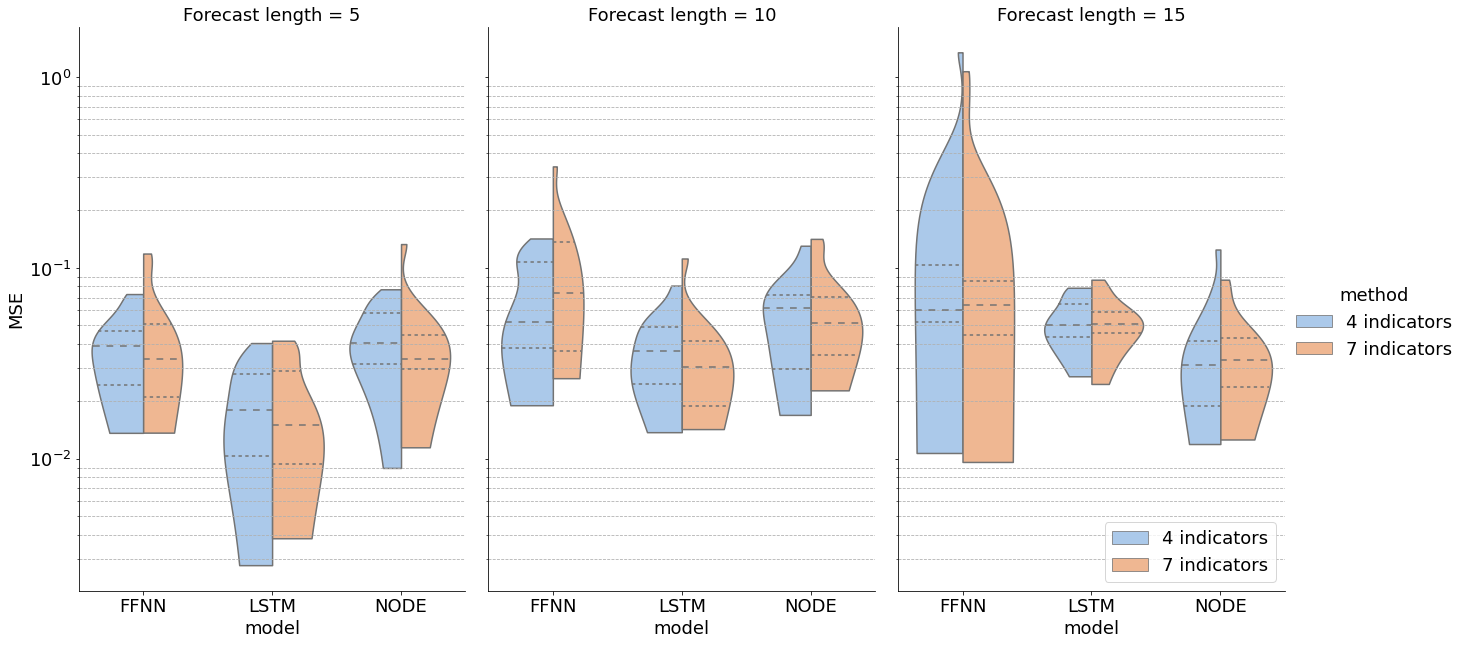

In [ ]:
import seaborn as sns

forecast_lengths = [5,10,15]

labels = [model + str(forecast_length) for forecast_length in forecast_lengths for model in ["FFNN", "LSTM", "NODE"] ]
dfs = []

for j, method in enumerate(['4 indicators', '7 indicators']):
  # for i, label in enumerate(labels):
  for f, fl in enumerate(forecast_lengths):
    for k, model in enumerate(["FFNN", "LSTM", "NODE"]):
      dfs.append(pd.DataFrame({'MSE':MSEs_add[f, k, j,:], 'model & forecast length':label, 'model': model, 'Forecast length': fl, 'method':method}))

df = pd.concat(dfs)


# fig, ax = plt.subplots(figsize=(15,9))
# ax = sns.violinplot(data = df, x='model & forecast length', y='MSE', hue='method', split=True, palette="muted", inner="quartiles", cut=0)
g = sns.catplot(data = df, x='model', y='MSE', hue='method', col = 'Forecast length', kind='violin', height = 9, aspect = 0.66, split=True, palette="pastel", inner="quartiles", cut=0)




for ax in g.axes[0]:
  # print(ax)
  ax.grid(b=True, axis='y', which='minor', linestyle='--')

plt.legend(loc = 'lower right')
plt.yscale("log")
plt.savefig("additional_variables.png",bbox_inches='tight')
# ax = sns.violinplot(x="day", y="total_bill", hue="sex",
#                     data=tips, palette="Set2", split=True,
#                     scale="count", inner="stick")

# Neural ODEs testing

## Single-country

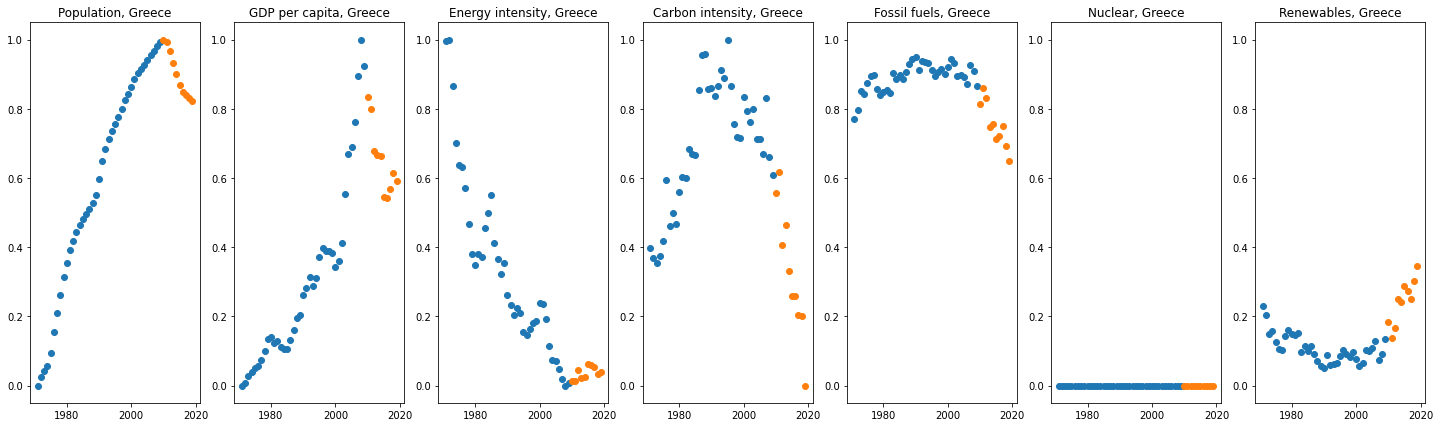

In [ ]:
indicators = ["Population", "GDP per capita", "Energy intensity", "Carbon intensity", "Fossil fuels", "Nuclear", "Renewables"]
countries = ["Greece"]

dataset = load_dataset(countries, indicators)
dataset[:,0:4] = normalize_dataset(dataset[:,0:4], min=0, max=1)

forecast_length = 10
# training_dataset, validation_dataset = dataset[:,:,:-forecast_length], dataset[:,:,-forecast_length:]
training_dataset, validation_dataset = dataset[:,:,:-forecast_length], dataset[:,:,-forecast_length:]

plot_dataset_and_predictions(training_dataset, validation_dataset)

step: 500, loss: 0.013789141550660133


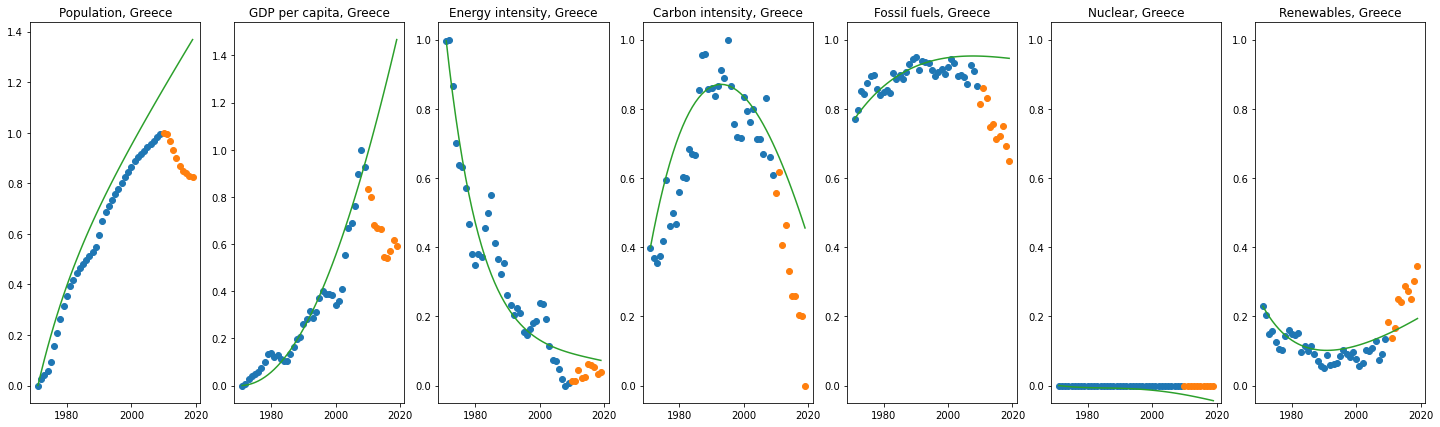

step: 1000, loss: 0.011976619251072407


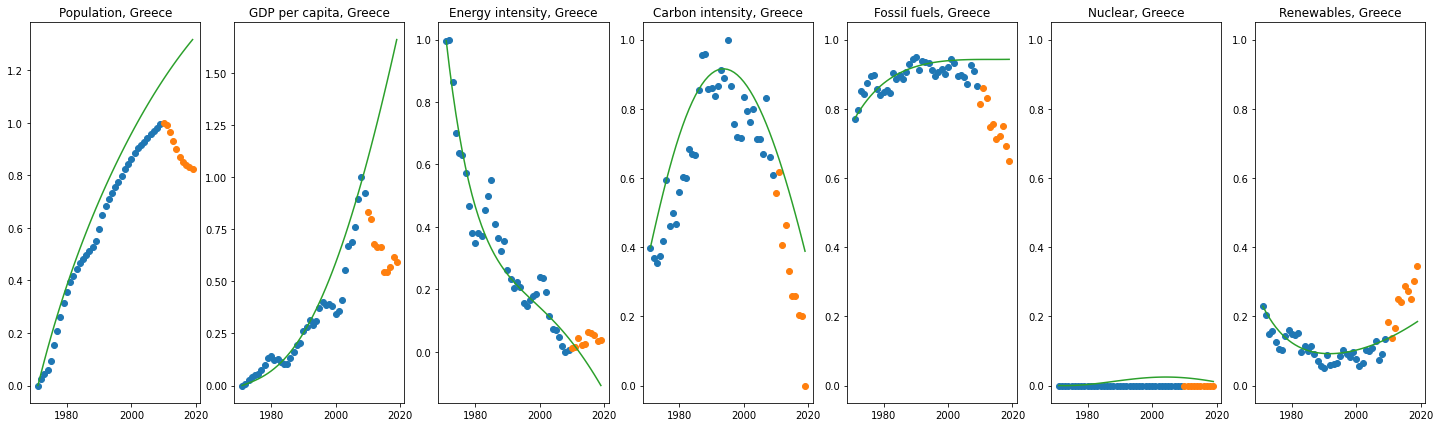

step: 1500, loss: 0.012375677935779095


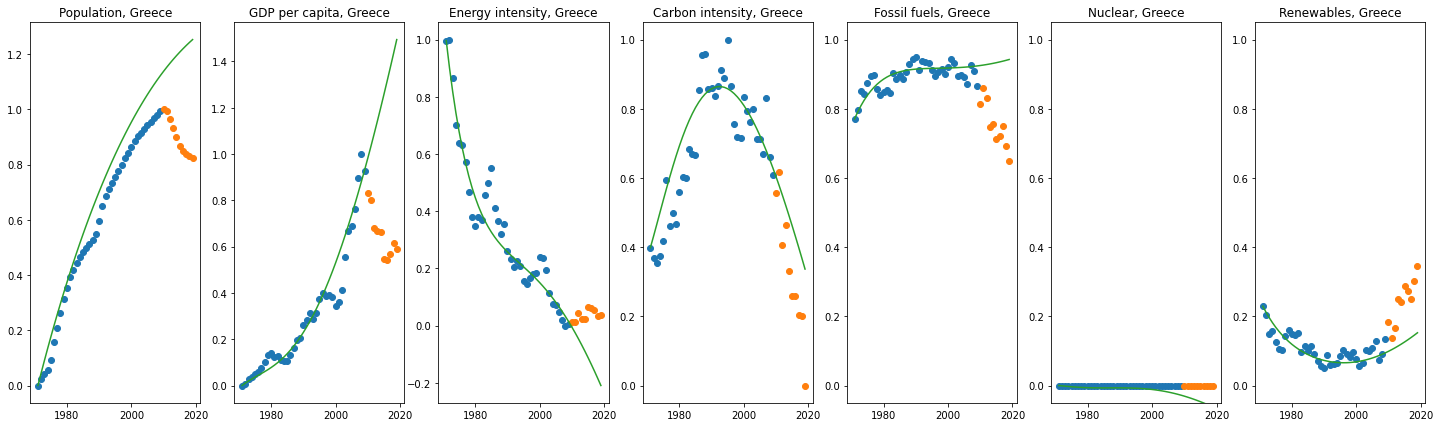

step: 2000, loss: 0.01133696548640728


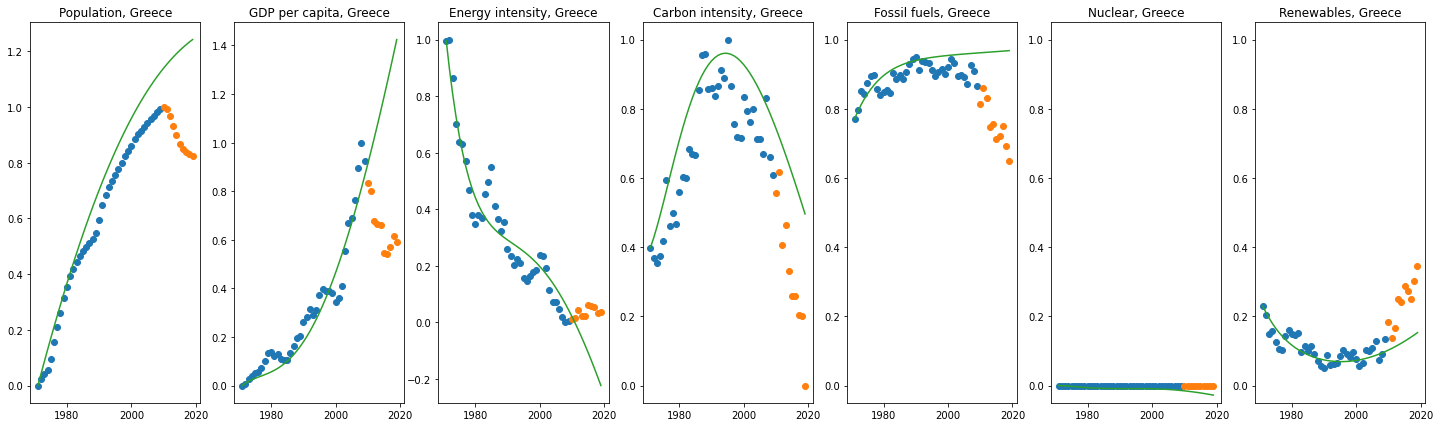

step: 2500, loss: 0.008480258285999298


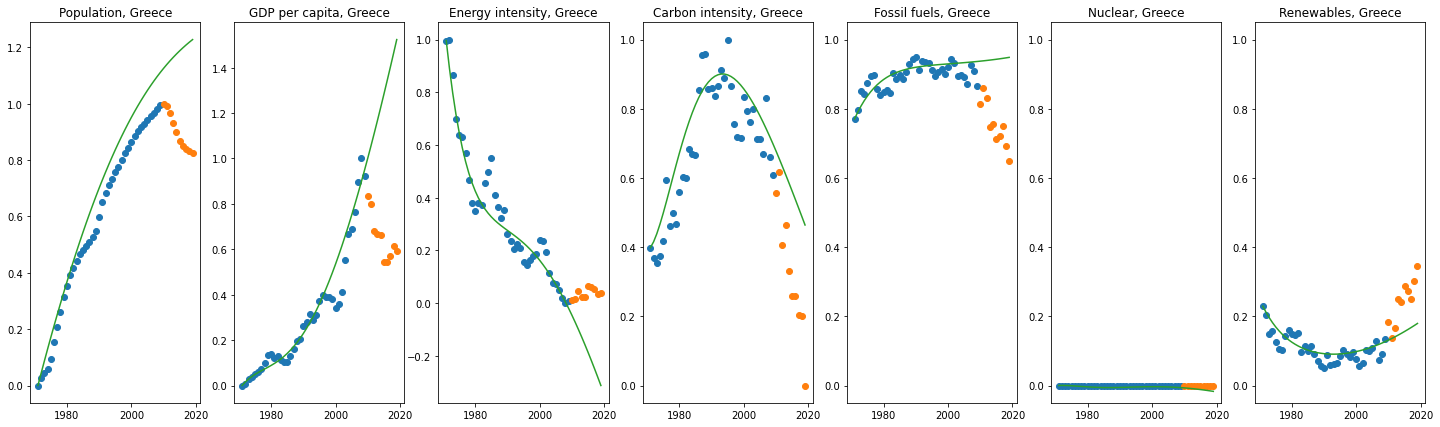

step: 3000, loss: 0.009017787873744965


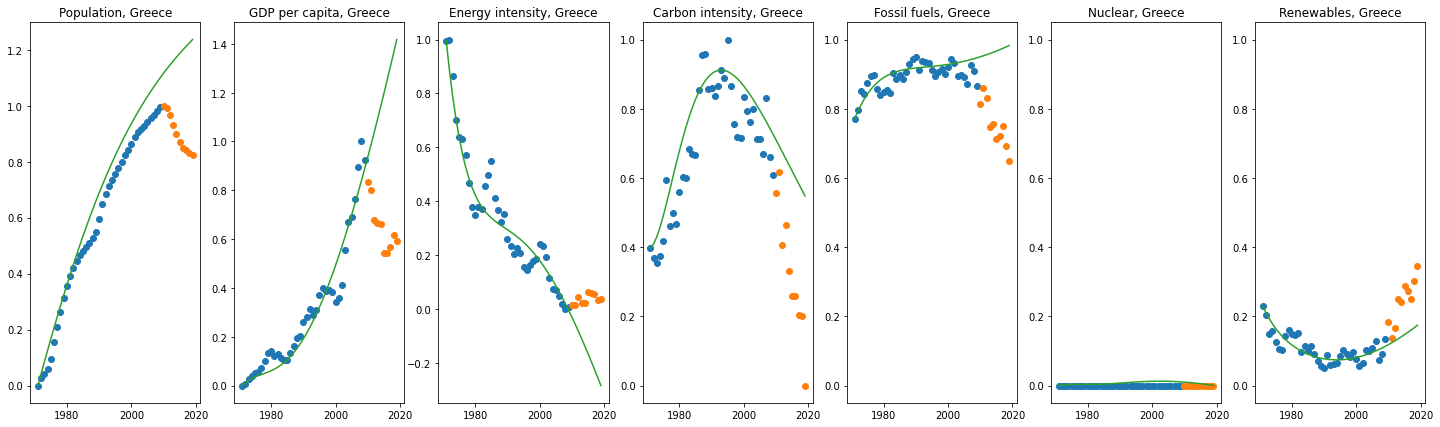

0.07972714


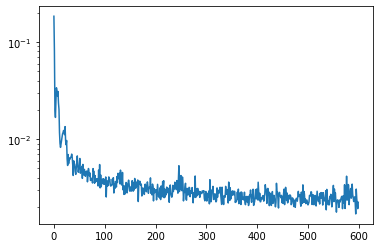

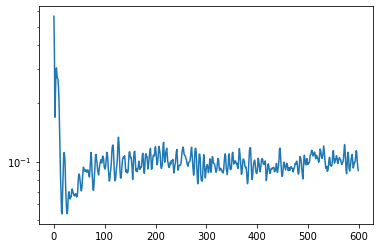

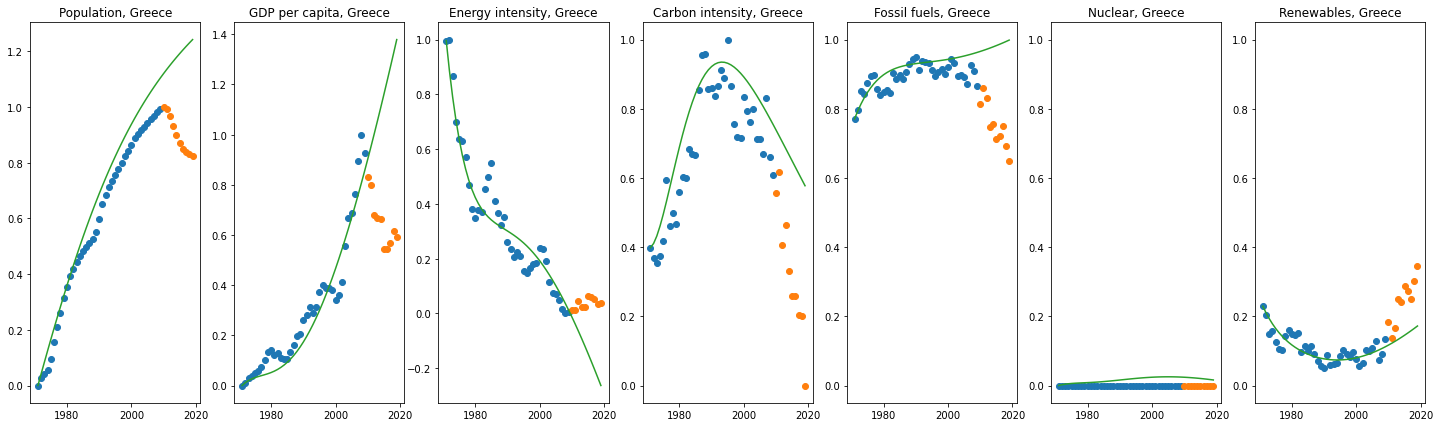

[0.08773119]


In [ ]:
perfs = []
model, losses = NODE_init_and_train(training_dataset, validation_dataset, ShallowLinearODEF, 1024, 3000, 500, 5, 0.002)

plot_losses(losses)
plot_losses(perfs)
print(np.min(np.array(perfs)[-200:]))

forecast_NODE, perf = NODE_forecast(training_dataset, validation_dataset, model)
plot_dataset_and_predictions(training_dataset, validation_dataset, [forecast_NODE], ["NODE"])
print(perf)

## Multi-country

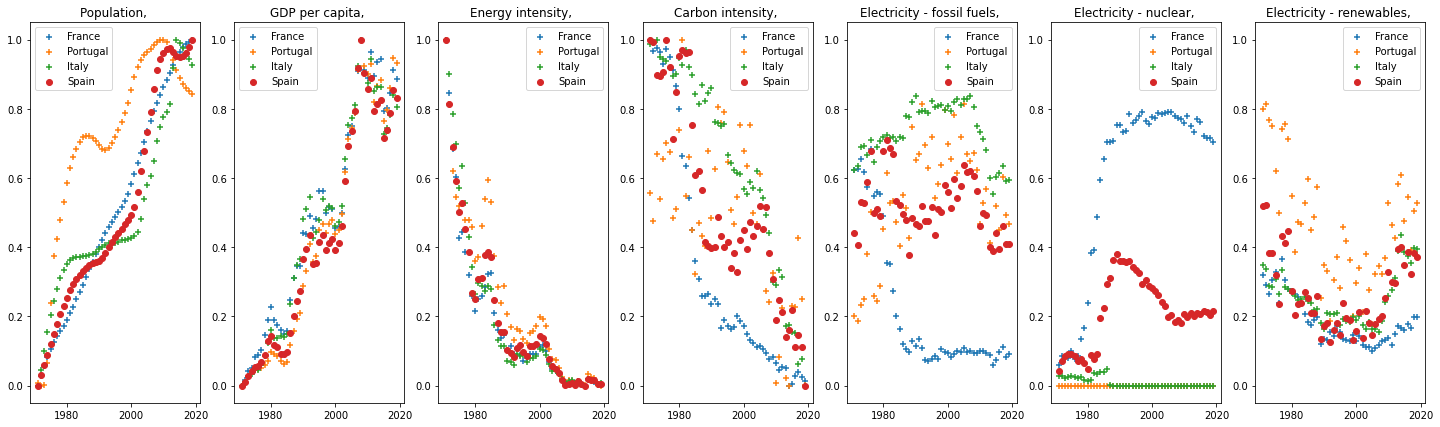

In [ ]:
indicators = ["Population", "GDP per capita", "Energy intensity", "Carbon intensity", "Electricity - fossil fuels", "Electricity - nuclear", "Electricity - renewables"]
countries = ["France", "Portugal", "Italy", 'Spain']#, 'Germany', 'United Kingdom', 'Portugal', 'Greece', 'Norway']

dataset = load_dataset(countries, indicators)
dataset[:,0:4] = normalize_dataset(dataset[:,0:4], min=0, max=1)

forecast_length = 10
training_dataset, validation_dataset = dataset[:3,:,:], dataset[3:,:,:]

plot_dataset_and_predictions(training_dataset, validation_dataset)


In [4]:
# # nb_indicators = training_dataset.shape[-1]
# # model = NeuralODE(ShallowLinearODEF(nb_indicators, nb_indicators + len(countries) + 1, 64)).to(device=device)
# # # model = NeuralODE(ShallowLinearODEF(nb_indicators, nb_indicators + 2, 128)).to(device=device)
# # optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=0.0001)

# # n_step = 8000
# # n_plot = 500

# # model.train()
# # model, losses = train_model_multivariate_multicountries(model, optimizer, training_dataset, t, alpha=1, n_step=n_step, n_plot=n_plot, t_extrapolation = t_extrapolation)
# # plot_losses(losses)

# # model.eval()
# # plot_extrapolation_multivariate_multicountries(model, training_dataset.to(device=device), t, t_extrapolation)



# # model, losses = NODE_init_and_train(training_dataset, validation_dataset, ShallowLinearODEF, 64, 8000, 500, lr=0.0002, weight_decay = 0.0001)
# # plot_losses(losses)


# perfs = []
# model, losses = NODE_init_and_train(training_dataset, validation_dataset, ShallowLinearODEF, 1024, 6000, 1000, 1, 0.003)

# plot_losses(losses)
# plot_losses(perfs)
# print(np.min(np.array(perfs)[-200:]))